# CNN: Precting Polarization through CNN Text Classification 

I followed a great [guide](https://chriskhanhtran.github.io/posts/cnn-sentence-classification/) about using CNNs for Sentence Classification from **Chris Tran** (huge thanks to this guy!) Also, Ben Trevett has a great [tutorial](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb) for pytorch-sentiment-analysis using CNNs.

In [1]:
import pandas as pd
import numpy as np
import pre_processing as pp
import torch
import random

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    USE_CUDA=True

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    USE_CUDA=False

No GPU available, using the CPU instead.


In [3]:
SEED = 30255 # Specify a seed for reproducability

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 0. Download Data

In [4]:
tweets = pd.read_csv('data/tweets_all.csv')
tweets = tweets[tweets.text.notnull()]
tweets = tweets.drop_duplicates(subset=['text'], keep='first')
print(tweets.shape)
tweets.head()

(53009, 7)


,id,topic,source,text,replyCount,vaderCatLabel,vaderCat
0,1377385383168765952,NaN,FoxNews,Activists protest renaming Chicago school afte...,306,high,1.0
1,1377384607969013765,NaN,FoxNews,Border Patrol video shows smugglers abandoning...,108,high,1.0
2,1377384339105669122,NaN,FoxNews,Cause of Tiger Woods car crash determined but ...,169,low,0.0
3,1377367836046192641,NaN,FoxNews,GOP rep urges HHS to halt reported plan to rel...,80,high,1.0
4,1377358399759785987,NaN,FoxNews,Some Democrats trying to stop Iowa New Hampshi...,96,high,1.0


In [5]:
tweets.vaderCat.unique()

array([1., 0.])

### 0.1 What is the max number of words for a given tweet in the dataset? 
This will be used as the fix length of a sentence in our model 

In [6]:
print('Max number of words for a given tweet in the Dataset:')
max_len = tweets.text.apply(lambda x: len(x.split())).max()
print(max_len)

Max number of words for a given tweet in the Dataset:
56


In [7]:
t= tweets.groupby('vaderCatLabel').size()
print(t)
print("observations for filtered data:{}".format(t.sum()))

vaderCatLabel
high    27609
low     25400
dtype: int64
observations for filtered data:53009


### 0.1 What data to use? Filter by topic? By number of replies? Use all?

In [8]:
# Split according to label
from sklearn.model_selection import train_test_split

tweets_low_all = tweets[tweets['vaderCat'] == 0]
tweets_high_all = tweets[tweets['vaderCat'] == 1]

tweets_high_all, rejected = train_test_split(tweets_high_all,
                                             train_size=(tweets_low_all.shape[0]/
                                                         tweets_high_all.shape[0]),random_state=0)

data_to_use = tweets_high_all.append(tweets_low_all)

In [9]:
data_to_use.groupby('vaderCatLabel').size()

vaderCatLabel
high    25400
low     25400
dtype: int64

## 1. Convert to Pytorch Data Objects

### 1.1 Data Class

In [10]:
from dataclassCNN import ProjectDataset

In [11]:
data_obj = ProjectDataset(data_to_use, 'vaderCat', 'text')

## 2. Get Vocabulary and Pre-trained Vectors

### Vocabulary from dataset

In [12]:
from collections import Counter
from torchtext.vocab import Vocab


counter_words = Counter()
for (label, text) in data_obj:
    counter_words.update(text)
    
vocab_words = Vocab(counter_words)

print('The vocabulary length is {} words'.format(len(vocab_words)))

The vocabulary length is 32523 words


### Load Pre-trained vectors (e.g. GloVe or FastText) and get the pre-trained vectors from vocabulary

In [13]:
VECTORS_CACHE_DIR = './.vector_cache'

In [14]:
from torchtext import vocab

pretrained_emb = vocab.GloVe(name='6B',cache=VECTORS_CACHE_DIR)

pre_trained_vectors = pretrained_emb.get_vecs_by_tokens(vocab_words.itos,
                                                       lower_case_backup=True)

## 3. Collate Function for CNN Model

We are going to use the pre-trained embeddings and construct a `max_len` (53) long vector of embeddings, adding the `<pad>` word vector to the end for the tweets (sentences) that do not have the full `max_len`. 

In [15]:
def collate_for_cnn(batch, max_len=max_len):
    '''
    For each batch, develop the appropiate inputs from the models (i.e. embeddings)
    '''
    input_vector = []
    labels = []
    for i, (label, tokenized_sent) in enumerate(batch):
        
        #Append labels 
        labels.append(label)
        
        #Get tokenized sentence
        diff =  (max_len - len(tokenized_sent))
        tokenized_sent += ['<pad>'] * diff
        
       
        assert(len(tokenized_sent) == max_len), tokenized_sent
        
        wordstoidx = [vocab_words.stoi[w] for w in tokenized_sent]
        input_vector.append(wordstoidx)
    
    return torch.tensor(labels).to(device), torch.tensor(input_vector).to(device)

## 4. Setting up Train, Validation, Test set and DataLoader Class

In [16]:
from torch.utils.data import DataLoader

In [17]:
from sklearn.model_selection import train_test_split

# Train with Validation Data and Test Data Split
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    data_to_use['text'], data_to_use['vaderCat'], test_size=0.1, random_state=42)

#Train and Validation Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.1, random_state=42)

In [18]:
def data_loader(train_tuple, val_tuple, test_tuple,
                batch_size=30):
    """Convert train, validation and test sets into Dataloaders :)
    """

    # Create DataLoader for training data
    train_data = ProjectDataset(train_tuple)
    train_dataloader = DataLoader(train_data, shuffle=True,
                                  batch_size=batch_size, 
                                 collate_fn=collate_for_cnn)
    
    # Create DataLoader for validation data
    valid_data = ProjectDataset(val_tuple)
    val_dataloader = DataLoader(valid_data, shuffle=False,
                                  batch_size=batch_size, 
                                 collate_fn=collate_for_cnn)

    # Create DataLoader for test data
    test_data = ProjectDataset(test_tuple)
    test_dataloader = DataLoader(test_data, shuffle=False,
                                  batch_size=batch_size, 
                                 collate_fn=collate_for_cnn)

    return train_dataloader, val_dataloader, test_dataloader

In [19]:
train_dataloader, val_dataloader, test_dataloader = data_loader([train_labels, train_texts],
                                                               [val_labels, val_texts],
                                                               [test_labels, test_texts])

In [20]:
for i in train_dataloader:
    labels, inputs = i[0], i[1]
    print(inputs.shape)
    break

torch.Size([30, 56])


## 5. Model Building: CNN Arquitecture

explanation here


In [21]:
FILTER_SIZES = [3,4,5]
N_FILTERS = [100, 100,100]
DROPOUT = 0.5
PAD_IDX = vocab_words.stoi['<pad>']
num_classes = 3 #Low, Medium, High

### 5.1 CNN Model Class

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_polarization(nn.Module):
    ''' An 1D Convulational Neural Network for Sentence Classification'''
    
    def __init__(self, pretrained_embedding=None, freeze_embedding=False,
                 vocab_size=None, embed_dim=None,
                 filter_sizes=FILTER_SIZES, num_filters=N_FILTERS,
                 num_classes=num_classes,pad_id=PAD_IDX,
                 dropout=DROPOUT):
        """
        pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (int): Number of filters. Default: 100
            n_classes (int): Number of classes. Default: 3
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_polarization, self).__init__()
        
        # 1. Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx= pad_id,
                                          )
        
        # 2. Convolutional Layers (for each filter size --> n-gram)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = self.embed_dim,
                                              out_channels = num_filters[i], 
                                              kernel_size = fs)
                                    for i, fs in enumerate(filter_sizes)
                                    ])
        
    
        # 3. Fully-connected layer
        self.linear = nn.Linear(in_features = np.sum(num_filters), 
                                out_features = num_classes
                               )
        
        
        # Additional Feature
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):

        x_embedded = self.embedding(inputs)
        
        x_embedded = x_embedded.permute(0, 2, 1)
        
        # Apply CNN and ReLU
        convs_list = [F.relu(conv(x_embedded)) for conv in self.convs]

        # Max pooling.
        pooled = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]).squeeze(2)
                  for x_conv in convs_list]
        
        # Concatenate Pool list to feed the fully connected layer
        input_fc = self.dropout(torch.cat(pooled, dim = 1))
        
        # Compute probabilities
        predictions_classes = self.linear(input_fc)
        
        return predictions_classes

### 5.3 Training Function for one epoch

In [23]:

def train_an_epoch(model, dataloader, loss_function, optimizer):
    
    model.train() # Sets the module in training mode.
    total_loss = 0
    
    for idx, batch in enumerate(dataloader):
        
        # Load batch to GPU
        labels, inputs = tuple(t.to(device) for t in batch)
        
        # Zero out any previously calculated gradients
        model.zero_grad()
        
        #Perform a forward pass.
        log_probs = model(inputs)
        
        # Compute loss and accumulate the loss values
        loss = loss_function(log_probs, labels.long())
        total_loss += loss.item()
        
        # Perform a backward pass to calculate gradients
        loss.backward()
        optimizer.step()
    
    return total_loss/len(dataloader)

### 5.4 Evaluate Function

In [24]:
def evaluate(model, dataloader, loss_fn):
    '''
    Evaluate the model on the given data (e.g. validation data or test data).
    '''

    #As we are now using dropout, we must remember to use model.eval() 
    #to ensure the dropout is "turned off" while evaluating.
    model.eval()
    
    total_accuracy = []
    total_loss = []
    
    with torch.no_grad():
        # No gradients need to be maintained during evaluation
        for i, batch in enumerate(dataloader):
            
            # Load batch to Device
            labels, inputs = batch[0], batch[1]
            if USE_CUDA:
                labels, inputs = labels.cuda(), inputs.cuda()
                
            # Obtain probabilities of each class per sentence
            output = model(inputs)
            
            # Compute loss
            loss = loss_fn(output, labels.long())
            total_loss.append(loss.item())

            # Get the predictions
            preds = torch.argmax(output, dim=1).flatten()
            
            # Calculate the accuracy rate
            accuracy = (preds == labels).sum()/len(preds)
            total_accuracy.append(accuracy)
            

    return np.mean(total_loss), np.mean(total_accuracy)

### 5.5 Complete Training Function (With early stopping for best model)

In [25]:
import datetime

def train_validate(model, optimizer, train_dataloader, val_dataloader, pretrained_embedding, epochs=20):
    
    """Train the CNN model."""
    
    #Loss function
    loss_function = nn.CrossEntropyLoss()
    
    # Tracking best model
    val_losses = []
    val_accuracies = []
    best_model = None
    
    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Time(secs)':^8} | {'Train Loss':^9}| {'Val Loss':^10}| {'Val Acc':^11}")
    print("-"*60)

    for epoch_i in range(epochs):
        start_time = datetime.datetime.now()
        # =======================================
        #               Training
        # =======================================
        
        avg_loss_train = train_an_epoch(model, train_dataloader, loss_function, optimizer)
        
        # =======================================
        #               Evaluation
        # =======================================
        
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function)

        # Track the best model
        if len(val_losses) == 0 or val_loss < min(val_losses):
            best_model = type(model)(pretrained_embedding=pretrained_embedding,
                                     vocab_size=len(vocab_words), 
                                     embed_dim=model.embed_dim,
                                     filter_sizes=filter_sizes,
                                     num_filters=N_FILTERS, num_classes=num_classes)
            best_model.load_state_dict(model.state_dict())
            if USE_CUDA:
                best_model = best_model.cuda()
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        time_diff = (datetime.datetime.now() - start_time).seconds
        
        print(f"{epoch_i + 1:^7} |  {time_diff:^8}  | {avg_loss_train:^9.2f} | {val_loss:^10.2f}| {val_accuracy:^11.2f}")
        print('')
        
    return best_model, val_accuracies

## 6. Train the model

In [28]:
num_classes = len(tweets.vaderCat.unique())
filter_sizes = [3, 4, 5] # bi-grams, tri-grams, four-grams filters
N_FILTERS = [200,100,100]

### 6.1 Initialize Model and Optimizer

In [29]:
cnn_model = CNN_polarization(pretrained_embedding=None,
                 vocab_size=len(vocab_words), embed_dim=400,
                        freeze_embedding=False,
                        filter_sizes=filter_sizes,
                        num_filters=N_FILTERS,
                        num_classes=num_classes,
                        dropout=0.5).to(device)

In [30]:
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn_model.parameters(), 
                                 lr=learning_rate)

In [31]:
best_model, val_accuracies = train_validate(cnn_model, optimizer, 
                                            train_dataloader, val_dataloader, 
                                            pretrained_embedding=None,
                                            epochs=5)

Start training...

 Epoch  | Time(secs) | Train Loss|  Val Loss |   Val Acc  
------------------------------------------------------------
   1    |    261     |   0.73    |    0.66   |    0.60    

   2    |    267     |   0.70    |    0.67   |    0.61    

   3    |    267     |   0.64    |    0.66   |    0.61    

   4    |    274     |   0.58    |    0.73   |    0.60    

   5    |    269     |   0.48    |    0.74   |    0.61    



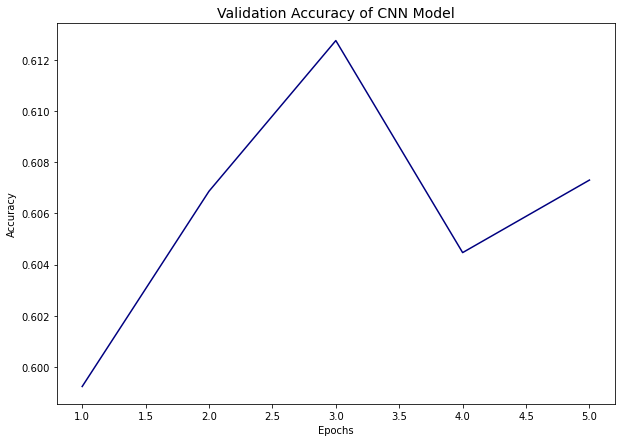

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,7))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, color='navy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Validation Accuracy of CNN Model', fontsize=14);

## 7. Test the Best Model

In [33]:
#Loss function
loss_function = nn.CrossEntropyLoss()
test_loss, test_accuracy = evaluate(best_model, test_dataloader, loss_function)

In [34]:
test_accuracy

0.622549

In [35]:
best_model.embed_dim

400

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(model, test_loader, device='cpu'):
    print('Evaluate')
    y_pred = []
    y_true = []

    total_accuracy = []

    with torch.no_grad():
        # No gradients need to be maintained during evaluation
        for i, batch in enumerate(test_loader):
            # Load batch to Device
            labels, inputs = batch[0], batch[1]
            labels, inputs = labels.to(device), inputs.to(device)
            # Obtain probabilities of each class per sentence
            output = model(inputs)
            # Get the predictions
            preds = torch.argmax(output, dim=1).flatten()
            # Calculate the accuracy rate
            accuracy = (preds == labels).sum()/len(preds)
            total_accuracy.append(accuracy)
            y_pred.extend(list(preds))
            y_true.extend(list(labels))

    acc = 0.0
    for i, y in enumerate(y_pred):
        if y == y_true[i]:
            acc += 1.0

    acc = acc / len(y_pred)

    print('Test Accuracy: ', acc)

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1, 0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['HIGH', 'LOW'])
    ax.yaxis.set_ticklabels(['HIGH', 'LOW'])

    return None

Evaluate
Test Accuracy:  0.6226377952755906
Classification Report:
              precision    recall  f1-score   support

           1     0.6113    0.6428    0.6267      2503
           0     0.6348    0.6030    0.6185      2577

    accuracy                         0.6226      5080
   macro avg     0.6231    0.6229    0.6226      5080
weighted avg     0.6232    0.6226    0.6225      5080



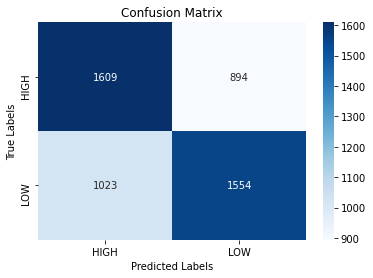

In [37]:
plot_metrics(best_model, test_dataloader)

## 8. Feature importance 

### 8.1 Integrated Gradient

In [38]:
from captum.attr import IntegratedGradients, LayerIntegratedGradients, TokenReferenceBase, visualization
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [39]:
test_texts

19637    GameStop shares dropped sharply after the vide...
8886     Indian police have detained more than  Rohingy...
22241    Florida health officials said two women dresse...
45090     states have so far signed on to President Tru...
56357    Supporters of President Trump gathered in Wash...
                               ...                        
851      Adding an entire orange to this easy snacking ...
3934     Asked about the accounts of violence and intim...
48397    The Trump campaign has notified attendees of T...
42922    Once reluctant to hit China on human rights Tr...
33331    Our president wants us here  QAnon Proud Boys ...
Name: text, Length: 5080, dtype: object

In [40]:
test_texts=list(test_texts)

In [41]:
test_labels

19637    1.0
8886     1.0
22241    0.0
45090    1.0
56357    1.0
        ... 
851      0.0
3934     1.0
48397    0.0
42922    0.0
33331    1.0
Name: vaderCat, Length: 5080, dtype: float64

In [42]:
test_labels = list(test_labels)

In [120]:
forward_func = lambda x: F.softmax(best_model(x), dim=-1)
lig = LayerIntegratedGradients(forward_func, best_model.embedding)
token_reference = TokenReferenceBase(reference_token_idx=PAD_IDX)

In [121]:
vis_data_records_ig = []

def int_gradient(text, true_label, target_label=0, max_len=max_len):
    print(text)
    words = tokenizer(text)
    if len(words) < max_len:
        words += ['<pad>'] * (max_len - len(words))
    tokens = [vocab_words.stoi[w] for w in words]
    print(tokens)
    
    best_model.zero_grad()
    input_indices = torch.tensor(tokens, device=device)
    input_indices = input_indices.unsqueeze(0)
    #print(input_indices)
    
    # predict
    probs = forward_func(input_indices)
    print(probs)
    pred = torch.argmax(probs).item()
    pred_prob = probs.tolist()[0][pred]
    
    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(max_len, device=device).unsqueeze(0)
    #print(reference_indices)
    
    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=500, target=target_label, return_convergence_delta=True)
    
    print('pred: ', pred, '(', '%.2f'%pred_prob, ')', ', delta: ', abs(delta.tolist()[0]))   
    add_attributions_to_visualizer(attributions_ig, tokenizer(text), pred_prob, pred, true_label,
                                   delta, target_label, vis_data_records_ig)
    return attributions_ig.sum(dim=2).squeeze(0)

def add_attributions_to_visualizer(attributions, text, pred_prob, pred, label, delta, target, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    print(label)
    true_label = 'High' if int(label) == 1 else 'Low'
    pred_label = 'High' if int(pred) == 1 else 'Low'
    target_label = 'High' if int(target) == 1 else 'Low'
    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred_prob,
                            pred_label,
                            true_label,
                            target_label,
                            attributions.sum(),       
                            text,
                            delta))

In [118]:
#3000 h 
#1000, 5000, 58 10l
int_gradient(test_texts[3000], test_labels[3000])
int_gradient(test_texts[200], test_labels[200])
int_gradient(test_texts[1], test_labels[1])

#[0.3047, 0.4705, 0.2248]

Pelosi thanks George Floyd for sacrificing your life for justice after Chauvin guilty verdict
[592, 2635, 208, 337, 8, 16575, 364, 258, 8, 271, 25, 401, 829, 1701, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1686, 0.8314]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.83 ) , delta:  4.255851790602172e-05
1.0
The number of migrant children detained at the U S  Mexico border has tripled in two weeks testing President Bidens promise of a more humane policy  The problem could also upend his efforts to legalize millions of undocumented immigrants 
[2, 413, 4, 1104, 395, 1316, 18, 2, 19, 17, 450, 278, 23, 12855, 6, 67, 238, 983, 11, 61, 1774, 4, 5, 40, 11074, 352, 2, 1492, 83, 274, 6034, 20, 402, 3, 5544, 456, 4, 3986, 1307, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3591, 0.6409]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  0.00011764117800538987
1.0
Indian police have deta

tensor([-0.0026,  0.0282, -0.0093, -0.0024, -0.0296, -0.0057,  0.0603, -0.0481,
        -0.0148, -0.1203, -0.0196, -0.0208, -0.0229,  0.0089,  0.0247, -0.0317,
         0.0146, -0.0178,  0.0330, -0.0100, -0.0029,  0.0037, -0.0101, -0.0005,
        -0.0243, -0.0136,  0.0230,  0.0104, -0.0600, -0.0722, -0.0226, -0.0224,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       dtype=torch.float64)

In [119]:
print('Visualize attributions based on Integrated Gradients')
_ = visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


In [122]:
words_importance = {}

for i in range(len(test_texts)):
    temp_numbers = int_gradient(test_texts[i], test_labels[i])
    temp_numbers = temp_numbers / torch.norm(temp_numbers)
    
    for n, w in enumerate(test_texts[i].split()):
        if len(w) > 4:
            words_importance[w] = words_importance.get(w, 0.0) + temp_numbers[n]     

GameStop shares dropped sharply after the video game retailer at the center of this years Reddit driven trading frenzy said it may sell additional stocks worth up to   billion as it tries to take advantage of the stock price surge
[656, 674, 1795, 2847, 25, 2, 213, 828, 3788, 18, 2, 616, 4, 50, 87, 2213, 1912, 889, 2232, 24, 30, 121, 1382, 1722, 702, 1864, 63, 3, 216, 13, 30, 2593, 3, 177, 2808, 4, 2, 888, 1273, 451, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7525, 0.2475]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.75 ) , delta:  4.367647842845601e-05
1.0
Indian police have detained more than  Rohingya refugees found living illegally in the northern region of Jammu and Kashmir  A process has begun to deport them back to Myanmar two officials said
[850, 54, 35, 1316, 40, 60, 5242, 3359, 243, 1120, 2781, 6, 2, 836, 944, 4, 19161, 7, 6390, 5, 776, 23, 2750, 3, 15253, 139, 123, 3, 255, 67, 98, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor

pred:  1 ( 0.55 ) , delta:  0.0001560938780972021
1.0
Mark Meadows President Trumps chief of staff tested positive for the coronavirus on Wednesday an official said on Friday 
[627, 3301, 11, 42, 189, 4, 491, 512, 399, 8, 2, 48, 9, 266, 29, 220, 24, 9, 305, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3411, 0.6589]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.66 ) , delta:  0.0001614840822618535
1.0
My dad was a healthy  year old  His only pre existing condition was trusting Donald Trump and for that he paid with his life Kristin Urquiza said when talking about her father who died from COVID   DemConvention
[398, 4493, 26, 5, 4795, 58, 165, 20, 227, 1479, 3453, 2108, 26, 16936, 77, 10, 7, 8, 12, 27, 1066, 16, 20, 258, 7363, 12889, 24, 100, 2317, 44, 57, 974, 37, 235, 22, 31, 1793, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3292, 0.6708]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.67 ) , del

pred:  0 ( 0.52 ) , delta:  8.541275473272769e-05
1.0
NFL great Brett Favre and NHL star Bobby Orr publicly lent their support to President Trumps campaign on Friday making them among the most prominent figures in sports to do so  Golf icon Jack Nicklaus said on Thursday that he had voted for Trump 
[1920, 615, 6291, 18533, 7, 10275, 594, 17550, 28465, 1716, 11165, 51, 228, 3, 11, 42, 97, 9, 305, 384, 139, 325, 2, 115, 1752, 1841, 6, 1779, 3, 195, 187, 2118, 5199, 1769, 19771, 24, 9, 269, 12, 27, 79, 666, 8, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2914, 0.7086]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.71 ) , delta:  1.6800803785244067e-05
1.0
A dejected President Trump continues to waffle over waging baseless election fight
[5, 24015, 11, 10, 1052, 3, 32116, 45, 17047, 1706, 47, 368, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2696, 0.7304]], grad_fn=<SoftmaxBackward>)
pred:  

pred:  0 ( 0.60 ) , delta:  1.0280422314453905e-05
0.0
Nobody likes me President Trump complains as even his allies fade
[4233, 4677, 659, 11, 10, 9924, 13, 175, 20, 600, 9340, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3943, 0.6057]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.61 ) , delta:  2.6684624286954506e-05
1.0
McDonalds has been sued by  Black former franchise owners who accuse the fast food giant of racial discrimination by steering them to depressed crime ridden neighborhoods and setting them up for failure  MCD
[3237, 23, 62, 1860, 21, 55, 66, 6358, 2310, 37, 3904, 2, 1538, 875, 857, 4, 761, 2231, 21, 5802, 139, 3, 9278, 1295, 11404, 3775, 7, 1665, 139, 63, 8, 1446, 12395, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2462, 0.7538]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.75 ) , delta:  3.507837193050811e-06
1.0
Newt Gingrich denies Georgia 

pred:  1 ( 0.59 ) , delta:  5.393572229789312e-05
0.0
Joe Biden maintained a lead over President Trump in Pennsylvania and Florida after the first general election debate according to New York Times Siena College surveys 
[34, 15, 7004, 5, 307, 45, 11, 10, 6, 503, 7, 409, 25, 2, 41, 264, 47, 199, 135, 3, 28, 99, 241, 5793, 489, 8446, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1717, 0.8283]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.83 ) , delta:  4.0096907983899754e-05
0.0
Here is a look at how President Trump and Democratic nominee Joe Biden clash on key healthcare issues
[163, 14, 5, 303, 18, 80, 11, 10, 7, 122, 284, 34, 15, 2759, 9, 371, 2003, 685, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5416, 0.4584]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.54 ) , delta:  9.189509084622793e-05
1.0
Its clear the mail still has power and allies of President Tr

pred:  1 ( 0.62 ) , delta:  3.8795683512726775e-05
0.0
A two block mural dedicated to George Floyd has been painted directly in front of his high school in Houston
[5, 67, 900, 5556, 4387, 3, 208, 337, 23, 62, 3632, 2262, 6, 1055, 4, 20, 254, 449, 6, 3290, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3792, 0.6208]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.62 ) , delta:  0.00021278608499591956
1.0
Sophisticated scanning technology is revealing intriguing secrets about Little Foot the remarkable fossil of an early human forerunner that inhabited South Africa   million years ago during a critical juncture in our evolutionary history
[10477, 20565, 1261, 14, 4061, 26436, 5090, 44, 730, 2464, 2, 7079, 2027, 4, 29, 338, 636, 25188, 12, 13680, 204, 992, 107, 87, 569, 84, 5, 1315, 26652, 6, 131, 18462, 277, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5795, 0.4205]], grad_fn=<SoftmaxBac

pred:  1 ( 0.87 ) , delta:  6.9983724247379975e-06
0.0
Brown bears play with each other and enjoy in a pool of water as they come out of hibernation at a Belgian zoo 
[1396, 2456, 952, 16, 820, 128, 7, 2867, 6, 5, 4240, 4, 696, 13, 64, 635, 71, 4, 12212, 18, 5, 3909, 728, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6731, 0.3269]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.67 ) , delta:  3.8020310097919285e-05
0.0
Dozens of Black business leaders are calling on companies to fight a wave of voting rights bills being advanced by Republicans  The effort is a response to the swift passage of a Georgia law that they contend makes it harder for Black people to vote 
[897, 4, 55, 391, 280, 32, 608, 9, 367, 3, 368, 5, 793, 4, 289, 300, 2680, 167, 4276, 21, 173, 2, 447, 14, 5, 405, 3, 2, 2316, 4700, 4, 5, 185, 198, 12, 64, 9246, 649, 30, 2151, 8, 55, 46, 3, 154, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4316, 0.5684]], grad_fn=<So

pred:  1 ( 0.74 ) , delta:  3.15833474480165e-05
1.0
The U S  reported  coronavirus deaths on Thursday a new one day record  Dr  Anthony Fauci said high daily tolls were likely to continue and was probably a reflection of increased travel and gatherings over the holidays 
[2, 19, 17, 549, 48, 380, 9, 269, 5, 28, 56, 85, 231, 411, 1012, 738, 24, 254, 601, 12834, 59, 369, 3, 768, 7, 26, 2274, 5, 7862, 4, 1712, 500, 7, 3684, 45, 2, 4668, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5926, 0.4074]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  6.369303927680758e-06
1.0
Threatened with more violence from outgoing Trumps supporters following last Wednesdays storming of the Capitol the issued warnings for next weekend that run at least until Inauguration Day the source said
[1597, 16, 40, 263, 22, 2732, 42, 207, 418, 86, 4466, 2190, 4, 2, 74, 2, 1449, 3072, 8, 203, 1017, 12, 428, 18, 214, 521, 318, 85, 2, 726, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  1 ( 0.63 ) , delta:  8.009720537777154e-05
0.0
Lakers legend Elgin Baylor dead at 
[7366, 3617, 18356, 8019, 493, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3316, 0.6684]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.67 ) , delta:  1.1939878307665186e-05
0.0
Albatross faceplants in an attempted landing while another albatross looks on
[12983, 18503, 6, 29, 2330, 2946, 169, 320, 12983, 948, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6813, 0.3187]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.68 ) , delta:  4.218612962027246e-05
0.0
William and Kate  Its been  years since that famous royal kiss on the balcony but where did the royal couple meet 
[1005, 7, 4414, 39, 62, 87, 145, 12, 1710, 1024, 10189, 9, 2, 5637, 49, 182, 355, 2, 1024, 1568, 579, 1, 1, 1, 1, 1, 1, 1

pred:  1 ( 0.77 ) , delta:  0.00020176678901390188
0.0
LIVE  Day two of the Derek Chauvin trial
[152, 85, 67, 4, 2, 354, 401, 126, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1717, 0.8283]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.83 ) , delta:  3.92228695510477e-05
0.0
Amazon drops French Black Friday ad campaign as lockdown starts
[536, 3039, 574, 55, 305, 1345, 97, 13, 375, 2167, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6201, 0.3799]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.62 ) , delta:  0.000110179339857467
0.0
A koala roams on a beach in Australia
[5, 5923, 12656, 9, 5, 1207, 6, 542, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6727, 0.3273]], grad_fn=<Sof

pred:  0 ( 0.55 ) , delta:  2.917459239359932e-06
1.0
Kim Jong un the North Korean leader said his economic plans had failed at a gathering of his ruling Workers Party  But he doubled down on his nuclear arms buildup 
[1048, 3694, 1519, 2, 340, 1176, 222, 24, 20, 310, 197, 79, 1069, 18, 5, 3096, 4, 20, 1198, 360, 260, 49, 27, 4017, 142, 9, 20, 650, 1705, 7213, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5048, 0.4952]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.50 ) , delta:  0.00021068165477422518
1.0
Bob Dole says hes been diagnosed with stage  lung cancer
[3146, 10898, 38, 486, 62, 4775, 16, 999, 7002, 2106, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6970, 0.3030]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.70 ) , delta:  6.086824710677119e-05
1.0
Social Media To Introduce New Fact Check Measures That Make It Impossible To Find Out How Inc

pred:  1 ( 0.52 ) , delta:  9.587671465172143e-05
0.0
President Trump has returned to the White House after spending three nights at Walter Reed Medical Center for coronavirus treatment  After exiting Marine One Trump walked up a set of stairs took off his mask and posed for photographs on a balcony 
[11, 10, 23, 1454, 3, 2, 65, 53, 25, 990, 146, 3625, 18, 2135, 2539, 518, 616, 8, 48, 963, 25, 10047, 4229, 56, 10, 4076, 63, 5, 209, 4, 12767, 374, 157, 20, 552, 7, 3474, 8, 5759, 9, 5, 5637, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2268, 0.7732]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.77 ) , delta:  0.0001489934538769777
1.0
CNBC Survey  Vast Majority Of Top Investors Believe Stocks Will Be Worse Under Biden
[5154, 2315, 2804, 517, 4, 150, 719, 950, 702, 33, 36, 1816, 156, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6567, 0.3433]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.66 ) , 

pred:  0 ( 0.76 ) , delta:  6.314576597726829e-05
0.0
What is the correct way to make scrambled eggs  
[73, 14, 2, 5662, 276, 3, 160, 5244, 5881, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8606, 0.1394]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.86 ) , delta:  6.635826805861944e-05
0.0
AstraZeneca vaccine made in India to arrive in Canada on Wednesday
[295, 52, 166, 6, 297, 3, 3023, 6, 814, 9, 266, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6405, 0.3595]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  1.8844277963087075e-05
1.0
I dont think there are two justice systems Attorney General William Barr says  The narrative that the police are on some epidemic of shooting unarmed Black men is simply a false narrative says Barr adding he does not think systemic racism exists 

pred:  0 ( 0.52 ) , delta:  7.207545422874273e-05
1.0
Indoor fitness classes which often result in heavy breathing in poorly ventilated rooms can be risky  Heres a guide to help you decide if your gym is doing enough to prevent the spread of Covid  
[2782, 5695, 2760, 116, 1132, 1470, 6, 1589, 7212, 6, 10334, 31989, 4148, 117, 36, 5088, 153, 5, 3045, 3, 194, 113, 1956, 95, 364, 5706, 14, 902, 713, 3, 1480, 2, 723, 4, 31, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5639, 0.4361]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.56 ) , delta:  7.80772149806229e-05
0.0
Australia has pulled out of a cricket tour in South Africa which has been battling a second wave of COVID  and a more transmissible variant of the virus in a decision described by the hosts as extremely disappointing
[542, 23, 2958, 71, 4, 5, 7659, 3012, 6, 204, 992, 116, 23, 62, 3210, 5, 155, 793, 4, 31, 7, 5, 40, 6787, 534, 4, 2, 299, 6, 5, 603, 1358, 21, 2, 3458, 13, 2614, 8656, 1, 1, 1, 1, 1, 1, 1,

pred:  0 ( 0.73 ) , delta:  1.718756015012257e-05
0.0
Investment deal expected to bolster European dealmaking in China
[1209, 298, 329, 3, 5478, 408, 18096, 6, 93, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6561, 0.3439]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.66 ) , delta:  5.5805723263240015e-05
0.0
David Perdue the one term U S  senator from Georgia who lost a runoff election last month against Jon Ossoff filed paperwork indicating that he plans a comeback effort  this time against Georgias other new senator Raphael Warnock 
[1217, 3473, 2, 56, 511, 19, 17, 348, 22, 185, 37, 506, 5, 1610, 47, 86, 291, 70, 3295, 3469, 1020, 6184, 6148, 12, 27, 197, 5, 5158, 447, 50, 102, 70, 1119, 128, 28, 348, 2842, 2172, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3460, 0.6540]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.65 ) , delta:  0.0001259946880883822
0.0
Senator M

pred:  1 ( 0.69 ) , delta:  0.00017493240047511405
0.0
Tributes poured in for Britains Prince Philip the Duke of Edinburgh who had been by his wife Queen Elizabeths side throughout her  year reign  He died two months before his th birthday
[7539, 6712, 6, 8, 703, 287, 1204, 2, 4507, 4, 9305, 37, 79, 62, 21, 20, 831, 1010, 6108, 1097, 2800, 57, 58, 8381, 27, 235, 67, 246, 119, 20, 420, 3079, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4920, 0.5080]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.51 ) , delta:  3.433680047675025e-05
1.0
Rocket shares soar more than   as analysts eye GameStop esque short squeeze
[1857, 674, 3724, 40, 60, 13, 2597, 2461, 656, 24748, 675, 4260, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7623, 0.2377]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.76 ) , delta:  0.0001225456548142323
0.0
President elect Joe Bidens motorcade has arri

pred:  1 ( 0.84 ) , delta:  0.0001333365187225488
1.0
WHO led team in China will start meetings online from quarantine
[37, 497, 229, 6, 93, 33, 527, 3869, 577, 22, 1258, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7910, 0.2090]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.79 ) , delta:  5.732270548974849e-05
0.0
Temple elephants in Indias southern Tamil Nadu state made their way to a so called rejuvenation camp in the woods of Coimbatore where they will be given relaxing baths and their favorite delicacies 
[5110, 4394, 6, 710, 1161, 10530, 10263, 69, 166, 51, 276, 3, 5, 187, 196, 16484, 2333, 6, 2, 1993, 4, 15057, 182, 64, 33, 36, 909, 6455, 8017, 7, 51, 2488, 10869, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7019, 0.2981]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.70 ) , delta:  0.00012984029185103552
0.0
President Trump set to resume public events w

pred:  1 ( 0.51 ) , delta:  0.00017351244646034159
1.0
 year old accused of killing two duck hunters found dead in a lake
[58, 165, 381, 4, 484, 67, 7691, 6977, 243, 493, 6, 5, 1745, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4179, 0.5821]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.58 ) , delta:  1.0362133229219195e-05
0.0
WARNING  GRAPHIC CONTENT  Myanmar police fired at protesters on the bloodiest day of demonstrations against the military coup  At least seven people were killed and several wounded sources and media said
[568, 1085, 671, 255, 54, 1041, 18, 410, 9, 2, 5851, 85, 4, 2647, 70, 2, 164, 485, 18, 214, 782, 46, 59, 111, 7, 379, 1548, 345, 7, 136, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4279, 0.5721]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.57 ) , delta:  0.00011663494614641556
1.0
University That Said It Would Only Accept Grad Stu

pred:  0 ( 0.79 ) , delta:  2.9198585283718437e-05
0.0
Jordan Spieth who won the  Masters is naturally left handed even though he plays golf right handed 
[2619, 30751, 37, 504, 2, 5374, 14, 10266, 283, 3398, 175, 1107, 27, 2665, 2118, 290, 3398, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1880, 0.8120]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.81 ) , delta:  8.270375497032578e-05
0.0
Breaking News  Facebook is laying out contingency plans in case President Trump attempts to delegitimize election results including a political ad kill switch
[161, 101, 423, 14, 4536, 71, 15104, 197, 6, 279, 11, 10, 2141, 3, 8638, 47, 285, 200, 5, 215, 1345, 1433, 5260, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2997, 0.7003]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.70 ) , delta:  7.880303602181282e-05
1.0
New Zealand is suspending all high level contact 

pred:  1 ( 0.70 ) , delta:  6.912064108527405e-05
0.0
Ethiopias PM says Eritrea agreed to withdraw troops from border area
[3517, 689, 38, 10938, 1263, 3, 2453, 716, 22, 278, 906, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7136, 0.2864]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.71 ) , delta:  5.507124181342027e-05
1.0
Jailed Kremlin critic Navalnys supporters to rally for his release despite warnings
[1502, 631, 672, 3702, 207, 3, 457, 8, 20, 598, 387, 3072, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4689, 0.5311]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.53 ) , delta:  4.899734207647333e-05
1.0
Biden heralds jobs report warns progress can be reversed
[15, 15684, 714, 183, 930, 1592, 117, 36, 5241, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  1 ( 0.62 ) , delta:  0.00012795664746723112
1.0
Italys ambassador to the Democratic Republic of Congo his bodyguard and driver have been killed in an attack on a U N  convoy in DRCs east the Italian foreign ministry and local authorities said
[3048, 1741, 3, 2, 122, 2351, 4, 3828, 20, 10714, 7, 2460, 35, 62, 111, 6, 29, 259, 9, 5, 19, 606, 6574, 6, 24414, 1373, 2, 1768, 397, 1822, 7, 564, 386, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5322, 0.4678]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.53 ) , delta:  7.050105885073044e-05
1.0
The U S  Congress passed one of the largest economic stimulus packages in the countrys history a sweeping    trillion COVID  relief bill that gives President Biden his first major legislative win
[2, 19, 17, 211, 1114, 56, 4, 2, 516, 310, 429, 9546, 6, 2, 444, 277, 5, 1260, 482, 31, 389, 181, 12, 1158, 11, 15, 20, 41, 265, 3170, 210, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor(

pred:  1 ( 0.65 ) , delta:  7.88465481860734e-05
1.0
Even in a scripted speech Trump made at least  false or misleading claims in  minutes  fact checks Trumps RNC speech in todays  RealityCheck 
[175, 6, 5, 30178, 363, 10, 166, 18, 214, 677, 89, 2210, 253, 6, 1036, 753, 1164, 42, 657, 363, 6, 879, 20276, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4056, 0.5944]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.59 ) , delta:  9.9145685115265e-05
1.0
Aung San Suu Kyi  Myanmars most famous political figure detained again
[1523, 877, 1385, 1527, 895, 115, 1710, 215, 2206, 1316, 326, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3636, 0.6364]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  4.967826093504879e-05
0.0
Vettel fully motivated and fitting in well at Aston Martin
[32013, 1022, 4424, 7, 7299, 6, 557, 18, 22071, 3299, 

pred:  0 ( 0.72 ) , delta:  1.857978073099842e-05
1.0
Solidarity cannot be voluntary  Portugal begins talks on EU migration pact
[5425, 1286, 36, 9083, 3879, 1413, 437, 9, 288, 3238, 4948, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6082, 0.3918]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.61 ) , delta:  0.00010433461262356059
1.0
As President elect Joe Bidens inauguration nears officials have boosted the number of National Guard members deployed in Washington D C  to  
[13, 11, 94, 34, 61, 318, 2953, 98, 35, 7612, 2, 413, 4, 124, 882, 322, 3278, 6, 242, 647, 774, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3508, 0.6492]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.65 ) , delta:  2.4909000345019194e-05
1.0
Breaking News  The College Board will drop the SATs optional essay section and end subject tests as part of a strea

pred:  1 ( 0.56 ) , delta:  6.656877069902145e-05
1.0
A mother of six children was fatally shot in North Carolina during a case of road rage on Thursday authorities said 
[5, 1087, 4, 373, 395, 26, 1269, 212, 6, 340, 894, 84, 5, 279, 4, 1755, 4560, 9, 269, 386, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3671, 0.6329]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.63 ) , delta:  1.4380850219430918e-05
1.0
Fully vaccinated people can safely engage in outdoor activities without wearing masks but should continue to use face coverings in public spaces where they are required U S  health regulators and President Joe Biden said
[1022, 535, 46, 117, 2446, 4198, 6, 3055, 3659, 309, 800, 588, 49, 186, 768, 3, 244, 294, 6325, 6, 201, 4974, 182, 64, 32, 2960, 19, 17, 120, 1494, 7, 11, 34, 15, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1810, 0.8190]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.82

pred:  0 ( 0.69 ) , delta:  0.00010233687821008253
0.0
Russian robot manufacturer Promobot aims to develop hyper realistic humanoid robots using D modelling via
[313, 1351, 6163, 8355, 1460, 3, 2767, 6375, 5234, 4410, 3005, 440, 647, 9510, 663, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.9428, 0.0572]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.94 ) , delta:  0.00012913686313581474
0.0
Activist Calling Herself Black Panther Of Oxford Seeks Race Offender Registry Similar To Sex Offender Registry
[845, 608, 2831, 55, 4551, 4, 2663, 1039, 372, 7419, 12616, 2096, 3, 1106, 7419, 12616, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6225, 0.3775]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.62 ) , delta:  0.00018186802545112207
0.0
Text of the U S  assessment of Saudi government role in Khashoggi killing
[4454, 4, 2, 19, 17, 

pred:  0 ( 0.54 ) , delta:  9.642181356795537e-05
0.0
I dont know if I can feel safe  Congressional staff members and Capitol workers are still grappling with the rampage that invaded their place of work 
[104, 430, 273, 95, 104, 117, 1065, 917, 973, 491, 322, 7, 74, 360, 32, 206, 5704, 16, 2, 3783, 12, 8229, 51, 736, 4, 257, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1583, 0.8417]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.84 ) , delta:  2.2151330947517422e-05
1.0
Australia records handful of new coronavirus cases as national frictions grow
[542, 949, 3457, 4, 28, 48, 151, 13, 124, 13522, 2050, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3691, 0.6309]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.63 ) , delta:  5.5327490366435805e-05
0.0
The Senate confirmation hearing of Trumps Supreme Court nominee Amy Coney Barrett began with the

pred:  0 ( 0.57 ) , delta:  0.00015053652304537063
0.0
The Biden administration imposed sanctions to punish Russia for what it described as Moscows attempt to poison opposition leader Alexei Navalny with a nerve agent last year
[2, 15, 82, 2122, 571, 3, 4243, 268, 8, 73, 30, 1358, 13, 9513, 846, 3, 11323, 678, 222, 1304, 502, 16, 5, 5747, 2809, 86, 58, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5759, 0.4241]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.58 ) , delta:  3.7608132950825435e-05
1.0
Dow breaks k S amp P hits fresh record high on tech rally
[3835, 1994, 2052, 17, 353, 751, 1377, 1871, 231, 254, 9, 724, 457, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5587, 0.4413]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.56 ) , delta:  4.96516980322409e-05
0.0
Answering bullets with strikes  Myanmars workers hope grinding the economy to a halt wi

pred:  1 ( 0.68 ) , delta:  1.33241865339917e-05
1.0
Jennifer Kesse disappearance  Family says its close to answers in  year old cold case
[2833, 26770, 5030, 226, 38, 39, 547, 3, 1973, 6, 58, 165, 1067, 279, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5665, 0.4335]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.57 ) , delta:  6.222758469811435e-05
1.0
Would you trust a vaccine if Vladimir Putin told you it was safe  Follow up question  Would Donald Trump trust a vaccine if Putin told him it was safe    Analysis by
[76, 113, 1580, 5, 52, 95, 1223, 760, 267, 113, 30, 26, 917, 474, 63, 915, 76, 77, 10, 1580, 5, 52, 95, 760, 267, 108, 30, 26, 917, 103, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3968, 0.6032]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.60 ) , delta:  0.00011300803241204305
1.0
Mark Meadows Gives Update On Trump  Mild Symptoms Very Energetic
[

pred:  1 ( 0.71 ) , delta:  4.549486020077875e-06
1.0
Richard Sharp a former Goldman Sachs banker and adviser to the British government is expected to be named as the next chairman of the BBC 
[2312, 2898, 5, 66, 3224, 4568, 8013, 7, 537, 3, 2, 346, 130, 14, 329, 3, 36, 821, 13, 2, 203, 2291, 4, 2, 3437, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5124, 0.4876]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.51 ) , delta:  3.163657332290459e-05
0.0
Charges dropped against white New York woman who falsely accused Black man
[436, 1795, 70, 65, 28, 99, 224, 37, 2000, 381, 55, 141, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3318, 0.6682]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.67 ) , delta:  5.656077738180887e-05
0.0
Wallace urges Trump not to interrupt so much saying Im appealing to you sir
[3376, 984, 10, 43, 3, 13698, 187, 319, 339, 

pred:  1 ( 0.81 ) , delta:  0.0001687636425479755
1.0
WATCH  Some florists in France are encouraging customers to swap the classic red rose for a greener choice
[75, 78, 12115, 6, 794, 32, 3680, 1569, 3, 10523, 2, 3273, 844, 1756, 8, 5, 9390, 1567, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6857, 0.3143]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.69 ) , delta:  9.56179024061421e-06
0.0
Israeli Prime Minister Benjamin Netanyahu congratulated Joe Biden but Netanyahu would be troubled if the election outcome leads to a departure from tough policies against Iran and Palestinians under Donald Trump
[1167, 388, 188, 2251, 1749, 4631, 34, 15, 49, 1749, 76, 36, 4589, 95, 2, 47, 1810, 1897, 3, 5, 3446, 22, 1631, 705, 70, 448, 7, 2788, 156, 77, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7326, 0.2674]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.73 ) , delta:  4.75169912336

pred:  1 ( 0.51 ) , delta:  8.051058072233719e-05
1.0
Democrats wrestle with length of Trump trial
[149, 21455, 16, 7372, 4, 10, 126, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2704, 0.7296]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.73 ) , delta:  5.8744666204479934e-05
1.0
Twitter will label misleading information about Covid  vaccines the company said on Monday  It will also enforce coronavirus misinformation rules with a five tiered strike system that could eventually lead to permanent suspension from the platform 
[331, 33, 3347, 2210, 1166, 44, 31, 180, 2, 262, 24, 9, 252, 30, 33, 274, 5033, 48, 1490, 495, 16, 5, 358, 31381, 1719, 510, 12, 83, 3756, 307, 3, 3114, 3798, 22, 2, 1251, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6009, 0.3991]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.60 ) , delta:  3.745948392717274e-05
1.0
Analysis  Brought out

pred:  0 ( 0.83 ) , delta:  2.458472073196827e-06
0.0
Huge crowds marched in Myanmar to denounce a Feb   military coup in a show of defiance after the bloodiest episode of the campaign for democracy the previous day when security forces fired on protesters killing two
[1195, 2202, 4123, 6, 255, 3, 4012, 5, 1915, 164, 485, 6, 5, 249, 4, 3752, 25, 2, 5851, 1101, 4, 2, 97, 8, 528, 2, 1405, 85, 100, 168, 638, 1041, 9, 410, 484, 67, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1977, 0.8023]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.80 ) , delta:  3.1473582183638715e-05
1.0
The Left in America has incited far more political violence than the Right Representative Matt Gaetz of Florida an ally of President Trump said
[2, 283, 6, 302, 23, 3231, 332, 40, 215, 263, 60, 2, 290, 1011, 2999, 3160, 4, 409, 29, 1972, 4, 11, 10, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2766, 0.7234]], grad_fn=<SoftmaxBackwar

pred:  1 ( 0.88 ) , delta:  7.754562562967138e-05
1.0
FLAT SODA  requires photo proof for meeting but slams Georgia for voter ID law
[6612, 14317, 3361, 1435, 3356, 8, 548, 49, 1409, 185, 8, 964, 6376, 198, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3526, 0.6474]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.65 ) , delta:  9.843476977897114e-05
0.0
Breaking News  President Trumps tax records reveal details about his business pursuits in China including a previously unknown bank account 
[161, 101, 11, 42, 376, 949, 2584, 1419, 44, 20, 391, 14075, 6, 93, 200, 5, 1736, 4075, 670, 1040, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4121, 0.5879]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.59 ) , delta:  0.0001706236234554348
1.0
Opinion  No one mocks Trump like Barack Obama
[112, 96, 56, 4326, 10, 144, 1144, 422, 1, 1, 1, 1, 1, 1,

pred:  1 ( 0.73 ) , delta:  6.264054606558433e-05
0.0
British Airways new boss has called on the UK government to allow unfettered travel for people who have been vaccinated
[346, 8513, 28, 2712, 23, 196, 9, 2, 191, 130, 3, 913, 11579, 500, 8, 46, 37, 35, 62, 535, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4984, 0.5016]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.50 ) , delta:  0.00011331992675950309
0.0
As pristine as it is remote Yellowknife Canada typically attracts travelers from all over hoping to see the Northern Lights  A year ago the region enacted some of the strictest lockdown measures in the world  No one there has died from Covid  
[13, 8905, 13, 30, 14, 2214, 21477, 814, 5815, 10676, 2637, 22, 105, 45, 2119, 3, 272, 2, 836, 3618, 5, 58, 569, 2, 944, 6604, 78, 4, 2, 9691, 375, 976, 6, 2, 127, 96, 56, 176, 23, 235, 22, 31, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6402, 0.3598]], grad_fn=<So

pred:  0 ( 0.79 ) , delta:  6.214638271137551e-05
0.0
Analysis  Stimulus plans fuel Biden trade but Wall Street wonders if it can continue
[103, 429, 197, 1475, 15, 468, 49, 460, 556, 11629, 95, 30, 117, 768, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.51 ) , delta:  0.00014915424481799777
0.0
The wife of Mexican drug cartel boss Joaquin El Chapo Guzman was arrested and charged in the United States with helping her husband continue to run his drug trafficking cartel while he was behind bars  
[2, 831, 4, 1590, 712, 7222, 2712, 11118, 2025, 7628, 8193, 26, 202, 7, 404, 6, 2, 190, 91, 16, 1464, 57, 1202, 768, 3, 428, 20, 712, 2852, 7222, 169, 27, 26, 461, 2557, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6390, 0.3610]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  6.937778248010396e-05
1.0
Breaking New

pred:  1 ( 0.57 ) , delta:  5.324314486224169e-05
1.0
Luca Attanasio Italys ambassador to the Democratic Republic of Congo was among three people killed in an attack on a humanitarian convoy on Monday near the city of Goma 
[12361, 14761, 3048, 1741, 3, 2, 122, 2351, 4, 3828, 26, 325, 146, 46, 111, 6, 29, 259, 9, 5, 4313, 6574, 9, 252, 466, 2, 129, 4, 25552, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5748, 0.4252]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.57 ) , delta:  2.8293399906075684e-05
0.0
Executors of Jeffrey Epsteins estate accused of complicity by U S  Virgin Islands
[24823, 4, 3532, 13445, 2771, 381, 4, 13232, 21, 19, 17, 6038, 2877, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8471, 0.1529]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.85 ) , delta:  2.0681575844561095e-05
0.0
We have deleted an earlier tweet that lacked context about t

pred:  1 ( 0.81 ) , delta:  8.278134827954808e-06
1.0
From   Who wins  Election might matter for mini sectors like solar power and cannabis  But as Trumps impact on coal shows its not that predictable 
[22, 37, 756, 47, 553, 439, 8, 4683, 7479, 144, 3066, 178, 7, 3029, 49, 13, 42, 1298, 9, 2370, 366, 39, 43, 12, 8897, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3799, 0.6201]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.62 ) , delta:  5.826664390071179e-05
0.0
A grim measure of the pandemics toll  Life expectancy in the U S  dropped sharply in the first half of  
[5, 3938, 2307, 4, 2, 3548, 918, 258, 8699, 6, 2, 19, 17, 1795, 2847, 6, 2, 41, 582, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6426, 0.3574]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  1.4821754661359376e-05
1.0
Taiwan to further free up economy aiming to become Asian financial hu

pred:  1 ( 0.82 ) , delta:  0.00010575660415135246
1.0
President elect Joe Biden is expected to unveil a major Covid  relief package on Thursday and his advisers have recently told allies in Congress to expect a price tag in the ballpark of   trillion according to two people briefed on the deliberations
[11, 94, 34, 15, 14, 329, 3, 3737, 5, 265, 31, 389, 789, 9, 269, 7, 20, 1583, 35, 1406, 267, 600, 6, 211, 3, 1636, 5, 1273, 6781, 6, 2, 14804, 4, 482, 135, 3, 67, 46, 5299, 9, 2, 6091, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2765, 0.7235]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  8.220212198584154e-05
1.0
Biden decides to stick with Space Force as branch of U S  military
[15, 8100, 3, 4851, 16, 708, 392, 13, 5139, 4, 19, 17, 164, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7052, 0.2948]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.71 ) , delta:  3.07040922553764e-05
1

pred:  1 ( 0.61 ) , delta:  3.441430780665167e-05
1.0
Exclusive  U S  mulls using law designed to prosecute Mafia against Capitol rioters
[343, 19, 17, 6685, 440, 198, 1894, 3, 5573, 7784, 70, 74, 1123, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5055, 0.4945]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.51 ) , delta:  0.00010173617151934544
0.0
U S  regulators have asked Tesla to recall  of its Model S and Model X cars over touchscreen failures that could pose safety risks
[19, 17, 1494, 35, 473, 665, 3, 2893, 4, 39, 1576, 17, 7, 1576, 3138, 1110, 45, 12841, 2301, 12, 83, 4054, 700, 1393, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7016, 0.2984]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.70 ) , delta:  6.737211882379412e-05
0.0
Sound of Music patriarch Christopher Plummer dead at 
[3127, 4, 885, 13996, 2559, 7837, 493, 18, 1, 1, 1, 

pred:  1 ( 0.75 ) , delta:  0.00011278597124525502
1.0
This is a story full of malice and exorbitant legal fees  The ex wife of a Russian oligarch is suing her son for nearly   million in a London court alleging he helped his father shield assets from her in their divorce settlement 
[50, 14, 5, 641, 471, 4, 13795, 7, 15456, 396, 4515, 2, 802, 831, 4, 5, 313, 19847, 14, 4070, 57, 791, 8, 286, 107, 6, 5, 687, 92, 4279, 27, 764, 20, 974, 5250, 2455, 22, 57, 6, 51, 3834, 2738, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5671, 0.4329]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.57 ) , delta:  1.1460890064568519e-05
0.0
Ahead of President Joe Bidens climate summit Democratic lawmakers including Representative and Senator Ed Markey reintroduced their Green New Deal resolution
[282, 4, 11, 34, 61, 192, 1303, 122, 306, 200, 1011, 7, 348, 3678, 12385, 14125, 51, 975, 28, 298, 2385, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
te

pred:  1 ( 0.52 ) , delta:  6.185760005533725e-05
0.0
There are also now renewed rumors of a Black Superman movie  Its something that fans have seen in the pages of comic books  Barack Obama was the inspiration for Calvin Ellis one of the versions of Black Superman  but would be a first on the big screen 
[176, 32, 274, 106, 2844, 5989, 4, 5, 55, 10517, 1528, 39, 1188, 12, 1145, 35, 469, 6, 2, 4427, 4, 4628, 1725, 1144, 422, 26, 2, 5914, 8, 13151, 8682, 56, 4, 2, 5819, 4, 55, 10517, 49, 76, 36, 5, 41, 9, 2, 315, 3365, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4435, 0.5565]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.56 ) , delta:  0.0001813452580905206
1.0
Pope Francis whirlwind tour of Iraq end with the pontiff saying Iraq would always remain with me in my heart
[1038, 1512, 17085, 3012, 4, 1242, 223, 16, 2, 12540, 339, 1242, 76, 1648, 962, 16, 659, 6, 398, 1361, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8007, 0.19

pred:  0 ( 0.63 ) , delta:  5.7320462405481554e-05
0.0
President elect Joe Biden said Donald Trump incited violence at the Capitol calling it one of the darkest days in the history of the U S  and an assault on democracy
[11, 94, 34, 15, 24, 77, 10, 3231, 263, 18, 2, 74, 608, 30, 56, 4, 2, 7257, 170, 6, 2, 277, 4, 2, 19, 17, 7, 29, 757, 9, 528, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2264, 0.7736]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.77 ) , delta:  7.7511231813987e-05
0.0
Thai prime minister fined   for not wearing face mask
[2675, 388, 188, 5519, 8, 43, 800, 294, 552, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5481, 0.4519]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.55 ) , delta:  2.814768875933349e-05
1.0
Automakers around the world are shutting assembly lines because of a global shortage of semiconductors that in some cases we

pred:  1 ( 0.62 ) , delta:  2.575749329669641e-05
1.0
Tens of thousands of community college students in the U S  are being forced to delay school or drop out because of the pandemic and the economic crisis it has created 
[1681, 4, 301, 4, 818, 489, 599, 6, 2, 19, 17, 32, 167, 898, 3, 1327, 449, 89, 1228, 71, 293, 4, 2, 68, 7, 2, 310, 327, 30, 23, 1231, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6069, 0.3931]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.61 ) , delta:  3.880381384138709e-05
0.0
The teenager whose video of George Floyds final moments rippled across the globe shared her story publicly for the first time on Tuesday testifying that she remained haunted by Floyds cries for help as she watched a police officer kneel on his neck 
[2, 2903, 854, 213, 4, 208, 805, 333, 1185, 20456, 221, 2, 3044, 1691, 57, 641, 1716, 8, 2, 41, 102, 9, 240, 5444, 12, 88, 2843, 12197, 21, 805, 9258, 8, 194, 13, 88, 2194, 5, 54, 219, 9452, 9, 20, 3546, 1, 1, 

pred:  0 ( 0.57 ) , delta:  4.767259005664104e-05
1.0
BREAKING  Trump Biden Named Winners In States As Election Results Begin Rolling In
[161, 10, 15, 821, 3427, 6, 91, 13, 47, 285, 743, 3320, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2176, 0.7824]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.78 ) , delta:  3.91933603812733e-05
0.0
When will it end   How a changing virus is reshaping scientists views on COVID   and report
[100, 33, 30, 223, 80, 5, 2757, 299, 14, 11395, 550, 2278, 9, 31, 7, 183, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8556, 0.1444]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.86 ) , delta:  7.779712834160568e-05
1.0
Rep  Jamie Raskin the lead House manager foreshadowed the prosecution strategy at the start of Day  of Donald Trumps Senate trial  Democrats plan to show how Trump for weeks 

pred:  1 ( 0.62 ) , delta:  4.239748830806023e-05
1.0
Burger King customer opens fire through drive thru window over long wait time
[4871, 1147, 5023, 2697, 539, 247, 811, 12826, 4168, 45, 233, 2224, 102, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5175, 0.4825]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.52 ) , delta:  7.111458282228755e-05
1.0
In Opinion A disaster of a show  It was incredible to see so much diversity  Talk about an anti climactic ending  Much more approachable  We asked readers to share their thoughts on this years Oscars  Heres what some of them had to say 
[6, 112, 5, 1685, 4, 5, 249, 30, 26, 6643, 3, 272, 187, 319, 1655, 1091, 44, 29, 406, 23303, 1556, 319, 40, 17311, 90, 473, 5083, 3, 925, 51, 3982, 9, 50, 87, 1824, 153, 73, 78, 4, 139, 79, 3, 110, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3994, 0.6006]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.60 ) , delta:  0.

pred:  1 ( 0.72 ) , delta:  6.252151319674493e-05
1.0
Iraqis chanting anti U S  slogans mark year since Soleimani killing
[5536, 5015, 406, 19, 17, 6481, 627, 58, 145, 9674, 484, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6088, 0.3912]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.61 ) , delta:  7.788101016382998e-05
1.0
WATCH  Here are some key moments of Britains Queen Elizabeth the worlds oldest and longest serving monarch who turns 
[75, 163, 32, 78, 371, 1185, 4, 703, 1010, 1054, 2, 421, 2412, 7, 2531, 1481, 7397, 37, 1482, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5488, 0.4512]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.55 ) , delta:  0.00010328948178989217
0.0
China will give Myanmar some COVID  vaccines says ministry
[93, 33, 643, 255, 78, 31, 180, 38, 1822, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

pred:  1 ( 0.87 ) , delta:  0.0001954168209087337
1.0
President Trump surprised his supporters with a drive by outside the Walter Reed National Military Medical Center
[11, 10, 3729, 20, 207, 16, 5, 811, 21, 561, 2, 2135, 2539, 124, 164, 518, 616, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4485, 0.5515]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.55 ) , delta:  1.4832077642745745e-06
1.0
A blessing  at home vaccination program brings shots to U S  homebound
[5, 6290, 18, 179, 529, 752, 2600, 611, 3, 19, 17, 12221, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8173, 0.1827]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.82 ) , delta:  2.4386652922148144e-05
1.0
A boat parade with Trump floaties and Confederate flags organized by supporters of President Trump took place on the waters off of Lake Pontchartrain
[5, 27

pred:  1 ( 0.79 ) , delta:  0.00014495299302291764
0.0
The number of posts on r Unemployment a topic based forum on the site known as a subreddit shot up along with unemployment claims  The subreddit typically had fewer than  posts a day but it ballooned to nearly  posts a day in April and May 
[2, 413, 4, 1141, 9, 3718, 1667, 5, 6784, 880, 3342, 9, 2, 945, 481, 13, 5, 16799, 212, 63, 838, 16, 1667, 253, 2, 16799, 5815, 79, 2081, 60, 1141, 5, 85, 49, 30, 14803, 3, 286, 1141, 5, 85, 6, 926, 7, 121, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3096, 0.6904]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.69 ) , delta:  3.1719436317523275e-05
1.0
Kendrick Carmouche could become the first Black jockey in  years to win the Kentucky Derby on Saturday  All Ive ever wanted is opportunity he said  Ive earned it everywhere Ive ridden  Now I have an opportunity to bring home those roses 
[19231, 23007, 83, 341, 2, 41, 55, 15837, 6, 87, 3, 210, 2, 2657, 11968, 9, 721, 105, 2618, 526, 1428, 14, 1561, 27, 

pred:  1 ( 0.74 ) , delta:  3.194293524300118e-06
1.0
Dr  Deborah Birx coordinator of the White House Coronavirus Task Force dismissed the notion that the Trump administration was considering a strategy of allowing Americans to become infected to reach herd immunity
[411, 5872, 5134, 5661, 4, 2, 65, 53, 48, 1924, 392, 2688, 2, 7416, 12, 2, 10, 82, 26, 1111, 5, 1213, 4, 1971, 133, 3, 341, 2467, 3, 1060, 2830, 1895, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3874, 0.6126]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.61 ) , delta:  0.00017626577961629697
0.0
Louisiana State Police are investigating the death of Trayford Pellerin a  year old Black man who was fatally shot Friday night during an encounter with officers from the Lafayette Police Department 
[2784, 69, 54, 32, 1248, 2, 158, 4, 21135, 19990, 5, 58, 165, 55, 141, 37, 26, 1269, 212, 305, 335, 84, 29, 3450, 16, 394, 22, 2, 15886, 54, 225, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

pred:  1 ( 0.79 ) , delta:  9.512285288565403e-05
0.0
Merck says study shows COVID  drug causes quick reduction in virus
[5945, 38, 501, 366, 31, 712, 2982, 2700, 6209, 6, 299, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8600, 0.1400]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.86 ) , delta:  5.06290532204523e-05
0.0
Is DC statehood a chess piece in a broader Democratic political game 
[14, 1892, 6239, 5, 8594, 2627, 6, 5, 3268, 122, 215, 828, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6305, 0.3695]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.63 ) , delta:  0.0001459674414833606
0.0
Authorities in Brussels are investigating a social media hoax that claimed a massive concert party would take place in a Brussels park on April   Tens of thousands of users signed up to the event despite COVID  r

pred:  1 ( 0.78 ) , delta:  0.00010867282729853933
1.0
Indonesian Islamic cleric Abu Bakar Bashir the suspected mastermind of the  Bali bombings was released from prison after serving  years for setting up a militant training camp
[2267, 2943, 8066, 5126, 13054, 10687, 2, 1495, 7787, 4, 2, 5293, 9863, 26, 445, 22, 809, 25, 1481, 87, 8, 1665, 63, 5, 5377, 1740, 2333, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7858, 0.2142]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.79 ) , delta:  2.0827457900746138e-05
0.0
Joe Biden took a narrow lead over Donald Trump in the battleground state of Georgia for the first time early on Friday putting the White House within his reach as it and other undecided states continue to count ballots
[34, 15, 374, 5, 2308, 307, 45, 77, 10, 6, 2, 1109, 69, 4, 185, 8, 2, 41, 102, 338, 9, 305, 1753, 2, 65, 53, 978, 20, 1060, 13, 30, 7, 128, 4460, 91, 768, 3, 1357, 747, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  0 ( 0.57 ) , delta:  8.884754085562718e-05
0.0
CNN raises eyebrows by claiming there is no consensus criteria for assigning sex at birth in news report
[522, 1776, 12080, 21, 2257, 176, 14, 96, 6080, 10847, 8, 14752, 1106, 18, 2599, 6, 101, 183, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6080, 0.3920]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.61 ) , delta:  2.5716379265558476e-05
0.0
Dr  Jonathan Rich a cardiologist called to testify on Monday in the trial of Derek Chauvin said with a high degree of medical certainty that the condition of George Floyds heart was not the main cause of his death  He also ruled out a drug overdose 
[411, 4118, 1777, 5, 13162, 196, 3, 2192, 9, 252, 6, 2, 126, 4, 354, 401, 24, 16, 5, 254, 1837, 4, 518, 13180, 12, 2, 2108, 4, 208, 805, 1361, 26, 43, 2, 1575, 1471, 4, 20, 158, 27, 274, 1407, 71, 5, 712, 4696, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4537, 0.5463]], grad_f

pred:  0 ( 0.85 ) , delta:  3.396760941798416e-05
1.0
Ronald Klain President elect Joe Bidens White House chief of staff joins The Post to lay out the goals of the new administration 
[5988, 4674, 11, 94, 34, 61, 65, 53, 189, 4, 491, 2155, 2, 328, 3, 3403, 71, 2, 2935, 4, 2, 28, 82, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5884, 0.4116]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  7.413243829787041e-05
0.0
GameStop shares doubled in premarket trading on Friday the latest wild price swing spurred by small investors  The companys shares have reached as high as   and fallen as low as   this week 
[656, 674, 4017, 6, 20140, 889, 9, 305, 2, 330, 1441, 1273, 1923, 5253, 21, 585, 719, 2, 2072, 674, 35, 1366, 13, 254, 13, 7, 2773, 13, 781, 13, 50, 109, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6574, 0.3426]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.66 ) , delta:  2.30995235

pred:  0 ( 0.62 ) , delta:  8.571127163614634e-05
0.0
A former New Orleans police officer was sent to help a  year old rape victim last year  He groomed her for months afterward and eventually raped her the girls mother claimed in a lawsuit 
[5, 66, 28, 6694, 54, 219, 26, 1143, 3, 194, 5, 58, 165, 2791, 3989, 86, 58, 27, 15625, 57, 8, 246, 12977, 7, 3756, 5576, 57, 2, 2149, 1087, 1615, 6, 5, 692, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5447, 0.4553]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.54 ) , delta:  1.365007330936252e-05
1.0
U S  racial and political divides widened under Trump and migrant children were separated from their parents  The president used the power of his words and his office to attend to his political base  
[19, 17, 761, 7, 215, 6104, 9098, 156, 10, 7, 1104, 395, 59, 2897, 22, 51, 1170, 2, 11, 349, 2, 178, 4, 20, 1600, 7, 20, 137, 3, 1906, 3, 20, 215, 1724, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor

pred:  0 ( 0.85 ) , delta:  4.194034930937729e-05
0.0
FBI arrest Florida hardcore leftist who plotted armed attack on pro Trump protesters at state Capitol
[729, 856, 409, 13598, 6661, 37, 9566, 1245, 259, 9, 668, 10, 410, 18, 69, 74, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3616, 0.6384]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  2.0274007124065907e-05
1.0
TUNE IN  President Trump sits down with Mark Levin for an in depth interview on law and order the coronavirus pandemic Election Day and the push for Mideast peace  Catch the full interview on Life Liberty  amp  Levin this Sunday night at  p m  ET on Fox News 
[6501, 6, 11, 10, 6232, 142, 16, 627, 13773, 8, 29, 6, 6896, 446, 9, 198, 7, 385, 2, 48, 68, 47, 85, 7, 2, 443, 8, 19576, 988, 2981, 2, 471, 446, 9, 258, 6998, 353, 13773, 50, 438, 335, 18, 751, 626, 1557, 9, 780, 101, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2648, 0.7352]], grad_f

pred:  0 ( 0.63 ) , delta:  4.637360189366224e-05
0.0
Protesters in Madrid and Barcelona clashed with the police over the arrest of Pablo Hasel a rapper who had barricaded himself in a university to evade a prison sentence for violating Spanish laws restricting speech 
[410, 6, 3539, 7, 4473, 3272, 16, 2, 54, 45, 2, 856, 4, 6696, 6968, 5, 1469, 37, 79, 6843, 812, 6, 5, 785, 3, 7292, 5, 809, 2166, 8, 3202, 1758, 1196, 5239, 363, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5224, 0.4776]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.52 ) , delta:  5.950093009650381e-05
1.0
U S  imposes wide array of sanctions on Russia for malign actions
[19, 17, 4798, 2136, 3435, 4, 571, 9, 268, 8, 9489, 810, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6162, 0.3838]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.62 ) , delta:  2.4742917344677123e-05
1.0
A fast spreading coronavirus vari

pred:  0 ( 0.57 ) , delta:  7.846064734357006e-05
0.0
Analysis  The problem with Trumps herd mentality line isnt the verbal flub  Its the mass death 
[103, 2, 1492, 16, 42, 2830, 12405, 1057, 1219, 2, 8490, 18602, 39, 2, 693, 158, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3339, 0.6661]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.67 ) , delta:  7.08335189048559e-05
1.0
The Trump administration said it intends to allow only  refugees to resettle in the United States in the  fiscal year setting another record low in the history of the modern refugee program
[2, 10, 82, 24, 30, 3232, 3, 913, 227, 3359, 3, 11393, 6, 2, 190, 91, 6, 2, 3761, 58, 1665, 320, 231, 781, 6, 2, 277, 4, 2, 2378, 2792, 752, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5226, 0.4774]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.52 ) , delta:  5.041362932467486e-05
0.0
A Dutch firm tasked with moving

pred:  0 ( 0.57 ) , delta:  0.0001268352189561714
0.0
As Australia prepares for its national day of festivities on Jan   Indigenous Australians will be protesting the celebrations at a march in Sydney
[13, 542, 2667, 8, 39, 124, 85, 4, 8157, 9, 581, 3164, 6542, 33, 36, 2415, 2, 3667, 18, 5, 498, 6, 4581, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6827, 0.3173]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.68 ) , delta:  0.0001433086740555839
1.0
WATCH NOW  FBI briefing on Capitol Hill riot
[75, 106, 729, 1953, 9, 74, 1661, 390, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3870, 0.6130]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.61 ) , delta:  1.3903533958775638e-05
0.0
Three coronavirus patients died in a hospital fire in Bangladeshs capital Dhaka officials said
[146, 48, 837, 235, 6, 5, 509, 539, 6, 13061, 664, 2415

pred:  1 ( 0.62 ) , delta:  0.0001898546342580243
0.0
Biden to welcome Japans Suga as first guest and key ally in China strategy
[15, 3, 2552, 2183, 5255, 13, 41, 4793, 7, 371, 1972, 6, 93, 1213, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8370, 0.1630]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.84 ) , delta:  2.567227448047049e-05
0.0
ICYMI  Dutch ice swimmers take plunge in frozen canals aiming to boost the immune system and reduce stress
[125, 1053, 758, 9705, 177, 4951, 6, 2529, 5144, 3430, 3, 923, 2, 3531, 510, 7, 1593, 3726, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6729, 0.3271]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.67 ) , delta:  4.9292672464923415e-05
0.0
WATCH  President Joe Biden announced Gene Sperling will lead the implementation of the    trillion relief plan one of the largest economic stimulus 

pred:  1 ( 0.57 ) , delta:  0.0001408516208108168
0.0
Californias Disneyland could reopen its doors as soon as April  after state officials set rules that would allow theme parks stadiums and outdoor entertainment venues to reopen on a restricted basis
[3148, 7679, 83, 1171, 39, 3091, 13, 607, 13, 926, 25, 69, 98, 209, 495, 12, 76, 913, 3895, 4332, 7922, 7, 3055, 5034, 5270, 3, 1171, 9, 5, 4837, 3908, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5247, 0.4753]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.52 ) , delta:  4.034002410731319e-05
0.0
Donald Trump Jr  has tested positive for the coronavirus and is isolating
[77, 10, 1255, 23, 512, 399, 8, 2, 48, 7, 14, 8779, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4061, 0.5939]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.59 ) , delta:  4.57016188427084e-05
1.0
President elect Joe Bidens aggressive approach 

pred:  1 ( 0.70 ) , delta:  9.748955177363294e-05
0.0
Breaking News  I am not a Trump supporter  New York City public housing tenants say they were tricked by a U S  official into appearing in an R N C  video 
[161, 101, 104, 1669, 43, 5, 10, 2514, 28, 99, 129, 201, 1801, 9717, 110, 64, 59, 21140, 21, 5, 19, 17, 220, 72, 4606, 6, 29, 3718, 606, 774, 213, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4309, 0.5691]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.57 ) , delta:  4.348300712875286e-05
1.0
China Has Arrested  People For Alleged Virus Related Crimes Including Killing Health Workers And Selling Defective Equipment
[93, 23, 202, 46, 8, 947, 299, 1142, 1227, 200, 484, 120, 360, 7, 1757, 13309, 2770, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3650, 0.6350]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.63 ) , delta:  1.0667920946422216e-05
0.0
Legislation giving young

pred:  0 ( 0.55 ) , delta:  1.1680434212721358e-05
1.0
French Education Minister Jean Michel Blanquer took part in an exercise session with young students in a campaign to promote physical activity
[574, 1537, 188, 5721, 5376, 13088, 374, 250, 6, 29, 3682, 1646, 16, 538, 599, 6, 5, 97, 3, 2055, 3240, 2393, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.9187, 0.0813]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.92 ) , delta:  9.359654075802304e-05
0.0
Bill Gates says he has been taken aback by the volume of crazy and evil conspiracy theories about him spreading on social media during the COVID  pandemic but said he would like to explore what is behind them
[181, 4028, 38, 27, 23, 62, 806, 11646, 21, 2, 7552, 4, 5317, 7, 8696, 896, 1630, 44, 108, 2013, 9, 230, 136, 84, 2, 31, 68, 49, 24, 27, 76, 144, 3, 3519, 73, 14, 461, 139, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3545, 0.6455]], grad_fn=<SoftmaxBac

pred:  1 ( 0.60 ) , delta:  1.946216202677875e-05
0.0
Former head of Vatican bank guilty of embezzlement money laundering
[66, 483, 4, 3255, 670, 829, 4, 9314, 771, 5368, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6752, 0.3248]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.68 ) , delta:  5.021535538710098e-05
0.0
Cornel West believes he has earned the right to be considered for tenure at Harvard University  But he says the university has rebuffed the request raising questions about whether it has done enough to elevate its Black and Latino faculty 
[15123, 765, 2250, 27, 23, 4098, 2, 290, 3, 36, 2147, 8, 6020, 18, 5191, 785, 49, 27, 38, 2, 785, 23, 10370, 2, 1381, 1453, 554, 44, 415, 30, 23, 1156, 713, 3, 18354, 39, 55, 7, 1848, 10059, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3586, 0.6414]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  4.2882723424092495e-05

pred:  1 ( 0.71 ) , delta:  0.00012190868862260729
0.0
Opinion  The Trump children are here to feed your grievance and resentment
[112, 2, 10, 395, 32, 163, 3, 3396, 364, 7317, 7, 12631, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4079, 0.5921]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.59 ) , delta:  0.00012226972240264589
1.0
Almost immediately after the coronavirus was declared a pandemic international travel ground to a halt countries closed their borders airlines canceled flights and cities went into lockdown  We looked at how places around the world have adapted 
[660, 1573, 25, 2, 48, 26, 1553, 5, 68, 463, 500, 1431, 3, 5, 1447, 347, 1000, 51, 3818, 1311, 2255, 1730, 7, 867, 863, 72, 375, 90, 2006, 18, 80, 1825, 245, 2, 127, 35, 8507, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6715, 0.3285]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.67 ) , delta:  1.550913323

pred:  1 ( 0.59 ) , delta:  2.427062162219107e-05
1.0
About   of families would qualify for a relief payment under the Republican proposal while   would be eligible under President Bidens proposal according to analysts at the The Penn Wharton Budget Model who warned that the figures are preliminary
[44, 4, 684, 76, 7857, 8, 5, 389, 2733, 156, 2, 118, 1333, 169, 76, 36, 1913, 156, 11, 61, 1333, 135, 3, 2597, 18, 2, 2, 10316, 17078, 1266, 1576, 37, 733, 12, 2, 1841, 32, 4056, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5116, 0.4884]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.51 ) , delta:  7.525225587254325e-05
1.0
French court finds former President Sarkozy guilty of corruption
[574, 92, 1118, 66, 11, 9641, 829, 4, 1911, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7364, 0.2636]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.74 ) , delta:  1.7134349259761983e-05
0.0


pred:  1 ( 0.74 ) , delta:  1.3520904864505745e-05
0.0
ICYMI  McDonalds is hoping  is the year it cracks the crispy chicken sandwich by rolling out three different versions in the U S  as it takes on chains such as Restaurant Brands Internationals Popeyes for a share of the growing market
[125, 3237, 14, 2119, 14, 2, 58, 30, 5316, 2, 6085, 3441, 5593, 21, 3320, 71, 146, 826, 5819, 6, 2, 19, 17, 13, 30, 578, 9, 4620, 851, 13, 2352, 2816, 19115, 14035, 8, 5, 925, 4, 2, 639, 698, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7684, 0.2316]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.77 ) , delta:  0.00016854889028108944
1.0
Americans are exhausted by the never ending chaos and daily drama emanating from the White House  They just want stability  Thats why Im supporting Joe Biden  Its as simple as that writes former Rep  Charlie Dent a Republican for
[133, 32, 6117, 21, 2, 584, 1556, 1417, 7, 601, 3836, 24594, 22, 2, 65, 53, 64, 143, 433, 3974, 803, 361, 849, 1862, 34, 15, 39, 13, 3

pred:  1 ( 0.76 ) , delta:  0.00018485530507345027
1.0
Republican Perdue eyes fresh Senate run in  says Georgia not a blue state
[118, 3473, 1743, 1871, 81, 428, 6, 38, 185, 43, 5, 1536, 69, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4556, 0.5444]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.54 ) , delta:  0.00010342140751304352
0.0
Opinion  Black Lives Matter and antifa are not the same thing
[112, 55, 417, 439, 7, 3431, 32, 43, 2, 530, 1950, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1761, 0.8239]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.82 ) , delta:  8.514127470038435e-05
1.0
China says it will take action against U S  delisting of its telecom firms
[93, 38, 30, 33, 177, 562, 70, 19, 17, 9275, 4, 39, 8449, 1021, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

pred:  1 ( 0.56 ) , delta:  4.0465330734290594e-05
1.0
Biden Struggles When Asked If He Was Naive On Communist China  We Want China To Grow
[15, 2168, 100, 473, 95, 27, 26, 13893, 9, 2562, 93, 90, 433, 93, 3, 2050, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4704, 0.5296]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.53 ) , delta:  5.1477043279790635e-05
0.0
Russia restricts flights to Turkey as COVID  cases increase
[268, 8387, 1730, 3, 958, 13, 31, 151, 981, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6615, 0.3385]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.66 ) , delta:  2.8289996618829916e-05
0.0
Cariol Horne forcibly removed a white officer and traded blows with him after he put a Black man who was handcuffed into a chokehold   years later a judge said her firing was wrong 
[22997, 26049, 15539

pred:  1 ( 0.55 ) , delta:  6.104836292153415e-06
1.0
Heres a look at statues of former President Donald Trump dressed in Buddhist robes
[153, 5, 303, 18, 7121, 4, 66, 11, 77, 10, 4781, 6, 6294, 12659, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4281, 0.5719]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.57 ) , delta:  8.633679673772376e-05
1.0
The number of Americans who approve of President Joe Biden has grown steadily since he took office according to a  Ipsos poll majorly driven by his measures to address the global health crisis
[2, 413, 4, 133, 37, 2709, 4, 11, 34, 15, 23, 3225, 11486, 145, 27, 374, 137, 135, 3, 5, 1803, 633, 27377, 1912, 21, 20, 976, 3, 596, 2, 234, 120, 327, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3137, 0.6863]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.69 ) , delta:  1.3733464105158966e-05
1.0
Chilean police captain arrested over woma

pred:  1 ( 0.67 ) , delta:  0.00010487978412426768
0.0
Let democracy prevail  Indian artist dedicates sand art to U S  Capitol
[1220, 528, 7448, 850, 1064, 11953, 2704, 1372, 3, 19, 17, 74, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7206, 0.2794]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.72 ) , delta:  5.284447393882896e-05
0.0
WATCH  Meet the lifelong conservative who is actively supporting a movement to oust President Donald Trump
[75, 579, 2, 5934, 786, 37, 14, 5825, 1862, 5, 943, 3, 5222, 11, 77, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3734, 0.6266]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.63 ) , delta:  6.182393873327419e-05
1.0
Karl Anthony Towns says his soul has been killed off by his mothers death from covid  The Timberwolves center said that Karl died on April   Hes never coming back

pred:  1 ( 0.72 ) , delta:  7.476000835604513e-05
0.0
Soccer Five Man City players to miss Chelsea trip due to COVID  says Guardiola
[1027, 358, 141, 129, 1160, 3, 2346, 5305, 1692, 531, 3, 31, 38, 15632, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8045, 0.1955]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.80 ) , delta:  1.0558962616924461e-05
0.0
Students at Columbia University have started a tuition strike saying online instruction is not worth the full cost  An undergraduate education there can cost more than   a year for students not receiving financial aid 
[599, 18, 4759, 785, 35, 1180, 5, 14483, 1719, 339, 577, 11103, 14, 43, 1864, 2, 471, 1240, 29, 9745, 1537, 176, 117, 1240, 40, 60, 5, 58, 8, 599, 43, 2276, 655, 507, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5021, 0.4979]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.50 ) , delta:  6.86376570045305e-05
1.0
A

pred:  0 ( 0.64 ) , delta:  0.00010719694685277364
0.0
In Minneapolis where George Floyd was killed educators have used the Derek Chauvin trial as an opportunity to help their students examine complex issues of race policing and the criminal justice system 
[6, 560, 182, 208, 337, 26, 111, 13412, 35, 349, 2, 354, 401, 126, 13, 29, 1561, 3, 194, 51, 599, 5516, 2716, 685, 4, 372, 2578, 7, 2, 711, 271, 510, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1994, 0.8006]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.80 ) , delta:  6.373330846315417e-05
0.0
A baby rhinoceros was born in a Dutch zoo on Easter Sunday  The baby was given the name Douwe 
[5, 1388, 12649, 26, 1246, 6, 5, 1053, 728, 9, 2652, 438, 2, 1388, 26, 909, 2, 735, 24395, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7423, 0.2577]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.74 ) , delta:  1.2114715160937983e-05
0.0
Breaki

pred:  0 ( 0.80 ) , delta:  0.00015153101931331125
1.0
Journalists who have reported on multiple mass shootings say these moments are borne of sadness frustration and for some a feeling of futility in the face of a bleak kind of repetition 
[1503, 37, 35, 549, 9, 1299, 693, 1546, 110, 362, 1185, 32, 10722, 4, 10423, 3606, 7, 8, 78, 5, 2116, 4, 25318, 6, 2, 294, 4, 5, 8563, 1917, 4, 20382, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3642, 0.6358]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  6.578807955720523e-05
1.0
JP Morgan says it regrets ever getting involved with the breakaway soccer European Super League
[11121, 2439, 38, 30, 7458, 526, 816, 1448, 16, 2, 2978, 1027, 408, 690, 937, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7814, 0.2186]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.78 ) , delta:  3.33558035243986e-05
0.0
ICYMI  British Vogue pho

pred:  0 ( 0.76 ) , delta:  2.1150205983755388e-05
1.0
A New York Times report revealed President Trump paid little to no federal income taxes at all over the past two decades after years of reporting heavy business losses to minimize his tax bill
[5, 28, 99, 241, 183, 1856, 11, 10, 1066, 730, 3, 96, 148, 1232, 1199, 18, 105, 45, 2, 505, 67, 523, 25, 87, 4, 2793, 1589, 391, 2158, 3, 7394, 20, 376, 181, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1939, 0.8061]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.81 ) , delta:  7.421359217818502e-05
1.0
House votes  to  to advance President Trumps impeachment bill
[53, 308, 3, 3, 2424, 11, 42, 171, 181, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2331, 0.7669]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.77 ) , delta:  1.7648458266683598e-05
1.0
The University of Californias San Diego campus has launched the wint

pred:  0 ( 0.79 ) , delta:  8.685144727099692e-06
0.0
Lockdown by nature   Dutch told to stay home as blizzards blast in
[375, 21, 4039, 1053, 267, 3, 792, 179, 13, 22538, 2483, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7869, 0.2131]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.79 ) , delta:  1.4174015985524147e-05
0.0
A group of unfortunate ice skaters needed a helping hand after they plunged into the icy waters of a canal in Amsterdam
[5, 205, 4, 10573, 758, 6756, 951, 5, 1464, 1296, 25, 64, 4136, 72, 2, 4797, 1882, 4, 5, 979, 6, 3660, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5446, 0.4554]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.54 ) , delta:  1.8314217071151162e-05
0.0
A cave complex at a temple in Thailand has long drawn tourists pilgrims and guano collectors  Now scientists have arrived looking for any potent

pred:  1 ( 0.88 ) , delta:  8.41370670070507e-05
1.0
New Biden rules for ICE point to fewer arrests and deportations and a more restrained agency
[28, 15, 495, 8, 758, 1058, 3, 2081, 2395, 7, 6092, 7, 5, 40, 8945, 741, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7910, 0.2090]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.79 ) , delta:  7.246554088391477e-05
0.0
Cuban dissidents decry harassment as congress denounces counterrevolution attempts
[4296, 12001, 13306, 1476, 13, 211, 6583, 23691, 2141, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6088, 0.3912]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.61 ) , delta:  4.859569828850191e-06
1.0
ICYMI  Giant tankers and container ships pass through the Suez Canal carrying everything from crude oil and refined products to finished goods like electronics and to

pred:  0 ( 0.58 ) , delta:  0.00020444688856886828
1.0
The U S  is proud to be back in international efforts to tackle global warming Washingtons new special climate envoy John Kerry told a summit of world leaders
[2, 19, 17, 14, 1235, 3, 36, 123, 6, 463, 402, 3, 2516, 234, 2321, 4273, 28, 905, 192, 1570, 624, 2496, 267, 5, 1303, 4, 127, 280, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4787, 0.5213]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.52 ) , delta:  5.762417616753113e-06
0.0
Patriots coach Bill Belichick declines to accept Presidential Medal of Freedom 
[6187, 1762, 181, 9154, 4495, 3, 1292, 114, 3868, 4, 1731, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2072, 0.7928]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.79 ) , delta:  1.61351867885573e-05
1.0
President Trump said Dr  Anthony Fauci has made bad calls but he is a nice guy  Tr

pred:  1 ( 0.71 ) , delta:  3.097508164323637e-05
1.0
For a long time the film and TV industry has relied on stereotypes to portray Black people  In the UK things are starting to change  More Black creatives are getting a chance to tell their stories both in front of and behind the camera 
[8, 5, 233, 102, 2, 1339, 7, 717, 640, 23, 7078, 9, 7509, 3, 20117, 55, 46, 6, 2, 191, 1133, 32, 1149, 3, 251, 40, 55, 23738, 32, 816, 5, 1215, 3, 1003, 51, 2038, 464, 6, 1055, 4, 7, 461, 2, 2105, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5696, 0.4304]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.57 ) , delta:  0.0001548265716477537
0.0
New York City where voters are overwhelmingly Democratic has its own Trump supporting member of Congress  Representative Nicole Malliotakis  She voted to overturn the results of the presidential elections and has no regrets 
[28, 99, 129, 182, 281, 32, 4426, 122, 23, 39, 312, 10, 1862, 759, 4, 211, 1011, 19772, 16003, 88, 666, 3, 860, 2, 285, 4, 2, 114, 858, 7, 23, 

pred:  1 ( 0.54 ) , delta:  0.00010769694666629137
1.0
U S  voices outrage over rocket attacks in Iraq but will not lash out
[19, 17, 4272, 3354, 45, 1857, 623, 6, 1242, 49, 33, 43, 13760, 71, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.52 ) , delta:  1.974741066693153e-05
0.0
Las Vegas Sands founded by late casino mogul Sheldon Adelson will sell its Vegas properties for    billion exiting the U S  gambling hot spot after three decades to focus on Asia home to the worlds largest gambling hub Macau
[3049, 4592, 9639, 3455, 21, 658, 5647, 7801, 6226, 6815, 33, 1382, 39, 4592, 4432, 8, 216, 10047, 2, 19, 17, 6128, 1800, 1988, 25, 146, 523, 3, 967, 9, 1930, 179, 3, 2, 421, 516, 6128, 4031, 15977, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5350, 0.4650]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.53 ) , delta:  2.14543044218390

pred:  1 ( 0.56 ) , delta:  3.77271909434429e-05
0.0
U S  House Republican leader does not plan to oust Cheney from leadership post  CNN
[19, 17, 53, 118, 222, 604, 43, 162, 3, 5222, 2457, 22, 1131, 328, 522, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5859, 0.4141]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  6.776973387143115e-05
1.0
South Carolina Governor Henry McMaster signed into law a ban on almost all abortions in the state and the womens health group Planned Parenthood followed with a lawsuit arguing the measure was unconstitutional
[204, 894, 393, 7328, 9498, 872, 72, 198, 5, 382, 9, 660, 105, 6807, 6, 2, 69, 7, 2, 1276, 120, 205, 997, 8321, 2491, 16, 5, 692, 3586, 2, 2307, 26, 3897, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4697, 0.5303]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.53 ) , delta:  8.636272657590316e-05
0.0
Misan Harriman hop

pred:  1 ( 0.64 ) , delta:  4.3410355302891945e-05
1.0
A Republican led campaign to oust Gov  Gavin Newsom of California has qualified for the ballot all but assuring a recall election in the state 
[5, 118, 497, 97, 3, 5222, 508, 3849, 2347, 4, 400, 23, 6200, 8, 2, 1429, 105, 49, 14755, 5, 2893, 47, 6, 2, 69, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3190, 0.6810]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.68 ) , delta:  2.2104844254078326e-05
1.0
Ouotes  Officials react as Biden moves to pull troops from Afghanistan by September 
[28489, 98, 4244, 13, 15, 1605, 3, 3120, 716, 22, 899, 21, 1987, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5953, 0.4047]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.60 ) , delta:  3.608983419071954e-05
0.0
Gov  Kay Ivey of Alabama on Thursday said she was extending the statewide mask order for another mo

pred:  1 ( 0.80 ) , delta:  5.2311943047667064e-05
1.0
At least  people were killed in a stampede among thousands of Afghans gathered near Pakistans consulate as jostling broke out between people applying for visas officials in the eastern city of Jalalabad said
[18, 214, 46, 59, 111, 6, 5, 7507, 325, 301, 4, 7172, 1270, 466, 5389, 10832, 13, 15844, 1044, 71, 248, 46, 8527, 8, 6040, 98, 6, 2, 1473, 129, 4, 11112, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7080, 0.2920]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.71 ) , delta:  5.289364126986884e-05
1.0
Trump supporters face string of attacks in run up to Election Day  What we know about the suspects
[10, 207, 294, 3194, 4, 623, 6, 428, 63, 3, 47, 85, 73, 90, 273, 44, 2, 3730, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3051, 0.6949]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.69 ) , delta:  0.0001347908133011444
1.0
Pre

pred:  1 ( 0.75 ) , delta:  0.00020196883870648996
1.0
Whos a good doggy  Martha Stewart launches cannabis pet products
[2553, 5, 644, 24347, 8273, 10490, 1804, 3029, 3551, 1828, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5863, 0.4137]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  0.00021064380671596133
0.0
The House is poised to pass the    trillion coronavirus relief plan a major victory for President Biden seven weeks into his term  Watch live 
[2, 53, 14, 2009, 3, 1301, 2, 482, 48, 389, 162, 5, 265, 336, 8, 11, 15, 782, 238, 72, 20, 511, 75, 152, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2792, 0.7208]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  3.309486617120161e-05
1.0
Exclusive  EU set to sanction more Iranians for rights abuses first since  diplomats say
[343, 288, 209, 3, 4842, 40, 1913

pred:  1 ( 0.62 ) , delta:  2.0239259172716295e-05
1.0
The lobby staff members who last week closed the door to a Manhattan apartment building and appeared to stand by after a Filipino American woman was brutally attacked outside have been fired the building told residents in an email on Tuesday 
[2, 6665, 491, 322, 37, 86, 109, 1000, 2, 2371, 3, 5, 1939, 2329, 651, 7, 1225, 3, 878, 21, 25, 5, 10065, 132, 224, 26, 8037, 986, 561, 35, 62, 1041, 2, 651, 267, 565, 6, 29, 3283, 9, 240, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3782, 0.6218]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.62 ) , delta:  8.685445455569596e-06
1.0
Dangerous for YouTube to remove doctors Senate testimony on coronavirus treatment  Ron Johnson
[1486, 8, 2326, 3, 1122, 1328, 81, 1925, 9, 48, 963, 2632, 270, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3519, 0.6481]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.65 ) 

pred:  1 ( 0.82 ) , delta:  7.025768063306792e-05
1.0
Analysis  Trump injects politics into the vaccine  again  at a most inopportune time
[103, 10, 15783, 1037, 72, 2, 52, 326, 18, 5, 115, 26370, 102, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3161, 0.6839]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.68 ) , delta:  1.169137399836817e-05
1.0
A prominent Lebanese Shiite critic of Iran backed Hezbollah was found killed in a car in southern Lebanon a security source and local media said
[5, 1752, 5730, 11450, 672, 4, 448, 1134, 12210, 26, 243, 111, 6, 5, 543, 6, 1161, 5210, 5, 168, 726, 7, 564, 136, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6669, 0.3331]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.67 ) , delta:  3.863898491232587e-06
0.0
WATCH  Sabi Star a baby rhino enjoys her first mud bath at a zoo in Australia 
[75, 20514, 594, 

pred:  1 ( 0.73 ) , delta:  9.350449158840313e-06
0.0
Voting rights advocate Stacey Abrams argued that the Senate should suspend the filibuster for the election reform bill saying protection of democracy is so fundamental that it should be exempt from the filibuster rules
[289, 300, 4278, 2588, 3074, 3208, 12, 2, 81, 186, 3132, 2, 1842, 8, 2, 47, 1506, 181, 339, 1468, 4, 528, 14, 187, 4520, 12, 30, 186, 36, 10046, 22, 2, 1842, 495, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2738, 0.7262]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.73 ) , delta:  4.633841477452716e-05
1.0
ICYMI  German artist Florian Mehnerts project Social Distance Stacks shows musicians and dancers in bubbles
[125, 746, 1064, 6948, 11212, 1059, 230, 3597, 9006, 366, 3351, 7, 4638, 6, 3591, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8623, 0.1377]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.86 ) , del

pred:  0 ( 0.62 ) , delta:  0.00016890333373409394
0.0
Scientists are trying to understand the impact of microplastics on the environment in Siberia
[550, 32, 432, 3, 2420, 2, 1298, 4, 19573, 9, 2, 4100, 6, 4446, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7431, 0.2569]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.74 ) , delta:  2.8749848004938627e-05
0.0
Pivotal U S  Senate Democrat wants more targeted infrastructure bill
[5075, 19, 17, 81, 558, 567, 40, 2064, 953, 181, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8251, 0.1749]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.83 ) , delta:  5.792020150496846e-06
0.0
Opinion  Did Shy Trump Voters throw off the polls  Maybe not 
[112, 355, 8416, 10, 281, 3370, 157, 2, 892, 4323, 43, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  1 ( 0.55 ) , delta:  2.6246604853619182e-05
0.0
At least  people were injured as hundreds of fuel vehicles exploded in a massive blaze that tore through a customs post in Afghanistan
[18, 214, 46, 59, 933, 13, 454, 4, 1475, 1081, 4305, 6, 5, 1049, 8026, 12, 6254, 247, 5, 5666, 328, 6, 899, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4702, 0.5298]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.53 ) , delta:  5.1870984606836035e-05
0.0
Macron supports U S  Iran dialogue floats himself as honest broker
[2375, 2743, 19, 17, 448, 6588, 7300, 812, 13, 5529, 6553, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4571, 0.5429]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.54 ) , delta:  1.0829301258286073e-05
0.0
Zverev reaches last eight with easy win over Lajovic
[21505, 4142, 86, 718, 16, 2339, 210, 45, 26948, 1, 1, 1, 1, 1, 1, 1, 1

pred:  1 ( 0.86 ) , delta:  1.0000030924439685e-06
1.0
Biden to mandate mask wearing on federal land in executive order
[15, 3, 1982, 552, 800, 9, 148, 1169, 6, 351, 385, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5402, 0.4598]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.54 ) , delta:  2.9386934961614375e-05
0.0
Democratic delegates from around the country cast votes remotely to confirm Biden as the presidential nominee in a coast to coast roll call that drew instant raves on social media  DNC
[122, 13314, 22, 245, 2, 140, 1045, 308, 6212, 3, 2484, 15, 13, 2, 114, 284, 6, 5, 1201, 3, 1201, 1545, 292, 12, 2338, 6647, 29427, 9, 230, 136, 1999, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3982, 0.6018]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.60 ) , delta:  2.267067346234386e-05
1.0
President elect Joe Biden and his wife released a video on Thanksg

pred:  1 ( 0.57 ) , delta:  0.00011619314547217652
0.0
The Senate Judiciary Committee is kicking off the second day of confirmation hearings for President Trumps Supreme Court nominee Amy Coney Barrett  Follow live updates 
[2, 81, 3169, 619, 14, 6994, 157, 2, 155, 85, 4, 1216, 3230, 8, 11, 42, 218, 92, 284, 993, 1154, 1163, 474, 152, 695, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4764, 0.5236]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.52 ) , delta:  5.323673375060012e-05
1.0
Law enforcements initial response to the pro Trump mobs breach of the Capitol on Wednesday was in striking contrast to their response to nationwide protests against racism after the police killing of George Floyd 
[198, 13432, 2728, 405, 3, 2, 668, 10, 7396, 2396, 4, 2, 74, 9, 266, 26, 6, 3130, 4183, 3, 51, 405, 3, 1961, 275, 70, 998, 25, 2, 54, 484, 4, 208, 337, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1967, 0.8033]]

pred:  1 ( 0.54 ) , delta:  0.0001321554675375869
0.0
 U S  lawmakers urge Biden administration to push Turkey on rights
[19, 17, 306, 2066, 15, 82, 3, 443, 958, 9, 300, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5795, 0.4205]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.58 ) , delta:  1.2699158802972205e-05
0.0
Donald Trumps top government experts now say that the pandemic is entering a new phase as it invades the rural heartland    and they cant say how long it will last   Analysis by
[77, 42, 150, 130, 455, 106, 110, 12, 2, 68, 14, 3220, 5, 28, 2886, 13, 30, 15804, 2, 2386, 13610, 7, 64, 847, 110, 80, 233, 30, 33, 86, 103, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2487, 0.7513]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.75 ) , delta:  7.071961590460196e-05
1.0
U S  Democrats and nonpartisan election experts denounced President Trumps calls f

pred:  1 ( 0.69 ) , delta:  0.00018505483954978086
1.0
Larry McMurtry the novelist and screenwriter whose credits include Lonesome Dove and Brokeback Mountain died Thursday  He was   New York Times readers shared memories of him and his works  Join the conversation 
[2659, 19533, 2, 12454, 7, 16618, 854, 5665, 1662, 19407, 15326, 7, 17631, 2880, 235, 269, 27, 26, 28, 99, 241, 5083, 1691, 7388, 4, 108, 7, 20, 2137, 842, 2, 2563, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6940, 0.3060]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.69 ) , delta:  4.6700050582715313e-05
0.0
Hilton Valentine guitarist for The Animals dead at 
[13620, 9753, 13580, 8, 2, 2197, 493, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6615, 0.3385]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.66 ) , delta:  2.9359401253467587e-05
0.0
Bidens COVID  Flip Flops  A Timeline
[61

pred:  0 ( 0.79 ) , delta:  0.00019430700268821544
1.0
Liz Cheney is the most visible and imperiled target for Trump loyalists who see her vote to impeach the former president as a betrayal 
[2835, 2457, 14, 2, 115, 7156, 7, 26238, 1150, 8, 10, 3538, 37, 272, 57, 154, 3, 1318, 2, 66, 11, 13, 5, 8553, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2763, 0.7237]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  0.000111246915721952
1.0
A DIY dad built a backyard bobsled track for his kids  The homemade track is  feet long the sleds can go up to  mph and each ride lasts about a minute
[5, 12006, 4493, 1415, 5, 6054, 11780, 1200, 8, 20, 1896, 2, 7742, 1200, 14, 2117, 233, 2, 20741, 117, 311, 63, 3, 7027, 7, 820, 3187, 11156, 44, 5, 1875, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6759, 0.3241]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.68 ) , delta:  2.067820304317569e-05
1.0
Todays

pred:  1 ( 0.54 ) , delta:  9.248246363779966e-06
1.0
Opinion  Three questions to ask about Bidens and Romneys child allowance proposals
[112, 146, 554, 3, 1346, 44, 61, 7, 14194, 966, 17247, 5403, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5146, 0.4854]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.51 ) , delta:  3.343814643555487e-05
0.0
President Trump blamed Big Tech companies for dividing the country days after Twitter and Facebook banned him on their platforms for encouraging the attack on the Capitol building
[11, 10, 3212, 315, 724, 367, 8, 13371, 2, 140, 170, 25, 331, 7, 423, 1975, 108, 9, 51, 2008, 8, 3680, 2, 259, 9, 2, 74, 651, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1401, 0.8599]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.86 ) , delta:  9.374156353886276e-05
0.0
Since   U S  authorities have used informants to convict hundred

pred:  0 ( 0.69 ) , delta:  6.473628957560928e-05
1.0
A Black woman is set to make history as Boston mayor  Her win is my win these residents say 
[5, 55, 224, 14, 209, 3, 160, 277, 13, 2713, 583, 57, 210, 14, 398, 210, 362, 565, 110, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5937, 0.4063]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  4.520179728074829e-05
1.0
Psaki admits parents shouldnt be satisfied with in person school one day a week as Biden takes heat
[1043, 3380, 1170, 3419, 36, 30088, 16, 6, 403, 449, 56, 85, 5, 109, 13, 15, 578, 2616, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2978, 0.7022]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.70 ) , delta:  6.600998359751475e-05
1.0
WATCH  Thailand floats hydro solar projects for its dams as fossil fuel supplement  EarthDay
[75, 2318, 7300, 7336, 3066, 1944, 8, 39, 9

pred:  1 ( 0.57 ) , delta:  1.4214201401963056e-05
0.0
LIVE  New York Governor Cuomo gives a COVID  update from Syracuse
[152, 28, 99, 393, 441, 1158, 5, 31, 1275, 22, 31143, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8035, 0.1965]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.80 ) , delta:  7.245194592914173e-05
0.0
Chinas auto sales surge   in March th straight monthly gain
[383, 3587, 861, 451, 6, 498, 420, 2448, 4687, 2827, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6034, 0.3966]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.60 ) , delta:  2.6518604638557652e-05
0.0
Biden says its a big mistake for states to lift mask mandates
[15, 38, 39, 5, 315, 3542, 8, 91, 3, 1747, 552, 4936, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

pred:  1 ( 0.51 ) , delta:  9.81177976894232e-07
0.0
I know I failed  Justin Timberlake apologizes to Britney Spears and Janet Jackson
[104, 273, 104, 1069, 3535, 9723, 5131, 3, 2332, 2587, 7, 1378, 3693, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5248, 0.4752]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.52 ) , delta:  7.396662348119198e-05
0.0
Coinbase listing marks latest step in cryptos march to the mainstream
[5486, 5546, 2410, 330, 683, 6, 11930, 498, 3, 2, 2304, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7770, 0.2230]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.78 ) , delta:  1.1285184652848335e-05
0.0
As federal prosecutors unveil charges in the assault on the Capitol theyve highlighted two militant groups  the Oath Keepers and the Proud Boys  as having done the most premeditation 
[13,

pred:  1 ( 0.89 ) , delta:  0.0002179025515151034
1.0
In the weeks leading up to Wednesdays deadly riots on Capitol Hill Kremer and a loose coalition of groups and sponsors rallied the faithful recruiting hardcore Trump supporters across the United States in a last ditch effort to overturn the November election
[6, 2, 238, 801, 63, 3, 4466, 465, 1578, 9, 74, 1661, 19283, 7, 5, 6999, 2608, 4, 551, 7, 7116, 3782, 2, 8703, 11374, 13598, 10, 207, 221, 2, 190, 91, 6, 5, 86, 4777, 447, 3, 860, 2, 790, 47, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1426, 0.8574]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.86 ) , delta:  8.605644480585983e-05
0.0
One upmanship between South Korea and North Korea is intensifying a dangerous side of their rivalry  the arms race 
[56, 31886, 248, 204, 725, 7, 340, 725, 14, 8770, 5, 1486, 1097, 4, 51, 12654, 2, 1705, 372, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4437, 0.5563]]

pred:  0 ( 0.58 ) , delta:  8.872720138190793e-05
0.0
The   in federal income taxes that President Trump paid in both  and  has garnered much attention since it was revealed in our investigation  Heres how that figure was calculated 
[2, 6, 148, 1232, 1199, 12, 11, 10, 1066, 6, 464, 7, 23, 11015, 319, 1229, 145, 30, 26, 1856, 6, 131, 344, 153, 80, 12, 2206, 26, 11819, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2587, 0.7413]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.74 ) , delta:  9.840845792280506e-05
1.0
Take a look back at some of Queen Elizabeths key moments as she turns 
[177, 5, 303, 123, 18, 78, 4, 1010, 6108, 371, 1185, 13, 88, 1482, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5781, 0.4219]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.58 ) , delta:  7.444052465111622e-05
0.0
North Koreas Kim says economic plan failed as rare party congress be

pred:  0 ( 0.53 ) , delta:  0.00012255799550400792
1.0
A look back at September   White House Press Secretary Kayleigh McEnany offered few details about Trumps healthcare plan and told a reporter if you want to know come work here at the White House
[5, 303, 123, 18, 1987, 65, 53, 597, 147, 4119, 3540, 1290, 779, 1419, 44, 42, 2003, 162, 7, 267, 5, 1284, 95, 113, 433, 3, 273, 635, 257, 163, 18, 2, 65, 53, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5145, 0.4855]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.51 ) , delta:  0.00015587802699806863
1.0
This is not a time to relax  President Joe Biden cautions Americans not to let their guard down just yet while speaking at an event hailing the  millionth coronavirus vaccine administered in the U S 
[50, 14, 43, 5, 102, 3, 7076, 11, 34, 15, 13172, 133, 43, 3, 1220, 51, 882, 142, 143, 524, 169, 1517, 18, 29, 891, 5707, 2, 16069, 48, 52, 2327, 6, 2, 19, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

pred:  1 ( 0.74 ) , delta:  0.00017796118265439587
1.0
Exclusive  In the final days before President Trump leaves office some of his allies are collecting fees from wealthy felons to push the White House for pardons according to documents and interviews with more than three dozen lobbyists and lawyers 
[343, 6, 2, 333, 170, 119, 11, 10, 1203, 137, 78, 4, 20, 600, 32, 8607, 4515, 22, 2639, 15500, 3, 443, 2, 65, 53, 8, 2163, 135, 3, 1420, 7, 2153, 16, 40, 60, 146, 1658, 12352, 7, 859, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2910, 0.7090]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.71 ) , delta:  7.380047300031833e-05
1.0
Yelp joins  Percent Pledge to increase representation of Black owned businesses
[17126, 2155, 4133, 2091, 3, 981, 6214, 4, 55, 1531, 959, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5268, 0.4732]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.53 ) , delta:  7

pred:  0 ( 0.67 ) , delta:  5.484651113893402e-05
0.0
India says it contains spread of COVID  no new cases in fifth of country
[297, 38, 30, 6880, 723, 4, 31, 96, 28, 151, 6, 3846, 4, 140, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4370, 0.5630]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.56 ) , delta:  6.671432678356792e-05
1.0
Federal prosecutors have said they expect to bring charges against hundreds of people involving the riot and related threats and violence  Read the full story by
[148, 682, 35, 24, 64, 1636, 3, 995, 436, 70, 454, 4, 46, 2208, 2, 390, 7, 1142, 1189, 7, 263, 412, 2, 471, 641, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3857, 0.6143]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.61 ) , delta:  4.0745070965020336e-05
1.0
Joe Biden on Tuesday led a national memorial observance on the eve of his inauguration to honor the

pred:  1 ( 0.63 ) , delta:  4.443820127544851e-05
1.0
North Koreas Kim vows to boost military capabilities at rare party congress
[340, 1959, 1048, 1782, 3, 923, 164, 8582, 18, 720, 260, 211, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6319, 0.3681]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.63 ) , delta:  1.4023708457128192e-05
1.0
Saudi Arabias Crown Prince Mohammed bin Salman embraced Qatars Emir Sheikh Tamim bin Hamad al Thani on the airport tarmac in the historic city of al Ula an important signal of hopes to end a long running dispute ahead of a Gulf Arab summit
[546, 3496, 1934, 287, 3870, 3266, 3887, 5179, 10355, 12045, 12711, 31187, 3266, 18842, 1370, 31314, 9, 2, 2103, 12809, 6, 2, 795, 129, 4, 1370, 31668, 29, 1184, 2671, 4, 610, 3, 223, 5, 233, 499, 2204, 282, 4, 5, 3289, 2281, 1303, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3862, 0.6138]], grad_fn=<SoftmaxBackward>)
pred:

pred:  1 ( 0.59 ) , delta:  2.2139203802173935e-06
0.0
Health officials scramble to explain details of Trumps   drug discount card
[120, 98, 4970, 3, 2772, 1419, 4, 42, 712, 8116, 2923, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8688, 0.1312]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.87 ) , delta:  7.668193602006212e-05
0.0
ICYMI  Known for his monumental frescoes on lawns and beaches in different parts of the world French artist Saype spray painted the iconic two hands clasping each others forearms in Benin completing the tenth step of the Beyond Walls project
[125, 481, 8, 20, 13870, 18647, 9, 27022, 7, 7597, 6, 826, 1250, 4, 2, 127, 574, 1064, 11428, 4350, 3632, 2, 3102, 67, 1744, 11859, 820, 424, 12122, 6, 7200, 8614, 2, 14425, 683, 4, 2, 1414, 4995, 1059, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7190, 0.2810]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.72 ) , delt

pred:  1 ( 0.72 ) , delta:  0.00011944656406415177
1.0
Indians are turning to Twitter to crowdsource help for oxygen cylinders hospital beds and other requirements  People share phone numbers of volunteers with resources while some offer to help with home cooked meals for patients quarantining at home
[6983, 32, 1598, 3, 331, 3, 18031, 194, 8, 1404, 9267, 509, 3817, 7, 128, 4341, 46, 925, 1533, 1140, 4, 3653, 16, 2896, 169, 78, 955, 3, 194, 16, 179, 13254, 4125, 8, 837, 16411, 18, 179, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3865, 0.6135]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.61 ) , delta:  2.7792317521924126e-05
1.0
More than  million people in China have been ordered to remain inside their homes  double the number locked down last January  The country is experiencing its worst coronavirus flare up since the summer 
[40, 60, 107, 46, 6, 93, 35, 62, 1050, 3, 962, 833, 51, 766, 1657, 2, 413, 2086, 142, 86, 648, 2, 140, 14, 3683, 39, 817, 48, 9358, 63, 145, 2

pred:  0 ( 0.71 ) , delta:  5.711184954568238e-05
1.0
Meghan Markle offered a secondhand account of conversations Prince Harry had had with his family on the subject of their then unborn first child and how dark his skin might be 
[632, 2621, 1290, 5, 30209, 1040, 4, 4634, 287, 559, 79, 79, 16, 20, 226, 9, 2, 3572, 4, 51, 629, 12865, 41, 966, 7, 80, 1616, 20, 3566, 553, 36, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1695, 0.8305]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.83 ) , delta:  1.3442735001922834e-05
1.0
A year ago Georgia was one of four states that had no hate crime legislation  But the Atlanta area shootings last week that left eight people dead six of them women of Asian descent is now providing a test of the states new law 
[5, 58, 569, 185, 26, 56, 4, 193, 91, 12, 79, 96, 1241, 1295, 1103, 49, 2, 994, 906, 1546, 86, 109, 12, 283, 718, 46, 493, 373, 4, 139, 184, 4, 239, 2649, 14, 106, 2475, 5, 520, 4, 2, 91, 28, 198, 1, 1, 1, 1, 1

pred:  0 ( 0.56 ) , delta:  2.1126974301483026e-05
1.0
U S  appeals judge Amy Coney Barrett President Trumps third nominee to the Supreme Court will face a series of informal and formal meetings with the Republican controlled Senate which has the power to install her in the lifetime role
[19, 17, 1521, 321, 993, 1154, 1163, 11, 42, 513, 284, 3, 2, 218, 92, 33, 294, 5, 731, 4, 11092, 7, 2528, 3869, 16, 2, 118, 1977, 81, 116, 23, 2, 178, 3, 7351, 57, 6, 2, 4809, 427, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5391, 0.4609]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.54 ) , delta:  3.392131983826624e-05
1.0
For Europes populists the electoral defeat of President Trump was already a bad omen  But his refusal to accept defeat and the violence that followed appears to have damaged the prospects of similarly minded leaders across the continent 
[8, 1709, 20114, 2, 442, 1348, 4, 11, 10, 26, 742, 5, 1498, 28413, 49, 20, 2417, 3, 1292, 1348, 7, 2, 263, 12, 2491, 1723, 3, 35, 4382, 

pred:  1 ( 0.74 ) , delta:  8.01464703159005e-05
1.0
Should people still wear masks outside  Use the  out of  rule when youre in public spaces or dont know the vaccination status of others 
[186, 46, 206, 1535, 588, 561, 244, 2, 71, 4, 1015, 100, 1581, 6, 201, 4974, 89, 430, 273, 2, 529, 2216, 4, 424, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4625, 0.5375]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.54 ) , delta:  2.560770980108984e-05
1.0
Breaking News  Myanmars military announced a one year state of emergency reasserting its grip on the country with a coup against its fledgling civilian government 
[161, 101, 895, 164, 314, 5, 56, 58, 69, 4, 681, 20280, 39, 3288, 9, 2, 140, 16, 5, 485, 70, 39, 25103, 2369, 130, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3918, 0.6082]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.61 ) , delta:  2.466180319163347e-05
1.0
Two Republica

pred:  1 ( 0.52 ) , delta:  1.1257130083236477e-05
0.0
AstraZeneca vaccine safe and effective in new trial data
[295, 52, 917, 7, 996, 6, 28, 126, 342, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4730, 0.5270]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.53 ) , delta:  1.9497603789109252e-05
1.0
Breaking News  FBI officials sent a stark warning about the threat of violence the day before a mob attacked the Capitol a law enforcement official said 
[161, 101, 729, 98, 1143, 5, 3421, 568, 44, 2, 727, 4, 263, 2, 85, 119, 5, 770, 986, 2, 74, 5, 198, 919, 220, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3678, 0.6322]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.63 ) , delta:  8.79014586096516e-05
0.0
Sen  Pat Toomey said that President Donald Trump should resign and could face criminal liability after the deadly insurrection at the

pred:  1 ( 0.68 ) , delta:  5.185068036700491e-05
1.0
Trump weighs blocking Americans at the Mexico border but legal authority is shaky and no decision has been made
[10, 2972, 2254, 133, 18, 2, 450, 278, 49, 396, 2142, 14, 14264, 7, 96, 603, 23, 62, 166, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2814, 0.7186]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  6.369694575519835e-05
0.0
Cuba is nearing the mass production of a coronavirus vaccine invented on the island  If effective it would be a big political and economic victory for the nation  Theres even talk of offering it to tourists 
[4295, 14, 7409, 2, 693, 1013, 4, 5, 48, 52, 6388, 9, 2, 1139, 95, 996, 30, 76, 36, 5, 315, 215, 7, 310, 336, 8, 2, 586, 1080, 175, 1091, 4, 1319, 30, 3, 2548, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3299, 0.6701]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.67 ) , delta:  5.3720601723428

pred:  1 ( 0.81 ) , delta:  2.0588778473218383e-06
1.0
WATCH  President Trump tossed baseballs with Hall of Fame pitcher to mark the opening of the pro baseball season
[75, 11, 10, 9043, 6056, 16, 1130, 4, 3843, 7836, 3, 627, 2, 1491, 4, 2, 668, 2749, 1222, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4706, 0.5294]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.53 ) , delta:  1.4586040730693584e-05
1.0
Johnson  amp  Johnson will deliver   fewer doses across the U S  next week according to data provided by the CDC dealing a setback to a national vaccination campaign that has just found its footing 
[270, 353, 270, 33, 1287, 2081, 316, 221, 2, 19, 17, 203, 109, 135, 3, 342, 2580, 21, 2, 612, 3277, 5, 4253, 3, 5, 124, 529, 97, 12, 23, 143, 243, 39, 7303, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3810, 0.6190]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.62 ) , delta:  4.933037906040827e

pred:  1 ( 0.55 ) , delta:  9.150516632583372e-06
0.0
Trump impeachment trial curveball  Senate wants to hear from witnesses
[10, 171, 126, 18059, 81, 567, 3, 1619, 22, 2068, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2414, 0.7586]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.76 ) , delta:  4.137418422839323e-05
1.0
University Of Chicago  Graduate English Department Only Accepting Applicants Interested In Working In And With Black Studies
[785, 4, 1524, 9387, 2264, 225, 227, 3076, 4864, 5915, 6, 488, 6, 7, 16, 55, 3423, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5867, 0.4133]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  7.28999555757795e-05
1.0
Prime Minister Boris Johnson unveiled a map out of lockdown for England that would keep some businesses shuttered until the summer saying caution w

pred:  1 ( 0.67 ) , delta:  8.431782441087332e-06
1.0
We will impose tariffs on any company that leaves America to produce jobs overseas President Trump said in his acceptance speech at the  RNC  More  RNC coverage 
[90, 33, 2182, 4726, 9, 334, 262, 12, 1203, 302, 3, 1900, 714, 3239, 11, 10, 24, 6, 20, 3018, 363, 18, 2, 657, 40, 657, 778, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5071, 0.4929]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.51 ) , delta:  4.175289835327278e-05
1.0
Los Angeles Angels Owner  Its Very Necessary To Vote For President Trump 
[865, 1031, 11687, 1380, 39, 492, 3703, 3, 154, 8, 11, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2986, 0.7014]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.70 ) , delta:  8.612346522635095e-05
1.0
The Greenland sites are less than  miles from each other at the southern tip of the island 

pred:  0 ( 0.52 ) , delta:  1.1960809815733664e-05
0.0
A landslide in Italy swept about  coffins and bodies from a cemetery on the edge of a cliff into the Mediterranean Sea 
[5, 5542, 6, 1349, 3799, 44, 11873, 7, 3334, 22, 5, 5303, 9, 2, 2653, 4, 5, 10791, 72, 2, 4539, 706, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5536, 0.4464]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.55 ) , delta:  4.4217337065818874e-05
0.0
The lawyer for Derek Chauvin asked the judge on Monday to delay the trial in the killing of George Floyd and move it out of Minneapolis after the city reached a   million settlement with Floyds family 
[2, 570, 8, 354, 401, 473, 2, 321, 9, 252, 3, 1327, 2, 126, 6, 2, 484, 4, 208, 337, 7, 296, 30, 71, 4, 560, 25, 2, 129, 1366, 5, 107, 2738, 16, 805, 226, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4511, 0.5489]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.55 ) , delta:  4.6910485576812

pred:  1 ( 0.54 ) , delta:  0.00021778431274308008
0.0
Microsoft Oracle and Salesforce have joined a push to develop the technology for health passport apps  Airlines and workplaces may soon require people to share their immunization records before they can enter 
[1748, 5221, 7, 14214, 35, 1095, 5, 443, 3, 2767, 2, 1261, 8, 120, 5391, 2748, 1311, 7, 14611, 121, 607, 1985, 46, 3, 925, 51, 8212, 949, 119, 64, 117, 2690, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5783, 0.4217]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.58 ) , delta:  1.690933100817471e-06
1.0
Israel said it is trying find the ship responsible for an oil spill that left clumps of tar on its Mediterranean coast a mess that officials say will take months or years to clean up
[645, 24, 30, 14, 432, 580, 2, 956, 1921, 8, 29, 453, 3480, 12, 283, 13214, 4, 6245, 9, 39, 4539, 1201, 5, 6170, 12, 98, 110, 33, 177, 246, 89, 87, 3, 1835, 63, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  1 ( 0.75 ) , delta:  0.0001328274047738276
1.0
Michael van der Veen one of the lawyers defending Donald Trump at his impeachment trial appeared to be annoyed with a question posed by Senator Bernie Sanders who asked if he agreed with Trumps false claims of widespread election fraud
[921, 2855, 3513, 14564, 56, 4, 2, 859, 3830, 77, 10, 18, 20, 171, 126, 1225, 3, 36, 21877, 16, 5, 915, 3474, 21, 348, 2252, 1986, 37, 473, 95, 27, 1263, 16, 42, 677, 253, 4, 1387, 47, 435, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2785, 0.7215]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  1.637689223765726e-05
0.0
Black History Month has been celebrated in the U S  for close to  years  See our timeline of how it began 
[55, 277, 291, 23, 62, 2603, 6, 2, 19, 17, 8, 547, 3, 87, 272, 131, 2479, 4, 80, 30, 625, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6281, 0.3719]], grad_fn=<SoftmaxBackward>)
pred:  0

pred:  0 ( 0.79 ) , delta:  5.575094121024193e-05
0.0
Abolish ICE was one of the most popular suggestions in Minnesotas snowplow naming contest but it was nixed from the short list  Plowy McPlowFace Raspberry Brrr et and Minnesota nICE are still in the running 
[10626, 758, 26, 56, 4, 2, 115, 1001, 10509, 6, 19602, 30622, 6413, 3035, 49, 30, 26, 13919, 22, 2, 675, 686, 20085, 19535, 20258, 22801, 1557, 7, 1221, 6415, 32, 206, 6, 2, 499, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3545, 0.6455]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.65 ) , delta:  5.5952526259006596e-05
0.0
WATCH  Cairo spa offers snake massages during which reptiles slither on the backs and faces of customers looking for pain relief
[75, 3028, 4348, 1434, 10473, 11204, 84, 116, 16505, 20744, 9, 2, 2199, 7, 515, 4, 1569, 942, 8, 2537, 389, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4327, 0.5673]], grad_fn=<SoftmaxBa

pred:  1 ( 0.51 ) , delta:  0.00020912503909181757
1.0
Girl  hurt in crash involving ex Chiefs coach Britt Reid likely has permanent brain damage lawyer says
[1872, 1802, 6, 1083, 2208, 802, 2256, 1762, 9873, 6454, 369, 23, 3114, 3147, 1707, 570, 38, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2818, 0.7182]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  5.570653568887085e-05
1.0
Half of Americans believe media reports that President Trump referred to U S  soldiers as suckers and losers despite his denials but the alleged comments do not appear to have hurt his standing among Republicans  Ipsos poll shows
[582, 4, 133, 950, 136, 304, 12, 11, 10, 6210, 3, 19, 17, 1516, 13, 12782, 7, 6401, 387, 20, 8105, 49, 2, 947, 932, 195, 43, 1703, 3, 35, 1802, 20, 2512, 325, 173, 1803, 633, 366, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2481, 0.7519]], grad_fn=<SoftmaxBackward>)
pred: 

pred:  1 ( 0.59 ) , delta:  0.00010265698630435027
0.0
Farmers fight back  Making animal feed from a locust plague
[1359, 368, 123, 384, 2861, 3396, 22, 5, 6666, 7061, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8191, 0.1809]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.82 ) , delta:  7.265785674853698e-05
1.0
Democratic Rep  Adam Schiff on President Trumps remarks about not committing to a peaceful transfer of power  I think theyre exactly what they appear to be that is the President telling the country that he will not accept the results of the election if he loses 
[122, 555, 3379, 8405, 9, 11, 42, 1002, 44, 43, 6314, 3, 5, 2349, 2222, 4, 178, 104, 621, 1099, 3285, 73, 64, 1703, 3, 36, 12, 14, 2, 11, 1949, 2, 140, 12, 27, 33, 43, 1292, 2, 285, 4, 2, 47, 95, 27, 2532, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1522, 0.8478]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.85 ) , delta:  5.306

pred:  1 ( 0.85 ) , delta:  3.064654844603387e-05
1.0
An Exercise In Skullduggery  Pelosi Argues That Biden Shouldnt Dignify Debate With Trump
[29, 3682, 6, 30525, 592, 5834, 12, 15, 3419, 24193, 199, 16, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4212, 0.5788]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.58 ) , delta:  5.248582474776109e-06
0.0
Mexicos confirmed coronavirus death toll surpassed Indias to become the worlds third highest 
[2696, 748, 48, 158, 918, 4579, 710, 3, 341, 2, 421, 513, 1094, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5608, 0.4392]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.56 ) , delta:  6.863699784979971e-05
0.0
Breaking News  President elect Joe Biden will propose a    trillion package to fight the economic downturn including higher jobless benefits and   stimulus che

pred:  0 ( 0.58 ) , delta:  0.00010904724522869946
1.0
President elect Joe Biden will cancel President Trumps  Commission which released a report on Monday that has been derided by many mainstream historians for distorting the history of slavery in the United States 
[11, 94, 34, 15, 33, 2146, 11, 42, 940, 116, 445, 5, 183, 9, 252, 12, 23, 62, 11970, 21, 138, 2304, 6372, 8, 18251, 2, 277, 4, 4846, 6, 2, 190, 91, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2297, 0.7703]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.77 ) , delta:  9.050270573740526e-05
1.0
Jim Steinman who wrote all the songs on Bat Out of Hell Meat Loafs  debut album which went on to become one of the best selling records of all time has died  He was  
[2154, 30864, 37, 1633, 105, 2, 4258, 9, 5845, 71, 4, 1676, 2500, 27196, 2296, 4604, 116, 863, 9, 3, 341, 56, 4, 2, 587, 1757, 949, 4, 105, 102, 23, 235, 27, 26, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6

pred:  1 ( 0.90 ) , delta:  0.00011417288482773458
1.0
Articles of impeachment could be voted on as early as mid next week assistant House speaker says if Vice President Mike Pence and the Cabinet do not invoke the th Amendment to remove President Trump from office 
[4747, 4, 171, 83, 36, 666, 9, 13, 338, 13, 1851, 203, 109, 4866, 53, 862, 38, 95, 237, 11, 575, 605, 7, 2, 704, 195, 43, 5535, 2, 420, 1443, 3, 1122, 11, 10, 22, 137, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2470, 0.7530]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.75 ) , delta:  8.2659028058929e-06
0.0
Eight killed  hospitalised in forest fires in eastern Ukraine
[718, 111, 12229, 6, 2465, 2302, 6, 1473, 1205, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7727, 0.2273]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.77 ) , delta:  7.061381234119146e-05
0.0
After entangling with Chinese spy Eric Swal

pred:  0 ( 0.51 ) , delta:  7.357049056215537e-05
1.0
Senate Majority Leader Mitch McConnell accused President Donald Trump of provoking the Jan   riot at the Capitol
[81, 517, 222, 1007, 662, 381, 11, 77, 10, 4, 10350, 2, 581, 390, 18, 2, 74, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4448, 0.5552]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.56 ) , delta:  7.545607123429776e-05
0.0
If in  Trumps election confirmed his political style his re election will confirm his political practices    chairman and Russian chess grandmaster Garry Kasparov on the importance of the upcoming election and the function of government in the US 
[95, 6, 42, 47, 748, 20, 215, 2218, 20, 679, 47, 33, 2484, 20, 215, 3118, 2291, 7, 313, 8594, 25600, 18694, 26717, 9, 2, 3615, 4, 2, 2101, 47, 7, 2, 6619, 4, 130, 6, 2, 134, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3176, 0.6824]], grad_fn=<SoftmaxBackward>)
p

pred:  0 ( 0.54 ) , delta:  9.669898495726081e-05
1.0
President Trump has been administered a dose of Regenerons polyclonal antibody cocktail according to a memorandum from the Presidents physician
[11, 10, 23, 62, 2327, 5, 1018, 4, 12615, 28987, 2707, 5654, 135, 3, 5, 13844, 22, 2, 431, 3355, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6884, 0.3116]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.69 ) , delta:  8.4048158959793e-06
0.0
Andrew Yangs New York City mayoral campaign which officially began Wednesday night will center on universal basic income  an issue that some of his competitors have considered making their own 
[589, 17121, 28, 99, 129, 4417, 97, 116, 2127, 625, 266, 335, 33, 616, 9, 6509, 3907, 1232, 29, 941, 12, 78, 4, 20, 7639, 35, 2147, 384, 51, 312, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5530, 0.4470]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.55 ) ,

pred:  1 ( 0.76 ) , delta:  0.00010322423746778053
1.0
We dont want this military coup  Myanmar teachers join protests
[90, 430, 433, 50, 164, 485, 255, 1547, 842, 275, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4558, 0.5442]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.54 ) , delta:  1.3130143710626818e-05
1.0
Jon Meacham the presidential historian whose book on The Soul of America has long been a touchstone for Joe Biden wrote the acceptance speech the President elect delivered on Saturday night 
[3295, 13832, 2, 114, 8203, 854, 864, 9, 2, 3192, 4, 302, 23, 233, 62, 5, 16904, 8, 34, 15, 1633, 2, 3018, 363, 2, 11, 94, 1728, 9, 721, 335, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3614, 0.6386]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  0.00011818860885751126
0.0
Monkeys and meerkats at London Zoo participate in the annual Easter

pred:  0 ( 0.56 ) , delta:  8.622213902437226e-07
1.0
Pence reinvents Trumps presidency on a disorienting night of crises   Analysis by and
[605, 20356, 42, 470, 9, 5, 18235, 335, 4, 4491, 103, 21, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3440, 0.6560]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.66 ) , delta:  2.400035327310146e-06
1.0
Michigan needs to enact shutdown measures to slow a surge in coronavirus infections the CDC director said not rely on additional vaccine doses that Gov  Gretchen Whitmer has called for from the federal government 
[694, 1078, 3, 4396, 3479, 976, 3, 1410, 5, 451, 6, 48, 883, 2, 612, 525, 24, 43, 6456, 9, 1722, 52, 316, 12, 508, 4526, 3204, 23, 196, 8, 22, 2, 148, 130, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1690, 0.8310]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.83 ) , delta:  9.427740531342543e-05
0.0
UAE signs deal wit

pred:  1 ( 0.53 ) , delta:  0.00017789157634368058
1.0
Germany defends border controls as business demands lockdown exit plan
[749, 1727, 278, 4379, 13, 391, 1792, 375, 2433, 162, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7473, 0.2527]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.75 ) , delta:  6.286790942661158e-05
0.0
Black Democrat Unloads Over Violent Riots  Were Too Frightened To Stand Up And Protect Our Own Stuff
[55, 558, 8486, 45, 855, 1578, 59, 613, 11003, 3, 878, 63, 7, 924, 131, 312, 5101, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6487, 0.3513]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.65 ) , delta:  0.00017041429222582755
1.0
EXCLUSIVE India may build new coal plants due to low cost despite climate change
[343, 297, 121, 1082, 28, 2370, 2577, 531, 3, 781, 1240, 387, 192, 251, 1, 1, 1, 1,

pred:  1 ( 0.93 ) , delta:  5.586876425578424e-05
1.0
WATCH  Israeli Prime Minister Benjamin Netanyahu released a video congratulating U S  President elect Joe Biden and Kamala Harris on their election win and thanked outgoing President Donald Trump
[75, 1167, 388, 188, 2251, 1749, 445, 5, 213, 7645, 19, 17, 11, 94, 34, 15, 7, 236, 159, 9, 51, 47, 210, 7, 6493, 2732, 11, 77, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6206, 0.3794]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.62 ) , delta:  2.5773593207156775e-06
0.0
Analysis  Trump and Xi clash as U N  marks a gloomy th birthday
[103, 10, 7, 2017, 2759, 13, 19, 606, 2410, 5, 15596, 420, 3079, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3637, 0.6363]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  7.632817905278699e-05
1.0
Iran spokesman says Tehran confident about lifting of U S  san

pred:  0 ( 0.55 ) , delta:  2.6737340252151742e-05
1.0
North Korea said it will not participate in this years summer  Tokyo Olympics
[340, 725, 24, 30, 33, 43, 3176, 6, 50, 87, 991, 852, 1148, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6438, 0.3562]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  1.9647686344326232e-05
0.0
Former Danish prime minister Rasmussen to form new party
[66, 6888, 388, 188, 20257, 3, 1218, 28, 260, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7724, 0.2276]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.77 ) , delta:  1.625944513788946e-05
0.0
He was a true caretaker not just of the church but everyone he loved  The Glorious Church of God church in Brooklyn helped Edward James  have a second chance at life  Two decades later he was killed trying to help ano

pred:  1 ( 0.71 ) , delta:  2.6249257590871267e-06
1.0
Facebook Twitter CEOs in talks to testify at House hearing as early as March  Politico
[423, 331, 3270, 6, 437, 3, 2192, 18, 53, 835, 13, 338, 13, 498, 5761, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6104, 0.3896]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.61 ) , delta:  4.858788428262206e-05
0.0
UK judge rules WikiLeaks Assange should not be extradited to United States
[191, 321, 495, 4597, 4369, 186, 43, 36, 9339, 3, 190, 91, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4390, 0.5610]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.56 ) , delta:  8.799201937692569e-06
1.0
Vice President Kamala Harris and her husband Doug Emhoff decided to also walk the remainder of the parade route to the White House with their family members  Whats your first job  a 

pred:  0 ( 0.68 ) , delta:  3.21927241309361e-05
0.0
Trumps efforts to change the narrative in the final sprint to Election Day still have one stubborn obstacle  reality writes   Analysis
[42, 402, 3, 251, 2, 3545, 6, 2, 333, 12762, 3, 47, 85, 206, 35, 56, 16795, 10290, 1302, 172, 103, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2021, 0.7979]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.80 ) , delta:  9.020819979099759e-05
0.0
Hundreds protest outside UK Parliament and police headquarters for third night
[454, 533, 561, 191, 1300, 7, 54, 2724, 8, 513, 335, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7051, 0.2949]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.71 ) , delta:  8.011670426312512e-05
0.0
 Trump has bombarded his supporters with requests for money to help pay for legal challenges to election results
[10, 23, 175

pred:  1 ( 0.57 ) , delta:  2.549785132119342e-05
1.0
Before the Capitol riot Nikki Haley who is widely believed to be considering a run for president in  refused to acknowledge that the former president was doing anything reckless by refusing to concede the election 
[119, 2, 74, 390, 7035, 6626, 37, 14, 2225, 1833, 3, 36, 1111, 5, 428, 8, 11, 6, 1964, 3, 3140, 12, 2, 66, 11, 26, 902, 1817, 3640, 21, 2701, 3, 2173, 2, 47, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1454, 0.8546]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.85 ) , delta:  1.5332698646286502e-05
0.0
Biden economic nominee says will work to stop Americans falling through the cracks
[15, 310, 284, 38, 33, 257, 3, 407, 133, 3339, 247, 2, 5316, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5918, 0.4082]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  3.4860433131833624e-07
0.0
The found Dominic O

pred:  1 ( 0.51 ) , delta:  8.54715946714546e-05
1.0
Indias proposed changes to anti smoking law face objections from tobacco industry
[710, 1543, 1046, 3, 406, 8997, 198, 294, 4691, 22, 11548, 640, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5064, 0.4936]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.51 ) , delta:  0.00014589618078350575
0.0
Voting machine firm Dominion files defamation lawsuit seeking    billion from Rudy Giuliani a lawyer for former president Trump
[289, 3348, 903, 4193, 2774, 3153, 692, 977, 216, 22, 1690, 1422, 5, 570, 8, 66, 11, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3683, 0.6317]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.63 ) , delta:  7.323273350132165e-05
1.0
Opinion  If Republicans cant cast Trump off their wounds  and the countrys  will only get deeper
[112, 95, 173, 847, 1045

pred:  0 ( 0.50 ) , delta:  1.9702412129535274e-05
1.0
WATCH  Saudi Arabias planned zero carbon city would extend over  km and be able to house a million residents
[75, 546, 3496, 997, 1582, 1484, 129, 76, 2026, 45, 8238, 7, 36, 1029, 3, 53, 5, 107, 565, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6863, 0.3137]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.69 ) , delta:  3.702377514500088e-06
0.0
Brexit carnage  shellfish trucks protest in London over export chaos
[767, 10750, 14268, 4459, 533, 6, 687, 45, 3603, 1417, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5889, 0.4111]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  5.65444186531143e-05
0.0
Mega cities fan Chinas home prices further in test for policymakers
[12400, 867, 2870, 383, 179, 1026, 870, 6, 520, 8, 7839, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  1 ( 0.77 ) , delta:  7.980992557443667e-05
1.0
People of Praise a self described charismatic Christian group has drawn fresh interest since Trump put one of its purported members Judge Amy Coney Barrett on his Supreme Court candidates shortlist  Until  its women leaders were called handmaids
[46, 4, 4335, 5, 1594, 1358, 15008, 3271, 205, 23, 2931, 1871, 1846, 145, 10, 458, 56, 4, 39, 9595, 322, 321, 993, 1154, 1163, 9, 20, 218, 92, 1355, 8414, 521, 39, 184, 280, 59, 196, 25786, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3775, 0.6225]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.62 ) , delta:  4.693617624207391e-05
0.0
U S  Senate moves ahead with sweeping effort to counter China
[19, 17, 81, 1605, 282, 16, 1260, 447, 3, 2260, 93, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6672, 0.3328]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.67 ) , delta:  1.508266158835314

pred:  0 ( 0.65 ) , delta:  0.00021628411258846347
0.0
Analysis  The advantages of incumbency are crumbling away for Trump
[103, 2, 14667, 4, 15765, 32, 9959, 472, 8, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4342, 0.5658]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.57 ) , delta:  1.4051968494716016e-05
1.0
As states press forward with vote counts Trump advisers privately express pessimism about heading off Bidens win
[13, 91, 597, 1146, 16, 154, 2336, 10, 1583, 4241, 5336, 20024, 44, 3229, 157, 61, 210, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2416, 0.7584]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.76 ) , delta:  0.0003093954777040331
1.0
Prince Charles visits father Philip in hospital
[287, 1891, 2450, 974, 1204, 6, 509, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  1 ( 0.67 ) , delta:  0.00010370712843604801
0.0
Asian markets poised for choppy day after Wall Streets fall
[239, 1243, 2009, 8, 13192, 85, 25, 460, 772, 1092, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7232, 0.2768]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.72 ) , delta:  8.577918327273837e-05
0.0
Decades after  people were killed and dozens of homes were destroyed in Philadelphia when police deployed a bomb the city has issued its first official apology
[523, 25, 46, 59, 111, 7, 897, 4, 766, 59, 3089, 6, 1606, 100, 54, 3278, 5, 2976, 2, 129, 23, 1449, 39, 41, 220, 3994, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6270, 0.3730]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.63 ) , delta:  5.883936185133859e-05
1.0
Queen Elizabeth of Britain carried out her first face to face engagement this year  The  year old monarch visi

pred:  0 ( 0.77 ) , delta:  5.233834169449114e-05
1.0
Australias most populous state reports zero COVID cases urges thousands to get tested
[2282, 115, 7439, 69, 304, 1582, 31, 151, 984, 301, 3, 174, 512, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8385, 0.1615]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.84 ) , delta:  0.00016229453922039783
1.0
Alice Coffin a longtime activist and newly elected city councilor is part of a new wave that places violence against women at its core  Hers is a radical feminism that is against patriarchy and not for an accommodation of it a leader of the Black feminist group Mwasi said 
[6823, 9914, 5, 1849, 845, 7, 1854, 969, 129, 17990, 14, 250, 4, 5, 28, 793, 12, 1825, 263, 70, 184, 18, 39, 4095, 15687, 14, 5, 4559, 15501, 12, 14, 70, 19970, 7, 43, 8, 29, 17168, 4, 30, 5, 222, 4, 2, 55, 5518, 205, 28042, 24, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3319, 0.6681]], grad_f

pred:  0 ( 0.64 ) , delta:  1.6087063981144734e-05
1.0
U N  seeks   billion for Syrians as humanitarian needs soar
[19, 606, 1039, 216, 8, 10528, 13, 4313, 1078, 3724, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6316, 0.3684]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.63 ) , delta:  0.00010448160307782728
0.0
Defense Secretary Lloyd Austin landed in Afghanistans capital Sunday morning becoming the first member of President Bidens cabinet to set foot in the country that is home to Americas longest war 
[350, 147, 3404, 1760, 3768, 6, 5465, 664, 438, 1077, 1238, 2, 41, 759, 4, 11, 61, 704, 3, 209, 2464, 6, 2, 140, 12, 14, 179, 3, 938, 2531, 414, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4509, 0.5491]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.55 ) , delta:  6.432238191819706e-05
1.0
The Trump administration is working to pressure NATO allies t

pred:  0 ( 0.69 ) , delta:  1.2017252935120348e-05
1.0
 Biden FALLS in the Polls as Many Dems Fail to Condemn ANTIFA
[15, 2179, 6, 2, 892, 13, 138, 1708, 4024, 3, 2293, 3431, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2742, 0.7258]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.73 ) , delta:  6.18131198348304e-05
0.0
Democrats took digs at Trump and spiced up a normally boring roll call  Three takeaways from the second night of their convention
[149, 374, 11984, 18, 10, 7, 20816, 63, 5, 5748, 17576, 1545, 292, 146, 2134, 22, 2, 155, 335, 4, 51, 787, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5594, 0.4406]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.56 ) , delta:  0.00016877967525159854
1.0
Atlantic City is offering critics of President Trump the chance to celebrate his departure with a literal bang  The mayor says the town is

pred:  1 ( 0.67 ) , delta:  0.0001097299958499609
1.0
An  year old Iraqi girl put together a coronavirus comic book with the aim of teaching her fellow youngsters about the dangers of the virus
[29, 58, 165, 2998, 1872, 458, 737, 5, 48, 4628, 864, 16, 2, 2361, 4, 4264, 57, 1937, 32452, 44, 2, 6887, 4, 2, 299, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3645, 0.6355]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  0.00010507724475752878
0.0
Up to six cases of Manaus variant of coronavirus detected in UK
[63, 3, 373, 151, 4, 12379, 534, 4, 48, 3673, 6, 191, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7228, 0.2772]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.72 ) , delta:  1.326220200462136e-05
1.0
Trump pushed for a moon landing in   Its not going to happen 
[10, 1437, 8, 5, 2125, 2946, 6, 39, 43, 359, 3, 1957, 1, 1, 1, 1, 1

pred:  1 ( 0.55 ) , delta:  0.0001292993699559264
1.0
A judge has dismissed a lawsuit by a woman claiming that she not Harvard University is the rightful owner of images of an enslaved father and daughter who she says were her ancestors 
[5, 321, 23, 2688, 5, 692, 21, 5, 224, 2257, 12, 88, 43, 5191, 785, 14, 2, 16536, 1380, 4, 1638, 4, 29, 6347, 974, 7, 1326, 37, 88, 38, 59, 57, 10655, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3779, 0.6221]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.62 ) , delta:  7.702498491951593e-05
0.0
Mahfouf who is of Algerian heritage has expressed support for the Black Lives Matter movement talked about her feminism and embraced naturally curly hair 
[15996, 37, 14, 4, 17239, 4112, 23, 2080, 228, 8, 2, 55, 417, 439, 943, 4263, 44, 57, 15501, 7, 5179, 10266, 23825, 3852, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4518, 0.5482]], grad_fn=<SoftmaxBackward>)
pred:  

pred:  0 ( 0.50 ) , delta:  6.545041321762146e-06
0.0
President Trumps campaign manager Bill Stepien has tested positive for coronavirus according to a senior official    becoming the latest figure in the Presidents inner circle to be infected with Covid  
[11, 42, 97, 1489, 181, 10489, 23, 512, 399, 8, 48, 135, 3, 5, 602, 220, 1238, 2, 330, 2206, 6, 2, 431, 4531, 3916, 3, 36, 2467, 16, 31, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2189, 0.7811]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.78 ) , delta:  1.450769314825795e-05
1.0
Political questions from Democrats and a new Republican litmus test have suddenly become complicating factors in one of President elect Joe Bidens most critical choices  picking a new Attorney General to lead the DOJ out of its highly politicized era 
[215, 554, 22, 149, 7, 5, 28, 118, 27183, 520, 35, 4355, 341, 7640, 5181, 6, 56, 4, 11, 94, 34, 61, 115, 1315, 8061, 4823, 5, 28, 365, 264, 3, 307, 2, 2930, 71, 4, 39, 

pred:  1 ( 0.75 ) , delta:  1.4591015138398777e-05
1.0
EXCLUSIVE  Capitol Police says it isnt investigating GOP Rep  Fulcher over metal detector incident despite reports
[343, 74, 54, 38, 30, 1219, 1248, 317, 555, 25290, 45, 3302, 18170, 2236, 387, 304, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3633, 0.6367]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  2.1748346963890164e-06
0.0
Breaking News  The U S  will restrict travel from India starting on Tuesday on the advice of the CDC in light of the countrys high coronavirus caseloads and multiple variants 
[161, 101, 2, 19, 17, 33, 2736, 500, 22, 297, 1149, 9, 240, 9, 2, 2228, 4, 2, 612, 6, 1450, 4, 2, 444, 254, 48, 14987, 7, 1299, 1151, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6161, 0.3839]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.62 ) , delta:  4.391765892466232e-05
0.0
Two largest U S  airl

pred:  1 ( 0.66 ) , delta:  0.00011502989137335273
1.0
The Biden administration will purchase  million more coronavirus vaccines and funnel more to states now in a bid to deliver on the presidents promise to curb the pandemic
[2, 15, 82, 33, 3638, 107, 40, 48, 180, 7, 25305, 40, 3, 91, 106, 6, 5, 701, 3, 1287, 9, 2, 431, 1774, 3, 3036, 2, 68, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4435, 0.5565]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.56 ) , delta:  7.223485148677433e-05
1.0
Myanmars military seized power in a coup against the democratically elected government of Nobel laureate Aung San Suu Kyi who was detained along with other leaders of her National League for Democracy party in early morning raids
[895, 164, 2357, 178, 6, 5, 485, 70, 2, 11960, 969, 130, 4, 3352, 6395, 1523, 877, 1385, 1527, 37, 26, 1316, 838, 16, 128, 280, 4, 57, 124, 937, 8, 528, 260, 6, 338, 1077, 7072, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

pred:  1 ( 0.64 ) , delta:  1.5521323680212085e-06
0.0
Some public health officials fear that the pause on the Johnson  amp  Johnson vaccine over six extremely rare but troubling cases of blood clots may fuel vaccine hesitancy and expose more Americans to a bigger danger  the coronavirus 
[78, 201, 120, 98, 1032, 12, 2, 1963, 9, 2, 270, 353, 270, 52, 45, 373, 2614, 720, 49, 9053, 151, 4, 936, 1997, 121, 1475, 52, 8202, 7, 5691, 40, 133, 3, 5, 2751, 2927, 2, 48, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4100, 0.5900]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.59 ) , delta:  0.00019843983207823435
1.0
ICYMI  Mariana Pineda is one of the DACA hopefuls who now find their immigration status in limbo after the Trump administration announced it would be rejecting any new applications for the program
[125, 7008, 9561, 14, 56, 4, 2, 5870, 8753, 37, 106, 580, 51, 755, 2216, 6, 5734, 25, 2, 10, 82, 314, 30, 76, 36, 3786, 334, 28, 4607, 8, 2, 752, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

pred:  1 ( 0.71 ) , delta:  1.782275450967763e-05
0.0
Acting U S  attorney general warns insurrectionists against further attacks
[1237, 19, 17, 365, 264, 930, 8225, 70, 870, 623, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4489, 0.5511]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.55 ) , delta:  3.3219489052993545e-05
1.0
A West Virginia lawmaker and a man who broke into Speaker Nancy Pelosis office and posed at a desk were among those arrested on charges related to the siege at the Capitol officials announced on Friday  We are far from done said an FBI official 
[5, 765, 1181, 1425, 7, 5, 141, 37, 1044, 72, 862, 1008, 4239, 137, 7, 3474, 18, 5, 4639, 59, 325, 324, 202, 9, 436, 1142, 3, 2, 1508, 18, 2, 74, 98, 314, 9, 305, 90, 32, 332, 22, 1156, 24, 29, 729, 220, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4401, 0.5599]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.56 ) , delta:  0.000109

pred:  1 ( 0.54 ) , delta:  0.00010837532257323979
1.0
As Google eyes Australia exit Microsoft talks Bing with PM
[13, 1056, 1743, 542, 2433, 1748, 437, 11764, 16, 689, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7129, 0.2871]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.71 ) , delta:  2.801160218524057e-05
0.0
Trump just joined historys club of one term presidents rejected by the Americans they led
[10, 143, 1095, 12217, 1909, 4, 56, 511, 431, 1562, 21, 2, 133, 64, 497, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2754, 0.7246]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  6.6792784094715785e-06
1.0
Chinas Xi declares complete victory in poverty eradication campaign
[383, 2017, 4494, 1954, 336, 6, 3056, 18417, 97, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

pred:  1 ( 0.78 ) , delta:  6.248636532113494e-05
0.0
Female roadie rats out rock gods  A Beatle proposed Iggy Pop stole from her
[908, 29863, 20265, 71, 1878, 13558, 5, 17462, 1543, 26191, 1826, 6772, 22, 57, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7579, 0.2421]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.76 ) , delta:  0.00012037817503121606
1.0
Dr  Katalin Kariko known to colleagues as Kati has emerged as one of the heroes of Covid  vaccine development  Her work with her collaborator Dr  Drew Weissman laid the foundation for the successful vaccines made by Pfizer BioNTech and Moderna 
[411, 15860, 15859, 481, 3, 2682, 13, 15862, 23, 2263, 13, 56, 4, 2, 8200, 4, 31, 52, 1979, 57, 257, 16, 57, 11877, 411, 2338, 17076, 3401, 2, 3848, 8, 2, 2799, 180, 166, 21, 532, 1834, 7, 1478, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7505, 0.2495]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.

pred:  1 ( 0.51 ) , delta:  0.0001328831217333598
1.0
The trial of Michael Kovrig who has been held in China for more than two years on espionage charges is under way in Beijing in a closed courtroom days after the U S  raised concerns over his case at tense bilateral talks with China in Alaska
[2, 126, 4, 921, 11143, 37, 23, 62, 617, 6, 93, 8, 40, 60, 67, 87, 9, 6933, 436, 14, 156, 276, 6, 987, 6, 5, 1000, 4186, 170, 25, 2, 19, 17, 1096, 637, 45, 20, 279, 18, 5443, 7202, 437, 16, 93, 6, 2196, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4371, 0.5629]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.56 ) , delta:  7.521679442146212e-05
1.0
Asian stocks gain on U S  stimulus hope yuan surges
[239, 702, 2827, 9, 19, 17, 429, 796, 9783, 3797, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7460, 0.2540]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.75 ) , delta:  4.356050272835699e-05
0.0
U S  Health Sec

pred:  1 ( 0.62 ) , delta:  2.7786504398219503e-06
1.0
Why is Archie the young son of Prince Harry and Meghan not a prince  Meghan said that during her pregnancy the royal family discussed changing the royal convention to deprive Archie of the title and designation His Royal Highness permanently 
[361, 14, 11701, 2, 538, 791, 4, 287, 559, 7, 632, 43, 5, 287, 632, 24, 12, 84, 57, 4829, 2, 1024, 226, 2823, 2757, 2, 1024, 787, 3, 10872, 11701, 4, 2, 1968, 7, 5029, 20, 1024, 18927, 3115, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5018, 0.4982]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.50 ) , delta:  7.558512528579864e-05
1.0
Perspective  Trump says hes going to court  He has absolutely no basis to sue 
[699, 10, 38, 486, 359, 3, 92, 27, 23, 3259, 96, 3908, 3, 3010, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3236, 0.6764]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.68 ) , delta:  8.61

pred:  1 ( 0.79 ) , delta:  7.56486161807568e-05
1.0
WATCH  Alibaba founder Jack Ma hasnt been seen in public for two months even missing the final episode of a TV show on which he was a judge fueling speculation about his whereabouts
[75, 2640, 1033, 1769, 2240, 1938, 62, 469, 6, 201, 8, 67, 246, 175, 1604, 2, 333, 1101, 4, 5, 717, 249, 9, 116, 27, 26, 5, 321, 4519, 3648, 44, 20, 6524, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.9191, 0.0809]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.92 ) , delta:  0.00011425187616653787
0.0
The states top leaders are ordering a review of what they say is the clear and appalling culture of ongoing structural racism at the Virginia Military Institute following news reports detailing allegations by Black students and alumni
[2, 91, 150, 280, 32, 5562, 5, 910, 4, 73, 64, 110, 14, 2, 804, 7, 9821, 1253, 4, 2088, 10501, 998, 18, 2, 1181, 164, 3691, 418, 101, 304, 7266, 866, 21, 55, 599, 7, 14701, 1, 1, 1, 1, 1, 1, 1, 1, 

pred:  0 ( 0.53 ) , delta:  6.081243671776648e-05
0.0
John McAfee an anti virus software creator indicted for fraud in the U S  was in jail pending extradition procedures after being arrested at Barcelona airport at the weekend
[624, 8827, 29, 406, 299, 3126, 5163, 4115, 8, 435, 6, 2, 19, 17, 26, 6, 1281, 5568, 3758, 6714, 25, 167, 202, 18, 4473, 2103, 18, 2, 1017, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6358, 0.3642]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  6.631565050554955e-05
0.0
A dangerous winter storm thrashed parts of the U S  Rocky Mountains and western plains with heavy snow shutting down Denvers airport and forcing the closure of major highways
[5, 1486, 669, 732, 31356, 1250, 4, 2, 19, 17, 9627, 3001, 7, 1100, 8887, 16, 1589, 1063, 6229, 142, 24062, 2103, 7, 2723, 2, 5152, 4, 265, 8749, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6932, 0.3068]], grad_fn=<Softm

pred:  1 ( 0.69 ) , delta:  0.00011040035072140686
0.0
The project is on stand by Florentino Perez the president of Real Madrid told Spanish radio program El Larguero defending the European Super League
[2, 1059, 14, 9, 878, 21, 25127, 14007, 2, 11, 4, 904, 3539, 267, 1758, 3884, 752, 2025, 26986, 3830, 2, 408, 690, 937, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7607, 0.2393]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.76 ) , delta:  0.00022989324631877972
0.0
The Senate Finance Committee unanimously approved Janet Yellens nomination as the first woman Treasury secretary indicating that she will easily win full Senate approval
[2, 81, 1698, 619, 9058, 1073, 1378, 10615, 1113, 13, 2, 41, 224, 911, 147, 6148, 12, 88, 33, 4892, 210, 471, 81, 1613, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7878, 0.2122]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.79 ) , delta:  3.35

pred:  1 ( 0.69 ) , delta:  8.580591039697438e-06
1.0
Why Trump needs more than a  polling miss to win   Analysis by
[361, 10, 1078, 40, 60, 5, 2666, 2346, 3, 210, 103, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4521, 0.5479]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.55 ) , delta:  8.735248016505937e-06
1.0
We want the shots we ordered UK says as Europes vaccine row escalates
[90, 433, 2, 611, 90, 1050, 191, 38, 13, 1709, 52, 2060, 4895, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7110, 0.2890]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.71 ) , delta:  6.90586482268718e-06
0.0
A mother and daughter in Florida are accused of going to great  and possibly illegal  lengths to win the homecoming crown 
[5, 1087, 7, 1326, 6, 409, 32, 381, 4, 359, 3, 615, 7, 3242, 1280, 13769, 3, 210, 2, 12222, 193

pred:  1 ( 0.62 ) , delta:  5.495254426202134e-05
0.0
Ohio State University Students Protest After School Reports Hate Crime By Black Assailants Against White Students
[1062, 69, 785, 599, 533, 25, 449, 304, 1241, 1295, 21, 55, 14748, 70, 65, 599, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2558, 0.7442]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.74 ) , delta:  7.649499462558662e-05
1.0
New Zealand marked the one year anniversary of the volcanic eruption on White Island that killed  people  Prime Minister Jacinda Ardern described the tragic event as devastating for the country
[28, 1549, 2470, 2, 56, 58, 1929, 4, 2, 5623, 5037, 9, 65, 1139, 12, 111, 46, 388, 188, 5920, 4368, 1358, 2, 7536, 891, 13, 2297, 8, 2, 140, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6294, 0.3706]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.63 ) , delta:  3.508794733361742e-06
1.0
Hol

pred:  1 ( 0.81 ) , delta:  9.44806800351472e-07
0.0
Senate Democratic Leader Chuck Schumer criticized Majority Leader Mitch McConnell for his intent to put President Donald Trumps to be determined Supreme Court nominee to a vote on the Senate floor before the  election
[81, 122, 222, 2865, 1627, 1137, 517, 222, 1007, 662, 8, 20, 6386, 3, 458, 11, 77, 42, 3, 36, 3279, 218, 92, 284, 3, 5, 154, 9, 2, 81, 2490, 119, 2, 47, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6207, 0.3793]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.62 ) , delta:  4.437860089864104e-05
0.0
It affects virtually nobody  Trump incorrectly claims covid  isnt a risk for young people
[30, 6818, 3136, 4233, 10, 6147, 253, 31, 1219, 5, 476, 8, 538, 46, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2065, 0.7935]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.79 ) , delta:  1.0885776869584696e-05
1.0
 Trump le

pred:  0 ( 0.53 ) , delta:  1.2404423006304177e-05
0.0
If youre an organization fanatic this new collaboration between Marie Kondo and The Container Store could be the highlight of your year 
[95, 1581, 29, 1186, 24934, 50, 28, 5156, 248, 5742, 26871, 7, 2, 2684, 1016, 83, 36, 2, 4113, 4, 364, 58, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5478, 0.4522]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.55 ) , delta:  8.758260789674954e-05
0.0
Indias Modi pushes to win West Bengal against formidable opposition
[710, 3622, 2699, 3, 210, 765, 7199, 70, 10995, 678, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6449, 0.3551]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  2.5062686602753126e-05
1.0
Trump taps U S  Marine Band for White House event and raises questions about employing the military for political purposes


pred:  1 ( 0.70 ) , delta:  2.1796931733597535e-05
0.0
The Super League plan hatched by Europes elite clubs was wrong on almost every level but its architects got one thing right  Soccers economy as it stands does not work writes  
[2, 690, 937, 162, 12196, 21, 1709, 3156, 3508, 26, 1224, 9, 660, 452, 1076, 49, 39, 9824, 750, 56, 1950, 290, 8422, 370, 13, 30, 2419, 604, 43, 257, 172, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4578, 0.5422]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.54 ) , delta:  0.00011676439188237908
1.0
A bipartisan group of governors has expressed concern at the Biden administrations vaccine rollout writing in a letter to the White House that better coordination is needed between the federal government and states on distributing doses
[5, 1499, 205, 4, 1733, 23, 2080, 1763, 18, 2, 15, 740, 52, 1051, 6525, 6, 5, 1034, 3, 2, 65, 53, 12, 914, 6575, 14, 951, 248, 2, 148, 130, 7, 91, 9, 7278, 316, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

pred:  1 ( 0.59 ) , delta:  2.480937063281674e-05
1.0
From   Former President Barack Obama campaigns on behalf of Democratic presidential nominee and his former Vice President Joe Biden in Philadelphia Pennsylvania
[22, 66, 11, 1144, 422, 1338, 9, 5133, 4, 122, 114, 284, 7, 20, 66, 237, 11, 34, 15, 6, 1606, 503, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3656, 0.6344]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.63 ) , delta:  7.828630441644724e-05
0.0
The U S  will engage with the world again says Joe Biden after being sworn in as the president of the United States  More here 
[2, 19, 17, 33, 4198, 16, 2, 127, 326, 38, 34, 15, 25, 167, 1079, 6, 13, 2, 11, 4, 2, 190, 91, 40, 163, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4087, 0.5913]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.59 ) , delta:  2.376425441852348e-05
0.0
Breaking News  President elect Joe Biden is

pred:  1 ( 0.52 ) , delta:  7.72895936707596e-05
1.0
Canada to lift Boeing  MAX flight ban on January 
[814, 3, 1747, 1337, 2124, 1400, 382, 9, 648, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6448, 0.3552]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  4.647995382328629e-06
0.0
There is no evidence so far of a link between the AstraZeneca shots and a few new cases in Europe of serious illness and deaths  But investigations are underway 
[176, 14, 96, 676, 187, 332, 4, 5, 2731, 248, 2, 295, 611, 7, 5, 779, 28, 151, 6, 815, 4, 1595, 3530, 7, 380, 49, 3292, 32, 3071, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3415, 0.6585]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.66 ) , delta:  8.23200644386457e-05
1.0
U S  factory activity near  year high  home sales rise in December
[19, 17, 2527, 2393, 466, 58, 254, 179, 861, 618, 6, 16

pred:  1 ( 0.80 ) , delta:  0.00011463371616726725
0.0
WATCH  President Trump said at a White House press conference he doesnt want to delay the  election hours after tweeting the idea himself
[75, 11, 10, 24, 18, 5, 65, 53, 597, 1068, 27, 869, 433, 3, 1327, 2, 47, 490, 25, 6029, 2, 1711, 812, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1779, 0.8221]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.82 ) , delta:  3.761416053488231e-05
0.0
Turkey First  Erdogans power push poses challenge for Biden
[958, 41, 9322, 178, 443, 5764, 609, 8, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4626, 0.5374]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.54 ) , delta:  1.6694537917694152e-05
1.0
President Trump paid no federal income taxes in  of the past  years through to  the New York Times said citing tax return data
[11, 10, 1066, 96

pred:  1 ( 0.82 ) , delta:  7.311477766031027e-05
1.0
Texas lieutenant governor urges governor to roll back storm power pricing
[232, 5372, 393, 984, 393, 3, 1545, 123, 732, 178, 10341, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3950, 0.6050]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.61 ) , delta:  0.0001234709728086536
0.0
Bidens Iran approach praised as deft despite lack of progress
[61, 448, 1511, 2888, 13, 18125, 387, 1282, 4, 1592, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5389, 0.4611]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.54 ) , delta:  0.00011082117489800286
0.0
Environmental activist said she hoped a planned U S  led summit this month on tackling the climate crisis would start treating it as a real crisis
[1487, 845, 24, 88, 3856, 5, 997, 19, 17, 497, 1303, 50, 291, 

pred:  0 ( 0.52 ) , delta:  6.338561156593592e-05
0.0
The widespread electricity failure in Texas was largely caused by freezing natural gas pipelines which are responsible for the majority of the states power supply  Fossil fuel industry advocates falsely blamed renewable energy sources for the outage 
[2, 1387, 2824, 1446, 6, 232, 26, 1603, 1239, 21, 2992, 2271, 881, 8335, 116, 32, 1921, 8, 2, 517, 4, 2, 91, 178, 784, 2027, 1475, 640, 3492, 2000, 3212, 4340, 907, 345, 8, 2, 5223, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5107, 0.4893]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.51 ) , delta:  5.455499595447e-05
1.0
Breaking News  A volcano on the island of St  Vincent in the southern Caribbean that had been dormant for decades erupted spewing clouds of ash  An evacuation is underway 
[161, 101, 5, 2421, 9, 2, 1139, 4, 1737, 7550, 6, 2, 1161, 4619, 12, 79, 62, 12013, 8, 523, 2990, 11477, 7238, 4, 4865, 29, 5515, 14, 3071, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

pred:  0 ( 0.56 ) , delta:  1.6315371353194108e-05
1.0
Pray for Tom  UKs record fundraiser Captain Moore in hospital with COVID
[8346, 8, 1190, 1632, 231, 4661, 2290, 3053, 6, 509, 16, 31, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8058, 0.1942]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.81 ) , delta:  3.8930855775942685e-05
1.0
A family member of the George Washington University professor who revealed that she had been lying about being Black for years says theyre outraged 
[5, 226, 759, 4, 2, 208, 242, 785, 2187, 37, 1856, 12, 88, 79, 62, 2660, 44, 167, 55, 8, 87, 38, 1099, 6424, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3060, 0.6940]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.69 ) , delta:  0.00010399834108210104
1.0
GOP Senator Says Trump Ready To Hit The Trail And Help Rebuild Republican Party With Eye On 
[317, 348, 38,

pred:  0 ( 0.50 ) , delta:  4.817480917292116e-05
1.0
Never ending nightmare  Violence returns to Paris street where Charlie Hebdo was attacked
[584, 1556, 4328, 263, 1392, 3, 928, 556, 182, 5858, 11057, 26, 986, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4791, 0.5209]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.52 ) , delta:  3.8854664254767135e-06
0.0
U S  needs make ready infrastructure to promote electric vehicles
[19, 17, 1078, 160, 989, 953, 3, 2055, 590, 1081, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7715, 0.2285]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.77 ) , delta:  9.382187295287059e-05
1.0
After  years in a very cheap walkup apartment a  year old piano teacher is forced out but manages to find a   ground floor apartment she loves by using an old school email chain 
[25, 87,

pred:  1 ( 0.79 ) , delta:  4.4583322003466375e-05
0.0
Amanda Gorman delivered an original poem titled Chorus of the Captains in a taped segment before the coin toss at the Super Bowl  She is the first poet ever to perform at the big game 
[3905, 3937, 1728, 29, 2884, 6436, 4585, 10781, 4, 2, 13159, 6, 5, 14419, 6747, 119, 2, 6076, 8459, 18, 2, 690, 1182, 88, 14, 2, 41, 4051, 526, 3, 3310, 18, 2, 315, 828, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6274, 0.3726]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.63 ) , delta:  1.0144662015043604e-05
1.0
Trump is likely to argue at trial that his remarks were free speech protected by the Constitutions First Amendment and that while he told supporters to fight he did not intend it as a literal call to violence
[10, 14, 369, 3, 4608, 18, 126, 12, 20, 1002, 59, 572, 363, 2840, 21, 2, 10830, 41, 1443, 7, 12, 169, 27, 267, 207, 3, 368, 27, 355, 43, 7761, 30, 13, 5, 15938, 292, 3, 263, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  0 ( 0.54 ) , delta:  4.991761779801762e-06
0.0
U S  construction spending races to record high in November
[19, 17, 3389, 990, 2384, 3, 231, 254, 6, 790, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7698, 0.2302]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.77 ) , delta:  8.472730179054366e-05
0.0
LIVE  Scientists unveil latest movement of Doomsday Clock
[152, 550, 3737, 330, 943, 4, 13384, 5151, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8503, 0.1497]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.85 ) , delta:  8.50431650979977e-05
0.0
Anthony Bourdains longtime assistant Laurie Woolever was left to finish the chefs final book after he died in   World Travel  An Irreverent Guide is set to be published next week  I wanted to finish it as a way to serve his legacy she said 


pred:  1 ( 0.56 ) , delta:  1.4093174946050446e-05
1.0
White House defends Trump says he is projecting an image of strength amid battle with coronavirus
[65, 53, 1727, 10, 38, 27, 14, 20178, 29, 2121, 4, 3481, 261, 824, 16, 48, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2167, 0.7833]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.78 ) , delta:  3.494143008120343e-05
1.0
Conleys  point output propels Jazz past Clippers
[23534, 1058, 3308, 29184, 5206, 505, 11867, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6893, 0.3107]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.69 ) , delta:  9.027439214992494e-06
0.0
A video of people without masks dancing in a conga line at a Republican clubs holiday party in Queens drew swift condemnation after it was posted on social media last week 
[5, 213, 4, 46, 309, 5

pred:  1 ( 0.63 ) , delta:  0.00011762606694851185
0.0
Japans Hideki Matsuyama wins the Masters for a maiden major victory
[2183, 10126, 11207, 756, 2, 5374, 8, 5, 27364, 265, 336, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5183, 0.4817]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.52 ) , delta:  5.4554053636329813e-05
0.0
More than half of Black adults in the US remain hesitant to get the Covid  vaccine according to a new survey and experts say the data underscores the need to prioritize equitable access and redouble efforts to build trust within communities 
[40, 60, 582, 4, 55, 1520, 6, 2, 134, 962, 9408, 3, 174, 2, 31, 52, 135, 3, 5, 28, 2315, 7, 455, 110, 2, 342, 6507, 2, 357, 3, 4555, 9319, 652, 7, 29540, 402, 3, 1082, 1580, 978, 1653, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1380, 0.8620]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.86 ) , delta:  1.182242107528042e-05

pred:  0 ( 0.59 ) , delta:  0.00010996634012705453
1.0
Nearly  people injured after train derails in Egypt
[286, 46, 933, 25, 2099, 15257, 6, 2613, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5820, 0.4180]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.58 ) , delta:  0.00017184763652384333
0.0
President Biden had managed to assemble his foreign policy team with remarkably little trouble  until last week when his administration announced the selection of longtime diplomat and conflict mediator Robert Malley to be its envoy for Iran 
[11, 15, 79, 4680, 3, 10670, 20, 397, 352, 229, 16, 14137, 730, 3581, 521, 86, 109, 100, 20, 82, 314, 2, 3644, 4, 1849, 2458, 7, 1726, 13837, 2059, 13797, 3, 36, 39, 1570, 8, 448, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4274, 0.5726]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.57 ) , delta:  0.00018615840632241198
1.0
Chelsea ha

pred:  0 ( 0.53 ) , delta:  2.623893518240855e-05
1.0
Huda al Matroushi turned her passion for cars into a profession and is challenging Sharjahs male dominated auto industry as the first Emirati woman car mechanic
[13636, 1370, 13815, 739, 57, 9549, 8, 1110, 72, 5, 14057, 7, 14, 2756, 16646, 2305, 4391, 3587, 640, 13, 2, 41, 15389, 224, 543, 13835, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8361, 0.1639]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.84 ) , delta:  2.276780309243276e-05
0.0
Trump Biden cage fight stokes global perception of a country in decline mired in chaos
[10, 15, 17684, 368, 11493, 234, 6700, 4, 5, 140, 6, 2110, 13858, 6, 1417, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.51 ) , delta:  4.344415766147081e-06
1.0
Three new polls out this week find former Vice President 

pred:  1 ( 0.65 ) , delta:  9.296997421087694e-05
1.0
Nancy Sinatra  Ill Never Forgive Trump Voters
[1008, 14289, 2181, 584, 8718, 10, 281, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4201, 0.5799]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.58 ) , delta:  5.909957539548816e-05
1.0
Trumps businesses generated nearly   less revenue last year as the pandemic slammed the hotel industry putting the former president under financial pressure even before corporate partners and banks ditched him after the insurrection at the US Capitol 
[42, 959, 6621, 286, 544, 2241, 86, 58, 13, 2, 68, 2387, 2, 1526, 640, 1753, 2, 66, 11, 156, 655, 628, 175, 119, 1461, 3634, 7, 1551, 12003, 108, 25, 2, 1272, 18, 2, 134, 74, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2496, 0.7504]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.75 ) , delta:  9.639108937231633e-05
1.0
CNN PROJECTIO

pred:  1 ( 0.61 ) , delta:  7.018336603553665e-05
1.0
Baby boomers next to jump into crypto Galaxy Digitals Novogratz predicts
[1388, 17572, 203, 3, 2156, 72, 3510, 13533, 24190, 19804, 3475, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7344, 0.2656]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.73 ) , delta:  6.304953998731433e-05
0.0
Correction  A previous tweet incorrectly stated what happened to an American service member in an attack that prompted the U S  to retaliate against an Iran backed militia  The service member was wounded not killed  We deleted the incorrect tweet 
[2073, 5, 1405, 853, 6147, 8439, 73, 1602, 3, 29, 132, 419, 759, 6, 29, 259, 12, 2789, 2, 19, 17, 3, 11400, 70, 29, 448, 1134, 2533, 2, 419, 759, 26, 1548, 43, 111, 90, 3154, 2, 3941, 853, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.52 ) , delta:

pred:  1 ( 0.54 ) , delta:  8.686686884323835e-05
1.0
Indonesia approves Sinopharm COVID  vaccine for emergency use
[2029, 1704, 5599, 31, 52, 8, 681, 244, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7795, 0.2205]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.78 ) , delta:  2.1984761000654052e-05
1.0
Before I go on a date with anyone his card progresses from left to right passing through these stages until were dating Alex Kruger writes in Modern Love 
[119, 104, 311, 9, 5, 2612, 16, 1974, 20, 2923, 29167, 22, 283, 3, 290, 3472, 247, 362, 12766, 521, 59, 5167, 2860, 26895, 172, 6, 2378, 1035, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6588, 0.3412]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.66 ) , delta:  6.826700303372291e-06
1.0
Hunter Biden email shows   unreported income from Burisma amid reported DOJ probe into his finances
[

pred:  0 ( 0.63 ) , delta:  6.681698988420665e-05
0.0
J amp J files COVID  vaccine application with U S  FDA
[971, 353, 971, 2774, 31, 52, 8526, 16, 19, 17, 1797, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7808, 0.2192]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.78 ) , delta:  1.0109212407516388e-05
1.0
How dare you say that Black Lives Matter Black people do not understand old fashioned families  Democratic congresswoman Stacey Plaskett asked after Rep  Glenn Grothman made a comment suggesting that BLM opposes old fashioned family
[80, 11944, 113, 110, 12, 55, 417, 439, 55, 46, 195, 43, 2420, 165, 8707, 684, 122, 3669, 2588, 8338, 473, 25, 555, 7312, 13574, 166, 5, 3031, 2849, 12, 2919, 4331, 165, 8707, 226, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2301, 0.7699]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.77 ) , delta:  2.6818989879551225e-05
0.0
Biden A

pred:  0 ( 0.68 ) , delta:  6.885537143255793e-05
1.0
Growing evidence suggests that people with cancer and other conditions that challenge their immune systems may be incubators of mutant viruses  If true experts said getting this group vaccinated quickly is even more important 
[639, 676, 1509, 12, 46, 16, 2106, 7, 128, 1472, 12, 609, 51, 3531, 2040, 121, 36, 26293, 4, 9521, 6039, 95, 2247, 455, 24, 816, 50, 205, 535, 1259, 14, 175, 40, 1184, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2603, 0.7397]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.74 ) , delta:  1.834755650181874e-05
1.0
President Trump said he was not going to be happy if the viral video app TikTok continues to be majority owned by ByteDance its Chinese parent company
[11, 10, 24, 27, 26, 43, 359, 3, 36, 3046, 95, 2, 1612, 213, 709, 691, 1052, 3, 36, 517, 1531, 21, 2980, 39, 217, 3707, 262, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.322

pred:  1 ( 0.78 ) , delta:  6.722505938161483e-05
1.0
Southwest Airlines to vaccinate employees against COVID  for free
[3794, 1311, 3, 2550, 960, 70, 31, 8, 572, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6610, 0.3390]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.66 ) , delta:  1.2183900431173011e-05
1.0
BREAKING  Biden Taps California Attorney General To Serve As HHS Secretary
[161, 15, 4358, 400, 365, 264, 3, 1274, 13, 4916, 147, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7052, 0.2948]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.71 ) , delta:  3.0865981486827287e-06
0.0
Volvo said it plans to convert its entire lineup of vehicles to battery power by   The company also plans to sell its electric models exclusively online bypassing dealers 
[10593, 24, 30, 197, 3, 7652, 39, 2400, 6

pred:  0 ( 0.72 ) , delta:  9.941549048805842e-05
1.0
At NATO Blinken warns Germany over Nord Stream  pipeline
[18, 2501, 1129, 930, 749, 45, 5219, 2797, 2887, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2983, 0.7017]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.70 ) , delta:  5.339949431387714e-05
1.0
A zoo in Berlin celebrates the birth of its first gorilla in  years
[5, 728, 6, 3384, 2604, 2, 2599, 4, 39, 41, 4108, 6, 87, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6626, 0.3374]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.66 ) , delta:  4.179395929249097e-05
0.0
WATCH  This movie is like the first movie     this is just total escapism Eddie Murphy said about his upcoming movie Coming  America
[75, 50, 1528, 14, 144, 2, 41, 1528, 50, 14, 143, 1496, 24734, 5880, 4327, 24, 44, 20, 2101, 152

pred:  0 ( 0.64 ) , delta:  7.231623776376289e-05
0.0
President Biden unveiled a   trillion American Jobs Plan to reshape the worlds largest economy promising to create millions of jobs
[11, 15, 1344, 5, 482, 132, 714, 162, 3, 6216, 2, 421, 516, 370, 2698, 3, 1155, 456, 4, 714, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6141, 0.3859]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.61 ) , delta:  5.983884632802805e-05
1.0
Trump boasted he made insulin so cheap its like water  Americans with diabetes beg to differ 
[10, 11779, 27, 166, 12272, 187, 4622, 39, 144, 696, 133, 16, 9984, 9850, 3, 9985, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4300, 0.5700]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.57 ) , delta:  5.415074201409187e-05
0.0
Russia said it was slowing down the speed of Twitter in retaliation for its alleged failure to remov

pred:  1 ( 0.62 ) , delta:  1.6454167787227636e-05
1.0
President Trump has crafted a narrative depicting Joe Biden as addled and incoherent in the hope of persuading voters that his opponent is unfit for office  The tactic could backfire if Biden doesnt fit Trumps caricature on the debate stage 
[11, 10, 23, 15156, 5, 3545, 6334, 34, 15, 13, 21596, 7, 15763, 6, 2, 796, 4, 16302, 281, 12, 20, 2955, 14, 11581, 8, 137, 2, 9024, 83, 11733, 95, 15, 869, 3936, 42, 14981, 9, 2, 199, 999, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2128, 0.7872]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.79 ) , delta:  5.230655867671796e-05
1.0
The phone now attracts thousands of visitors from all over Japan  It is not only used by tsunami survivors but also by people who have lost relatives to sickness and suicide  Dubbed the phone of the wind it recently inspired a film
[2, 1533, 106, 10676, 301, 4, 2223, 22, 105, 45, 697, 30, 14, 43, 227, 349, 21, 4268, 3131, 49, 274, 21, 46, 37, 35, 506, 3558

pred:  0 ( 0.51 ) , delta:  7.735436871993129e-05
0.0
Dow S amp P futures perk up with eye on Bidens stimulus plan
[3835, 17, 353, 751, 4214, 14010, 63, 16, 2461, 9, 61, 429, 162, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6314, 0.3686]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.63 ) , delta:  6.413132834315327e-05
0.0
 Trump and Biden CLASH Over Mask Mandates and COVID Policy
[10, 7, 15, 2759, 45, 552, 4936, 7, 31, 352, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4163, 0.5837]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.58 ) , delta:  2.8405284053789615e-05
0.0
Irans only female Olympic medalist aims to compete under a white flag in Tokyo
[2237, 227, 908, 1823, 7790, 1460, 3, 4093, 156, 5, 65, 2489, 6, 852, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  0 ( 0.64 ) , delta:  5.204363101636578e-05
0.0
Trumps Defense Team Will Show Clips Of Democrats Urging Violence In   Senator
[42, 350, 229, 33, 249, 6310, 4, 149, 1881, 263, 6, 348, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5064, 0.4936]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.51 ) , delta:  1.6405092467475235e-05
1.0
Italy public debt to hit new post war record in  at    of GDP   source
[1349, 201, 1998, 3, 356, 28, 328, 414, 231, 6, 18, 4, 4909, 726, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4623, 0.5377]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.54 ) , delta:  0.00015485835078485333
0.0
Worried about climate change  Theres a book for that  Some authors offer tips for pressuring the powerful into action and others grapple with explaining how humanity orchestrated this trouble in the

pred:  1 ( 0.52 ) , delta:  7.722622703079662e-05
1.0
The trial of Canadian citizen Michael Spavor detained by China since late  on suspicion of espionage concluded after a closed court hearing in a case embroiled in a wider diplomatic spat between Washington and Beijing
[2, 126, 4, 1908, 5149, 921, 16740, 1316, 21, 93, 145, 658, 9, 4356, 4, 6933, 4760, 25, 5, 1000, 92, 835, 6, 5, 279, 12043, 6, 5, 4596, 2298, 7501, 248, 242, 7, 987, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6841, 0.3159]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.68 ) , delta:  6.448816024058612e-05
1.0
Former enemy Serbia donates COVID  vaccines to Bosnias Muslims Croats
[66, 5884, 8409, 13381, 31, 180, 3, 17581, 4943, 23762, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5772, 0.4228]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.58 ) , delta:  2.888699257329319e-05
1.0
U S  House Republic

pred:  1 ( 0.61 ) , delta:  5.279127610557932e-06
1.0
Trump and his envoys have trashed Europes confidence in the US  The damage might be irreparable   Analysis by
[10, 7, 20, 7701, 35, 14464, 1709, 1976, 6, 2, 134, 2, 1707, 553, 36, 13708, 103, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2250, 0.7750]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.77 ) , delta:  1.0282872090705553e-05
1.0
Indias posts world record daily COVID cases for second straight day
[710, 1141, 127, 231, 601, 31, 151, 8, 155, 2448, 85, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7140, 0.2860]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.71 ) , delta:  5.532664418546329e-05
1.0
Who won the final debate  Heres what undecided voters thought  A panel of undecided voters speaks to after the final  presidential election debate between Preside

pred:  1 ( 0.87 ) , delta:  5.5265563795814376e-05
1.0
Joe Biden  The flame of democracy was lit in this nation a long time ago and we now know nothing  not even a pandemic or an abuse of power  can extinguish that flame 
[34, 15, 2, 18588, 4, 528, 26, 4322, 6, 50, 586, 5, 233, 102, 569, 7, 90, 106, 273, 1577, 43, 175, 5, 68, 89, 29, 1442, 4, 178, 117, 18490, 12, 18588, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.51 ) , delta:  3.4972870170818515e-05
1.0
Opinion  Trump will attack Bidens son at the debate  It will likely backfire on him 
[112, 10, 33, 259, 61, 791, 18, 2, 199, 30, 33, 369, 11733, 9, 108, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2732, 0.7268]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.73 ) , delta:  1.4887612903913272e-05
1.0
WATCH  White House press secretary Jen Psaki holds briefing
[75,

pred:  0 ( 0.72 ) , delta:  1.2187802737581577e-05
1.0
Bad Girls Club cast member Deshayla Harris among Virginia Beach shooting victims  reports
[1498, 2149, 1909, 1045, 759, 24107, 159, 325, 1181, 1207, 323, 1072, 304, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1764, 0.8236]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.82 ) , delta:  0.00022652071469914103
1.0
The first of four million newly qualified people were vaccinated in New York on Monday but many are still struggling to get an appointment 
[2, 41, 4, 193, 107, 1854, 6200, 46, 59, 535, 6, 28, 99, 9, 252, 49, 138, 32, 206, 1518, 3, 174, 29, 3495, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3717, 0.6283]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.63 ) , delta:  0.00010200067246685096
0.0
All members of South Africas ANC charged with corruption must step aside or face suspensio

pred:  1 ( 0.59 ) , delta:  4.8836285539866076e-05
1.0
The US House of Representatives has passed a resolution condemning anti Asian sentiment amid the coronavirus pandemic
[2, 134, 53, 4, 1252, 23, 1114, 5, 2385, 5657, 406, 239, 5091, 261, 2, 48, 68, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3640, 0.6360]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  2.8520248246122204e-05
1.0
Undesirable   UK holiday parks blacklisted people with Irish surnames
[14514, 191, 1843, 4332, 13086, 46, 16, 2269, 12793, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4966, 0.5034]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.50 ) , delta:  7.061901578792051e-05
0.0
The U S  Justice Department launched a civil probe of the Louisville Kentucky police department whose officers last year fatally shot Breonna Taylor a

pred:  0 ( 0.66 ) , delta:  8.384394737284695e-06
0.0
In world first trial Japan Australia venture starts producing hydrogen from dirty coal
[6, 127, 41, 126, 697, 542, 3652, 2167, 5572, 7337, 22, 8654, 2370, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5727, 0.4273]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.57 ) , delta:  3.5686159236617e-06
0.0
From   It might be Trump who sets the tone for the next administrations relationship with an important trade partner   China  explains why that may leave President elect Joe Biden with little room to make his own mark
[22, 30, 553, 36, 10, 37, 2133, 2, 4586, 8, 2, 203, 740, 1187, 16, 29, 1184, 468, 2625, 93, 1558, 361, 12, 121, 788, 11, 94, 34, 15, 16, 730, 2132, 3, 160, 20, 312, 627, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4803, 0.5197]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.52 ) , delta:  3.239183023558134e-05
1.0
Pre

pred:  1 ( 0.64 ) , delta:  0.0001103781385021485
1.0
Analysis  What to expect when Congress meets to confirm Joe Bidens win
[103, 73, 3, 1636, 100, 211, 3050, 3, 2484, 34, 61, 210, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6373, 0.3627]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  0.00011589620457382044
1.0
The director general Tedros Adhanom Ghebreyesus welcomed efforts to strengthen the Geneva based body through reform and said that it was looking forward to working closely with the administration of President elect Joe Biden
[2, 525, 264, 7530, 14661, 15586, 3377, 402, 3, 3649, 2, 10091, 880, 922, 247, 1506, 7, 24, 12, 30, 26, 942, 1146, 3, 488, 2983, 16, 2, 82, 4, 11, 94, 34, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.51 ) , delta:  6.915979506513792e-06
0.0
U S  House committe

pred:  1 ( 0.63 ) , delta:  4.5082508267707544e-05
1.0
Dr  Fauci confirms hes been talking to President elect Bidens staff now that the transition is underway  Follow live updates 
[411, 738, 2294, 486, 62, 2317, 3, 11, 94, 61, 491, 106, 12, 2, 595, 14, 3071, 474, 152, 695, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8499, 0.1501]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.85 ) , delta:  4.550909334555264e-05
0.0
Twitter expects annual revenue to double in  shares up  
[331, 1588, 1162, 2241, 3, 1657, 6, 674, 63, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6146, 0.3854]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.61 ) , delta:  4.694699616976383e-05
0.0
Stephen Colbert briefly breaks down says Trumps baseless claims of fraud cast a dark shadow on our most sacred right
[3422, 9225, 4479, 1994, 142, 38, 42, 170

pred:  1 ( 0.60 ) , delta:  5.761365522999329e-05
1.0
President Trump said the deadline set for Chinese company ByteDance to sell TikToks U S  assets would not be extended
[11, 10, 24, 2, 2719, 209, 8, 217, 262, 2980, 3, 1382, 5811, 19, 17, 2455, 76, 43, 36, 2869, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6004, 0.3996]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.60 ) , delta:  9.2452458093778e-06
0.0
Biden to sign order to increase pandemic related food aid
[15, 3, 783, 385, 3, 981, 68, 1142, 875, 507, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6331, 0.3669]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.63 ) , delta:  3.981416581785857e-05
0.0
Texas mayor who told residents no one owes you amid winter blast says wife got fired  report
[232, 583, 37, 267, 565, 96, 56, 16240, 113, 261, 669, 2483, 38, 831, 750, 104

pred:  0 ( 0.57 ) , delta:  8.628188667779424e-06
1.0
Theres been widespread outrage after Facebook block news content in Australia  Prime Minister Scott Morrison said the leaders of Britain Canada France and India had shown support
[1080, 62, 1387, 3354, 25, 423, 900, 101, 671, 6, 542, 388, 188, 1438, 3701, 24, 2, 280, 4, 377, 814, 794, 7, 297, 79, 2542, 228, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.52 ) , delta:  1.9030449580528797e-05
1.0
UAW wants EV tax incentives revised to require U S  assembly
[21181, 567, 4304, 376, 6981, 14171, 3, 1985, 19, 17, 2915, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7358, 0.2642]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.74 ) , delta:  4.454282591115355e-05
0.0
BREAKING  President Trump Begins Quarantine Process After Possible Exposure T

pred:  0 ( 0.61 ) , delta:  9.66107500717378e-05
1.0
Tense China U S  talks heighten need for improved crisis management   Chinese adviser
[5443, 93, 19, 17, 437, 18900, 357, 8, 6379, 327, 3109, 217, 537, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6635, 0.3365]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.66 ) , delta:  5.569014373468795e-05
0.0
Invest   trillion in clean energy by  to hit climate goals agency says
[2942, 482, 6, 1835, 907, 21, 3, 356, 192, 2935, 741, 38, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6440, 0.3560]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  5.965196479861684e-05
0.0
Modernas COVID  mRNA vaccine is likely to offer protection of up to a couple of years CEO Stephane Bancel said even though more data is still needed to make a definitive assessment
[6682, 3

pred:  1 ( 0.63 ) , delta:  9.138140266531924e-05
0.0
Pope Francis is due to hold an inter religious prayer service at the ancient site of Ur when he visits Iraq next week local archaeologists hope it will draw renewed attention to the ancient Mesopotamian site and its pyramid style Ziggurat
[1038, 1512, 14, 531, 3, 478, 29, 6151, 1754, 3243, 419, 18, 2, 2518, 945, 4, 6795, 100, 27, 2450, 1242, 203, 109, 564, 4746, 796, 30, 33, 2526, 2844, 1229, 3, 2, 2518, 11220, 945, 7, 39, 12589, 2218, 14631, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7662, 0.2338]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.77 ) , delta:  0.0002007874138134358
0.0
The U S  Capitol complex was shut down for about an hour out of caution after a small fire broke out nearby underscoring security jitters days before President elect Joe Bidens inauguration
[2, 19, 17, 74, 2716, 26, 1177, 142, 8, 44, 29, 1279, 71, 4, 4375, 25, 5, 585, 539, 1044, 71, 3623, 6031, 168, 15835, 170, 119, 11, 94, 34, 61, 318, 1, 1, 1

pred:  0 ( 0.57 ) , delta:  4.1068083544981704e-07
0.0
Stuck in space with bills to pay  Dont worry the satellites could take care of it  JPMorgan has recently tested blockchain payments between satellites orbiting the earth executives at the bank told via
[2388, 6, 708, 16, 2680, 3, 479, 430, 2595, 2, 9642, 83, 177, 462, 4, 30, 5055, 23, 1406, 512, 5640, 1256, 248, 9642, 28436, 2, 1765, 1869, 18, 2, 670, 267, 663, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5704, 0.4296]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.57 ) , delta:  6.805236233400902e-05
0.0
Shell enters supply deal with Amazon to provide renewable energy
[3321, 3452, 784, 298, 16, 536, 3, 1452, 4340, 907, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7923, 0.2077]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.79 ) , delta:  0.00010176561297534081
0.0
Nearly   of all registered voters in Geo

pred:  1 ( 0.71 ) , delta:  6.746136383234402e-05
1.0
U S  COVID response could have avoided hundreds of thousand of deaths   research
[19, 17, 31, 405, 83, 35, 5008, 454, 4, 6251, 4, 380, 916, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6053, 0.3947]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.61 ) , delta:  3.2242544900345366e-06
1.0
Elon Musks banter with Robinhood CEO triggers stampede for Clubhouse app
[1157, 2471, 22238, 16, 1966, 573, 11565, 7507, 8, 4485, 709, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7766, 0.2234]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.78 ) , delta:  6.223142470532239e-05
1.0
Mnuchins loyalty to Trump could end with painful setback as president shreds stimulus deal
[27837, 4538, 3, 10, 83, 223, 16, 4548, 4253, 13, 11, 12718, 429, 298, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

pred:  1 ( 0.71 ) , delta:  5.1352412235305955e-06
1.0
Elon Musk says bitcoin is slightly better than holding cash
[1157, 1362, 38, 496, 14, 4575, 914, 60, 1126, 1788, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6653, 0.3347]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.67 ) , delta:  3.9218182408484736e-05
0.0
Brent cracks   for first time since pandemic began after Saudi facilities attacked
[10727, 5316, 8, 41, 102, 145, 68, 625, 25, 546, 2341, 986, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4995, 0.5005]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.50 ) , delta:  0.00017862181204490735
0.0
ICYMI  Hindu devotees celebrate the spring festival in India
[125, 3940, 4642, 1614, 2, 1384, 2048, 6, 297, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

pred:  0 ( 0.72 ) , delta:  5.253090738244204e-05
0.0
Perspective  President Trumps expensive death penalty binge could continue next week
[699, 11, 42, 4203, 158, 6190, 11765, 83, 768, 203, 109, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2751, 0.7249]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  0.00013536910120798273
1.0
WARNING  GRAPHIC CONTENT   Clashes broke out between protesting Indian farmers and groups of men shouting anti farmer and pro police slogans near capital New Delhi
[568, 1085, 671, 2560, 1044, 71, 248, 2415, 850, 1359, 7, 551, 4, 799, 7898, 406, 4656, 7, 668, 54, 6481, 466, 664, 28, 2148, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5368, 0.4632]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.54 ) , delta:  4.8569965405885485e-05
1.0
New Yorks attorney general said her office would hire an independent

pred:  1 ( 0.67 ) , delta:  1.4704840340495906e-05
1.0
SpaceX announced the final crew members for its all civilian mission scheduled later this year
[2313, 314, 2, 333, 2174, 322, 8, 39, 105, 2369, 1852, 2011, 843, 50, 58, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5070, 0.4930]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.51 ) , delta:  0.00011169370452640548
0.0
A federal judge in Texas temporarily blocked a move by President Biden to halt the deportation of many immigrants for a  day period a swift legal setback for his ambitious immigration agenda
[5, 148, 321, 6, 232, 2014, 1683, 5, 296, 21, 11, 15, 3, 1447, 2, 4188, 4, 138, 1307, 8, 5, 85, 1898, 5, 2316, 396, 4253, 8, 20, 2362, 755, 1030, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2218, 0.7782]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.78 ) , delta:  9.886439016160153e-05
0.0
The violence and mayhem tha

pred:  1 ( 0.84 ) , delta:  4.736568859603496e-05
1.0
A look at Trumps public events in the week before he announced that he tested positive for coronavirus
[5, 303, 18, 42, 201, 1061, 6, 2, 109, 119, 27, 314, 12, 27, 512, 399, 8, 48, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4126, 0.5874]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.59 ) , delta:  4.7375303814101155e-05
1.0
Brazil asks women to delay pregnancy over new coronavirus variant fears
[807, 1347, 184, 3, 1327, 4829, 45, 28, 48, 534, 1329, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4286, 0.5714]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.57 ) , delta:  2.5241050952445887e-05
0.0
Chief Justice Roberts gave Senate strong signal on Trump impeachment Rand Paul says
[189, 271, 4565, 1271, 81, 1028, 2671, 9, 10, 171, 5408, 1624, 38, 1, 1, 1, 1, 1, 1, 1,

pred:  0 ( 0.88 ) , delta:  1.0666046690865905e-05
0.0
Jeffrey Toobin pulls major upset in Liberal Hack Tournament seeks redemption from Zoom masturbation scandal
[3532, 31450, 5574, 265, 5118, 6, 2053, 4310, 3253, 1039, 20312, 22, 2910, 27511, 1515, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6501, 0.3499]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.65 ) , delta:  1.415500229763611e-05
0.0
Two runoff elections in Georgia next month will determine control of the Senate potentially expanding President elect Joe Bidens power to push his policy agenda  Todays episode of The Daily is a guide to the costly races 
[67, 1610, 858, 6, 185, 203, 291, 33, 1838, 378, 4, 2, 81, 1899, 3222, 11, 94, 34, 61, 178, 3, 443, 20, 352, 1030, 879, 1101, 4, 2, 601, 14, 5, 3045, 3, 2, 8083, 2384, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4469, 0.5531]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.55 )

pred:  1 ( 0.65 ) , delta:  8.980646004397297e-05
1.0
For the first time in more than a century women in Argentina can legally get an abortion  But anti abortion activists are suing to block the new law and many doctors in conservative areas have declared themselves conscientious objectors 
[8, 2, 41, 102, 6, 40, 60, 5, 1416, 184, 6, 5005, 117, 4226, 174, 29, 2042, 49, 406, 2042, 653, 32, 4070, 3, 900, 2, 28, 198, 7, 138, 1328, 6, 786, 1483, 35, 1553, 1173, 17937, 16173, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3633, 0.6367]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.64 ) , delta:  3.4260317486656255e-05
1.0
Ontario pulling the emergency brake with third COVID  lockdown as cases rise ICU beds fill
[6421, 4957, 2, 681, 17606, 16, 513, 31, 375, 13, 151, 618, 4218, 3817, 2207, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5579, 0.4421]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.56 ) 

pred:  0 ( 0.69 ) , delta:  6.169974950523405e-05
0.0
Women across Mexico took to the streets to protest the crisis of violence they face on a daily basis
[184, 221, 450, 374, 3, 2, 772, 3, 533, 2, 327, 4, 263, 64, 294, 9, 5, 601, 3908, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4144, 0.5856]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.59 ) , delta:  4.5153498142963544e-05
0.0
SpaceX valuation to hit at least   billion in new funding round   Business Insider
[2313, 6517, 3, 356, 18, 214, 216, 6, 28, 1463, 2353, 391, 5716, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5496, 0.4504]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.55 ) , delta:  8.589623385610312e-06
0.0
Microstrategy CEO says Bitcoin will subsume gold market cap
[12410, 573, 38, 496, 33, 30999, 2028, 698, 3666, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

pred:  1 ( 0.63 ) , delta:  4.509763989374305e-05
1.0
Myanmar police file charges against Suu Kyi for offences under import export law  document
[255, 54, 3935, 436, 70, 1385, 1527, 8, 28380, 156, 6145, 3603, 198, 2525, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5880, 0.4120]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  7.22960743003466e-05
1.0
BlackRock to add bitcoin as eligible investment to two funds
[7205, 3, 2138, 496, 13, 1913, 1209, 3, 67, 1194, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8314, 0.1686]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.83 ) , delta:  0.00011387017325792392
1.0
President Trump will visit the U S  Mexico border a week before he is due to leave office to tout what he views as one of his biggest accomplishments  the partial construction of a wall to 

pred:  0 ( 0.62 ) , delta:  3.885619743430879e-05
0.0
GameStop effect could ripple further as Wall Street eyes short squeeze candidates
[656, 1601, 83, 11408, 870, 13, 460, 556, 1743, 675, 4260, 1355, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5303, 0.4697]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.53 ) , delta:  5.984297709107911e-06
0.0
The pandemic has made the office more of a consumer product  And just like every consumer product the office will have to continually fight for its customers and meet their needs  not only when its time to renew the lease 
[2, 68, 23, 166, 2, 137, 40, 4, 5, 2683, 3962, 7, 143, 144, 452, 2683, 3962, 2, 137, 33, 35, 3, 13248, 368, 8, 39, 1569, 7, 579, 51, 1078, 43, 227, 100, 39, 102, 3, 9615, 2, 12332, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5903, 0.4097]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  7.059201161169898e-05
1.0

pred:  1 ( 0.56 ) , delta:  0.00011095833645433095
0.0
Mercedes say they are dealing with some F engine issues
[7390, 110, 64, 32, 3277, 16, 78, 2691, 2989, 685, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5912, 0.4088]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  5.51667874870293e-05
0.0
First lady Melania Trump  Being your first lady was my greatest honor  Thank you for your love and your support  You will be in my thoughts and prayers  God bless you all  God bless your families  And God bless this beautiful nation  Thank you 
[41, 614, 830, 10, 167, 364, 41, 614, 26, 398, 3287, 1844, 4857, 113, 8, 364, 1035, 7, 364, 228, 113, 33, 36, 6, 398, 3982, 7, 5079, 2936, 5136, 113, 105, 2936, 5136, 364, 684, 7, 2936, 5136, 50, 3816, 586, 4857, 113, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4281, 0.5719]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.57 ) , delta:  2.2731076240

pred:  0 ( 0.60 ) , delta:  2.0104393907482976e-05
0.0
If the market is rigged it is rigged in a way that allows ordinary people to achieve a substantial return on their money by watching television or playing golf or taking a nap writes  
[95, 2, 698, 14, 4250, 30, 14, 4250, 6, 5, 276, 12, 2914, 8315, 46, 3, 3585, 5, 4354, 467, 9, 51, 771, 21, 1992, 1830, 89, 1364, 2118, 89, 480, 5, 19726, 172, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3914, 0.6086]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.61 ) , delta:  7.495049363551165e-05
0.0
Before President Trump tested positive for Covid  he had a busy week traveling from Washington DC to Pennsylvania Ohio Minnesota and New Jersey  Here is a timeline 
[119, 11, 10, 512, 399, 8, 31, 27, 79, 5, 3913, 109, 3198, 22, 242, 1892, 3, 503, 1062, 1221, 7, 28, 1771, 163, 14, 5, 2479, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2386, 0.7614]], grad_fn=<SoftmaxBackwar

pred:  0 ( 0.78 ) , delta:  5.243983168756738e-06
0.0
Vaccinating adults appears to protect children around them  bar opening event linked to  COVID  cases
[3375, 1520, 1723, 3, 924, 395, 245, 139, 2285, 1491, 891, 1477, 3, 31, 151, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5529, 0.4471]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.55 ) , delta:  2.700137029144206e-05
0.0
Kremlin critic Alexei Navalny lost his appeal against what he said was a politically motivated decision to jail him for nearly three years  A Moscow court however shortened his original jail term by six weeks
[631, 672, 1304, 502, 506, 20, 1584, 70, 73, 27, 24, 26, 5, 3711, 4424, 603, 3, 1281, 108, 8, 286, 146, 87, 5, 1403, 92, 3611, 12715, 20, 2884, 1281, 511, 21, 373, 238, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3180, 0.6820]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.68 ) , delta:  0.00015663948

pred:  1 ( 0.67 ) , delta:  2.4668579073350294e-06
1.0
Opinion  Joe Bidens greatest asset  Timing 
[112, 34, 61, 3287, 4280, 5266, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6070, 0.3930]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.61 ) , delta:  2.3134504244043397e-05
1.0
Actor Armie Hammer accused of rape attorney calls claim outrageous
[1192, 11704, 6627, 381, 4, 2791, 365, 256, 825, 7826, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5698, 0.4302]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.57 ) , delta:  3.687424318382648e-05
1.0
There is a growing consensus that after the COVID  pandemic more staff will be hired remotely work from home and have an entirely different set of expectations of their managers experts said  ReutersNext
[176, 14, 5, 639, 6080, 12, 25, 2, 31,

pred:  0 ( 0.89 ) , delta:  7.587903043915212e-05
0.0
ICYMI  Chocolatier Jan Hansen has created a chocolate helicopter in support of air ambulance workers in Folkingham England
[125, 8596, 581, 8743, 23, 1231, 5, 3668, 2406, 6, 228, 4, 426, 5284, 360, 6, 10989, 1019, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8482, 0.1518]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.85 ) , delta:  5.143027718146342e-07
0.0
Meet Elizabeth Ann the first cloned black footed ferret and first clone of an endangered species in the U S 
[579, 1054, 9127, 2, 41, 7237, 55, 7302, 8156, 7, 41, 10794, 4, 29, 3451, 2739, 6, 2, 19, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7757, 0.2243]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.78 ) , delta:  3.41041144432952e-05
0.0
Leftist Celebrities World Leaders And The ACLU  Who Condemned Twitters Censorship of Donald 

pred:  1 ( 0.80 ) , delta:  4.175431895014903e-06
1.0
Musk says would be good for U S  China to increase mutual trust
[1362, 38, 76, 36, 644, 8, 19, 17, 93, 3, 981, 10260, 1580, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5823, 0.4177]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.58 ) , delta:  5.621681604858764e-05
0.0
The counting of votes that will determine whether a union can form at an Amazon warehouse in Alabama begins Tuesday  But the results of the consequential election may not be known until later this week or early next week 
[2, 1791, 4, 308, 12, 33, 1838, 415, 5, 459, 117, 1218, 18, 29, 536, 2805, 6, 1412, 1413, 240, 49, 2, 285, 4, 2, 6081, 47, 121, 43, 36, 481, 521, 843, 50, 109, 89, 338, 203, 109, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4058, 0.5942]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.59 ) , delta:  7.02857295980519e-05
0.0
Biden planning his adminis

pred:  1 ( 0.63 ) , delta:  1.950473846490386e-06
0.0
Several dozen of President Trumps final slate of more than  pardons and commutations will be doled out to individuals whose cases have been championed by criminal justice reform advocates a source close to the process says 
[379, 1658, 4, 11, 42, 333, 8419, 4, 40, 60, 2163, 7, 4092, 33, 36, 18271, 71, 3, 2727, 854, 151, 35, 62, 9211, 21, 711, 271, 1506, 3492, 5, 726, 547, 3, 2, 776, 38, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1125, 0.8875]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.89 ) , delta:  0.00010516563161305781
1.0
Brazilians think COVID  outbreak out of control most fear infection  poll
[7211, 621, 31, 1211, 71, 4, 378, 115, 1032, 1640, 633, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4211, 0.5789]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.58 ) , delta:  0.00015318240505460268
0.0
Democrats to 

pred:  0 ( 0.51 ) , delta:  0.00021587594648038444
0.0
Biker Danny MacAskill cycles down a Scottish mountain in this thrilling video 
[9158, 13295, 13788, 9962, 142, 5, 2585, 2880, 6, 50, 8455, 213, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7502, 0.2498]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.75 ) , delta:  7.673793063872614e-05
1.0
Several Republican members of Congress have ties to extremist groups that pushed violent ideas and conspiracy theories and whose members were among those who stormed the Capitol on Jan   
[379, 118, 322, 4, 211, 35, 893, 3, 3605, 551, 12, 1437, 855, 4219, 7, 896, 1630, 7, 854, 322, 59, 325, 324, 37, 935, 2, 74, 9, 581, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2007, 0.7993]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.80 ) , delta:  2.3562438317137335e-05
0.0
The US China rivalry in tech and trade wont end be

pred:  0 ( 0.86 ) , delta:  5.5405330285307475e-05
0.0
U S  President Biden Canadas Trudeau to meet virtually next week
[19, 17, 11, 15, 2644, 2549, 3, 579, 3136, 203, 109, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7529, 0.2471]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.75 ) , delta:  3.3791899310742224e-05
0.0
Hong Kong activists chant protest slogans as crowds gather for subversion hearing
[494, 591, 653, 9212, 533, 6481, 13, 2202, 2873, 8, 8441, 835, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2484, 0.7516]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.75 ) , delta:  1.1252989830512483e-05
1.0
Myanmars ousted leader Aung San Suu Kyi appeared in good health during a court hearing but it was not clear if she was aware of the current crisis in the country her lawyer said
[895, 3307, 222, 15

pred:  1 ( 0.63 ) , delta:  7.759323747369429e-05
0.0
Hunter Biden says he has no recollection of encounter with ex stripper whose child he fathered
[754, 15, 38, 27, 23, 96, 29502, 4, 3450, 16, 802, 30953, 854, 966, 27, 18529, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4614, 0.5386]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.54 ) , delta:  9.587190263909973e-05
1.0
Senate passes massive defense bill with margin large enough to defeat Trumps threatened veto
[81, 3549, 1049, 350, 181, 16, 2879, 884, 713, 3, 1348, 42, 1597, 2359, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3863, 0.6137]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.61 ) , delta:  8.749200384511324e-05
0.0
In a break from the past President Biden and the U S  Federal Reserve are putting inflation worries aside in the hopes of stimulating a quicker e

pred:  0 ( 0.57 ) , delta:  4.9632167847465936e-06
0.0
AOC addresses doubt about terrifying Capitol riot experience  There was a reason I sat on my story
[3143, 3741, 2299, 44, 6250, 74, 390, 1421, 176, 26, 5, 2275, 104, 4150, 9, 398, 641, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2900, 0.7100]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.71 ) , delta:  9.126303875395259e-06
0.0
Custom masks coronavirus and Black lives dominate VMA show
[10850, 588, 48, 7, 55, 417, 7280, 32084, 249, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6174, 0.3826]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.62 ) , delta:  1.1001604388036212e-05
1.0
How do you think the virtual DNC will be different than any other convention  Join for your first look at whats ahead for Joe Biden and Kamala Harris  The AC DNC Preview airs toni

pred:  0 ( 0.86 ) , delta:  4.6025191599741166e-05
0.0
COVID  strikes Brazils Congress as third senator dies
[31, 2901, 1887, 211, 13, 513, 348, 1839, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8728, 0.1272]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.87 ) , delta:  7.665652868316108e-05
1.0
The frustration that people have is why havent we done this yet      Ive got to be candid you seemed like you were minimizing testing yesterday again  challenges the Trump administrations Covid  testing czar Admiral Brett Giroir 
[2, 3606, 12, 46, 35, 14, 361, 3765, 90, 1156, 50, 524, 2618, 750, 3, 36, 9883, 113, 2846, 144, 113, 59, 11228, 983, 7559, 326, 1074, 2, 10, 740, 31, 983, 4767, 14664, 6291, 8728, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6293, 0.3707]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.63 ) , delta:  4.430095828111824e-05
1.0
A grand jury has de

pred:  0 ( 0.80 ) , delta:  1.4782041392991108e-05
0.0
In his  RNC speech President Trump attacked Joe Biden for saying he would shut down the country if necessary to slow the spread of the coronavirus  More  RNC coverage 
[6, 20, 657, 363, 11, 10, 986, 34, 15, 8, 339, 27, 76, 1177, 142, 2, 140, 95, 3703, 3, 1410, 2, 723, 4, 2, 48, 40, 657, 778, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2709, 0.7291]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.73 ) , delta:  1.0609535747718724e-06
1.0
At least  countries have identified infections with the new more contagious variant of the coronavirus first found in Britain 
[18, 214, 347, 35, 1677, 883, 16, 2, 28, 40, 2295, 534, 4, 2, 48, 41, 243, 6, 377, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6275, 0.3725]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.63 ) , delta:  9.303445953373624e-06
1.0
In Opinion Many people will not f

pred:  1 ( 0.76 ) , delta:  6.514274032121126e-05
1.0
 Republicans roll out  B stimulus plan as Cassidy says White House never reached out
[173, 1545, 71, 2284, 429, 162, 13, 8588, 38, 65, 53, 584, 1366, 71, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5182, 0.4818]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.52 ) , delta:  7.275991772828783e-05
1.0
Biden infrastructure jobs spending push could hit   trillion   source
[15, 953, 714, 990, 443, 83, 356, 482, 726, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5669, 0.4331]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.57 ) , delta:  5.040852671487489e-05
0.0
If we dont all advance none of us advance  On the th anniversary of womens suffrage American writer says the movement failed to include women of color particularly Black women  WomensEqualityDay


pred:  1 ( 0.67 ) , delta:  7.160352189183872e-05
1.0
Judge questions police witnesss refusal to testify in Huawei CFO extradition case
[321, 554, 54, 32347, 2417, 3, 2192, 6, 2832, 6073, 3758, 279, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4630, 0.5370]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.54 ) , delta:  2.758503237904053e-05
0.0
Rubbish piled up on the streets of Myanmars main city after activists launched a garbage strike to oppose military rule as the toll of pro democracy protesters killed by the security forces since a Feb   coup rose to more than 
[8398, 7433, 63, 9, 2, 772, 4, 895, 1575, 129, 25, 653, 1233, 5, 5347, 1719, 3, 3706, 164, 1015, 13, 2, 918, 4, 668, 528, 410, 111, 21, 2, 168, 638, 145, 5, 1915, 485, 1756, 3, 40, 60, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3902, 0.6098]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.61 ) , delta:  1.1287822173133844

pred:  1 ( 0.60 ) , delta:  6.840191002804863e-05
0.0
LIVE  Dr  Fauci and the White House response team speak as U S  vaccinations accelerate
[152, 411, 738, 7, 2, 65, 53, 405, 229, 1172, 13, 19, 17, 1004, 3992, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8336, 0.1664]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.83 ) , delta:  4.348340485510471e-05
0.0
Jennifer Lopez Alex Rodriguez working on their issues is the best thing society can see right now  expert
[2833, 3233, 2860, 7086, 488, 9, 51, 685, 14, 2, 587, 1950, 3567, 117, 272, 290, 106, 1165, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4400, 0.5600]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.56 ) , delta:  4.707713337614994e-05
1.0
ICYMI  Twenty mule deer approach a wildlife friendly fence and cross to the other side during the autumn migration in Sublette County Wyo

pred:  0 ( 0.71 ) , delta:  6.880785342867901e-05
0.0
Dont treat China as strategic rival says Chinas ambassador to U S 
[430, 2592, 93, 13, 4852, 1335, 38, 383, 1741, 3, 19, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5357, 0.4643]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.54 ) , delta:  4.354559319590806e-05
1.0
He Thought He Lost   On Robinhood And Killed Himself  Now His Parents Are Suing 
[27, 1565, 27, 506, 9, 1966, 7, 111, 812, 106, 20, 1170, 32, 4070, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2744, 0.7256]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.73 ) , delta:  2.6572214439912756e-05
1.0
Four astronauts Japans Akihiko Hoshide Frances Thomas Pesquet and two astronauts Megan McArthur and mission commander Shane Kimbrough arrived at the International Space Station
[193, 4281, 2183, 217

pred:  1 ( 0.69 ) , delta:  0.00011419473654045165
1.0
President Donald Trump has apparently talked about firing Defense Secretary Mark Esper in private discussions with advisers according to a source
[11, 77, 10, 23, 4745, 4263, 44, 4404, 350, 147, 627, 6114, 6, 840, 3833, 16, 1583, 135, 3, 5, 726, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5990, 0.4010]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.60 ) , delta:  0.00010959718951011888
1.0
Biden to meet with U S  vaccine adviser Slaoui this week
[15, 3, 579, 16, 19, 17, 52, 537, 14305, 50, 109, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5783, 0.4217]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.58 ) , delta:  8.383525275787798e-05
0.0
President elect Joe Biden unveiled a nearly   trillion COVID  relief plan urging lawmakers to act fast and jump start an economy hit by

pred:  0 ( 0.53 ) , delta:  2.2944379794026526e-05
0.0
Review  Woodwards Rage is a damning account of Trumps cowering sycophants and enablers
[910, 9101, 4560, 14, 5, 8094, 1040, 4, 42, 18004, 31132, 7, 7284, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3186, 0.6814]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.68 ) , delta:  8.692013338729154e-05
1.0
A bust of President Zachary Taylor was defaced with what appeared to be blood during the riot at the Capitol on Wednesday  It was covered in plastic as the building was cleaned on Thursday 
[5, 6555, 4, 11, 12956, 841, 26, 15220, 16, 73, 1225, 3, 36, 936, 84, 2, 390, 18, 2, 74, 9, 266, 30, 26, 2430, 6, 2090, 13, 2, 651, 26, 17854, 9, 269, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3955, 0.6045]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.60 ) , delta:  2.99395169996719e-05
1.0
Were talking brussels sprout studded kim

pred:  0 ( 0.84 ) , delta:  3.563970943054606e-05
0.0
United Airlines posts fourth straight quarterly loss and pledges more cost cuts
[190, 1311, 1141, 1401, 2448, 4337, 954, 7, 2413, 40, 1240, 1867, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6453, 0.3547]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.65 ) , delta:  0.00021415962529837407
0.0
Man City fight back to beat  man PSG in first leg
[141, 129, 368, 123, 3, 1651, 141, 29227, 6, 41, 3863, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7681, 0.2319]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.77 ) , delta:  6.225395953518564e-05
0.0
In no way did I mean to suggest the African American community is a monolith    not by identity not on issues not at all  Joe Biden seeks to clarify comment that Latino community is diverse unlike the African Am

pred:  0 ( 0.87 ) , delta:  9.005509253368071e-06
0.0
Afghan leader proposes peace road map in three phases document
[2328, 222, 4433, 988, 1755, 2837, 6, 146, 14017, 2525, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6721, 0.3279]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.67 ) , delta:  1.516759775992138e-05
0.0
Hundreds of Holocaust survivors are set to be vaccinated in Austria and Slovakia this week as part of vaccine drives organized in observance of International Holocaust Remembrance Day 
[454, 4, 4529, 3131, 32, 209, 3, 36, 535, 6, 6281, 7, 20746, 50, 109, 13, 250, 4, 52, 5177, 3468, 6, 10288, 4, 463, 4529, 10387, 85, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3027, 0.6973]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.70 ) , delta:  6.999624596898402e-05
0.0
Electoral College will vote Monday confirming Bidens U S  presidential 

pred:  1 ( 0.53 ) , delta:  3.200001941409958e-05
0.0
President Biden said in his first formal address to Congress that the U S  would combat extremism and terrorism abroad and in the U S  pledging to meet threats wherever they come from  Read more 
[11, 15, 24, 6, 20, 41, 2528, 596, 3, 211, 12, 2, 19, 17, 76, 1674, 3395, 7, 1967, 2248, 7, 6, 2, 19, 17, 5076, 3, 579, 1189, 17082, 64, 635, 22, 412, 40, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3192, 0.6808]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.68 ) , delta:  4.463798373410821e-05
1.0
U N  deeply worried over Philippine killings violent rhetoric
[19, 606, 1684, 1905, 45, 6432, 4926, 855, 2093, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4174, 0.5826]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.58 ) , delta:  7.340427355284618e-05
1.0
President elect Joe Biden said the United States will be ready t

pred:  0 ( 0.90 ) , delta:  5.457757671523122e-06
0.0
Democrats formally nominated Joe Biden to be their  presidential candidate on the second night of the partys national convention  DNC
[149, 1289, 1714, 34, 15, 3, 36, 51, 114, 661, 9, 2, 155, 335, 4, 2, 1715, 124, 787, 1999, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4190, 0.5810]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.58 ) , delta:  9.945136276745536e-05
1.0
Russia approves its third COVID  vaccine CoviVac
[268, 1704, 39, 513, 31, 52, 23701, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8445, 0.1555]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.84 ) , delta:  4.432255720365763e-05
0.0
The Trump administration formally proposed sweeping DNA and other biometric data collection of immigrants and U S  citizens who are sponsoring them
[2, 10, 82, 1289,

pred:  1 ( 0.52 ) , delta:  6.683175173681499e-05
0.0
Opinion  Josh Hawley shows what GOP politics after Trump will look like
[112, 2834, 3344, 366, 73, 317, 1037, 25, 10, 33, 303, 144, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1017, 0.8983]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.90 ) , delta:  5.2752911057996066e-05
1.0
Trump National Golf Club in Bedminster which is owned by U S  President Donald Trump has been stripped of the  PGA Championship the PGA of America said
[10, 124, 2118, 1909, 6, 10691, 116, 14, 1531, 21, 19, 17, 11, 77, 10, 23, 62, 7929, 4, 2, 6704, 3438, 2, 6704, 4, 302, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2175, 0.7825]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.78 ) , delta:  4.811778440577674e-05
1.0
Zookeepers at Jerusalems Biblical Zoo say the animals miss human visitors after doors were closed to t

pred:  0 ( 0.66 ) , delta:  2.876097072428835e-05
1.0
New voters gave Biden a boost but not everywhere
[28, 281, 1271, 15, 5, 923, 49, 43, 7293, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3705, 0.6295]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.63 ) , delta:  0.00010774875350699764
0.0
The Justice Department has released a copy of President Trumps pardon of former national security adviser Michael Flynn and formally asked a federal court to dismiss the case against him
[2, 271, 225, 23, 445, 5, 9940, 4, 11, 42, 1532, 4, 66, 124, 168, 537, 921, 3454, 7, 1289, 473, 5, 148, 92, 3, 3924, 2, 279, 70, 108, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1490, 0.8510]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.85 ) , delta:  7.654612287355533e-06
1.0
Oil slump deepens as Europe faces pandemic lockdowns
[453, 4256, 7261, 13, 815, 515, 68, 1918, 1, 

pred:  0 ( 0.53 ) , delta:  7.582022154922763e-06
1.0
Op Ed  Alien And Predator Movies Reinforce Anti Black Racism
[4693, 3678, 7989, 7, 12555, 3544, 10381, 406, 55, 998, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5013, 0.4987]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.50 ) , delta:  9.826107754823399e-07
0.0
Actor Tom Hanks will host a primetime television special on Jan   to celebrate the inauguration of Joe Biden as president organizers said
[1192, 1190, 15649, 33, 1297, 5, 9578, 1830, 905, 9, 581, 3, 1614, 2, 318, 4, 34, 15, 13, 11, 2536, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4930, 0.5070]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.51 ) , delta:  6.318784240955111e-05
0.0
The Office of Special Counsel is probing the Trump campaigns use of the White House as an Election Day command center to see if it 

pred:  0 ( 0.76 ) , delta:  4.731522239112551e-05
0.0
Florence Birdwell a voice teacher whose many students included Broadway stars like Kelli OHara and Kristin Chenoweth has died at   OHara thanked Birdwell in her Tony Award acceptance speech saying she was responsible for giving me wings 
[10068, 17521, 5, 1926, 2065, 854, 138, 599, 1845, 6065, 1903, 144, 15864, 16185, 7, 7363, 23169, 23, 235, 18, 16185, 6493, 17521, 6, 57, 4160, 1786, 3018, 363, 339, 88, 26, 1921, 8, 1330, 659, 8496, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.53 ) , delta:  3.0228467648441004e-05
1.0
Technology high growth stocks could lose out from Bidens capital gains tax plan
[1261, 254, 1317, 702, 83, 1283, 71, 22, 61, 664, 1659, 376, 162, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5381, 0.4619]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.

pred:  1 ( 0.50 ) , delta:  0.00012732444889984595
1.0
Obama Architect Of Numerous Foreign Policy Failures Rips Trump  Doesnt Have The Patience  To Really Substantially Change A Lot Of Foreign Policy
[422, 7585, 4, 5952, 397, 352, 2301, 3478, 10, 869, 35, 2, 5756, 3, 1121, 11503, 251, 5, 1234, 4, 397, 352, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2864, 0.7136]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.71 ) , delta:  8.030011346876753e-05
1.0
An auctioneer is seeking   million for President Trumps childhood home in suburban New York that he hopes his admirers will pay and then give it back to Trump
[29, 13038, 14, 977, 107, 8, 11, 42, 5016, 179, 6, 3069, 28, 99, 12, 27, 610, 20, 11657, 33, 479, 7, 629, 643, 30, 123, 3, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2364, 0.7636]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.76 ) , delta:  7.278917260228335e-05
0.0
Demo

pred:  1 ( 0.52 ) , delta:  1.1262552863822162e-05
1.0
Perspective  Journalists beware that this White House cant be trusted to be truthful about Trumps health writes  Not a single administration statement deserves to be taken at face value  That privilege has been forfeited 
[699, 1503, 11757, 12, 50, 65, 53, 847, 36, 6027, 3, 36, 31584, 44, 42, 120, 172, 43, 5, 929, 82, 823, 9279, 3, 36, 806, 18, 294, 3014, 12, 6199, 23, 62, 18620, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2911, 0.7089]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.71 ) , delta:  8.753447396320224e-05
1.0
Opinion  Six things we can already tell about the Biden administration
[112, 373, 1133, 90, 117, 742, 1003, 44, 2, 15, 82, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2517, 0.7483]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.75 ) , delta:  6.036145819954264e-06
0.0
Zeytin a street dog in

pred:  0 ( 0.54 ) , delta:  3.824572452812425e-05
1.0
Facing the prospect that President Trump could lose his re election bid his cabinet is scrambling to enact regulatory changes affecting millions of Americans 
[827, 2, 4556, 12, 11, 10, 83, 1283, 20, 679, 47, 701, 20, 704, 14, 4711, 3, 4396, 2959, 1046, 7571, 456, 4, 133, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2685, 0.7315]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.73 ) , delta:  6.214587265962468e-05
0.0
ICYMI  Greek scientists on the volcanic island of Lesbos said they have found a rare fossilized tree whose branches and roots are still intact after  million years
[125, 3686, 550, 9, 2, 5623, 1139, 4, 8801, 24, 64, 35, 243, 5, 720, 8168, 2969, 854, 6551, 7, 4841, 32, 206, 7760, 25, 107, 87, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7422, 0.2578]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.74 ) , delta:  0.00011

pred:  0 ( 0.86 ) , delta:  5.1163971715173506e-05
1.0
Russia on Thursday ordered a partial pullback of troops from the border with Ukraine  The move signaled a possible de escalation in a military standoff that had raised tensions in the region 
[268, 9, 269, 1050, 5, 5224, 9591, 4, 716, 22, 2, 278, 16, 1205, 2, 296, 6230, 5, 541, 744, 5334, 6, 5, 164, 6004, 12, 79, 1096, 1353, 6, 2, 944, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4188, 0.5812]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.58 ) , delta:  2.0016632323704986e-05
0.0
From   Can pharma companies using messenger RNA technology inject patients and produce proteins to heal wounds faster attack cancers or treat inherited diseases post COVID  pandemic  has more  BVPredictions
[22, 117, 7058, 367, 440, 11221, 29859, 1261, 15782, 837, 7, 1900, 29205, 3, 3100, 5277, 2991, 259, 17698, 89, 2592, 7348, 4887, 328, 31, 68, 23, 40, 11815, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  1 ( 0.84 ) , delta:  7.406886138422442e-05
1.0
Bidens job and infrastructure plan will fund projects over  years  sources
[61, 798, 7, 953, 162, 33, 1093, 1944, 45, 87, 345, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8506, 0.1494]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.85 ) , delta:  6.424092771861734e-05
0.0
Trump expected to rail against ridiculous woke in tonights Mar a lago speech
[10, 329, 3, 7858, 70, 6738, 4598, 6, 4727, 3952, 5, 4121, 363, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3998, 0.6002]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.60 ) , delta:  9.952782863820175e-05
1.0
The FBI arrested a man who was photographed in the Senate chamber clad in military style clothing and holding zip ties after internet researchers managed to piece together his identity 
[2, 729, 202

pred:  1 ( 0.60 ) , delta:  1.1970499899566223e-05
1.0
A bill to remove commanding officers from a role in prosecuting sexual assault cases in the U S  military is gaining widespread congressional support 
[5, 181, 3, 1122, 9230, 394, 22, 5, 427, 6, 5969, 722, 757, 151, 6, 2, 19, 17, 164, 14, 4027, 1387, 973, 228, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6497, 0.3503]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.65 ) , delta:  2.1216910749258244e-05
1.0
New COVID strain detected in Israel  Pfizer vaccine purchase bid delayed
[28, 31, 3976, 3673, 6, 645, 532, 52, 3638, 701, 1893, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2514, 0.7486]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.75 ) , delta:  2.371249452870483e-05
1.0
ICYMI  If President Trump and his administration had done their jobs early on in this crisis American school

pred:  0 ( 0.79 ) , delta:  2.7823292881978823e-05
0.0
Read the questionnaire being used to help select the jury for the trial over the death of George Floyd 
[412, 2, 20225, 167, 349, 3, 194, 6471, 2, 1402, 8, 2, 126, 45, 2, 158, 4, 208, 337, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4477, 0.5523]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.55 ) , delta:  5.378145444301374e-05
0.0
Michelle Obama to be inducted into U S  National Womens Hall of Fame
[2159, 422, 3, 36, 19065, 72, 19, 17, 124, 1276, 1130, 4, 3843, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6022, 0.3978]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.60 ) , delta:  9.364210064699563e-06
0.0
A Nintendo Switch Lite a box of single ply toilet paper a farmhouse  for many Americans  was the year of buyers remorse 
[5, 28205, 5260, 19387, 5, 2289, 4, 929, 20090

pred:  1 ( 0.61 ) , delta:  0.00012233666210939576
0.0
Dead fish wash ashore at Ugandas Lake Victoria without a clear cause
[493, 4405, 8495, 22044, 18, 5453, 1745, 11600, 309, 5, 804, 1471, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5781, 0.4219]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.58 ) , delta:  4.534971460525006e-05
1.0
This is the only swing state where President Trump is polling ahead
[50, 14, 2, 227, 1923, 69, 182, 11, 10, 14, 2666, 282, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3736, 0.6264]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.63 ) , delta:  1.368984361838077e-05
0.0
A  year old man who lived in Tennessee was deported to Germany on Saturday one year after a federal judge found that he had served as an armed guard at a Nazi concentration camp 
[5, 58, 165, 141, 37, 3864,

pred:  1 ( 0.53 ) , delta:  0.00010136336938221246
0.0
The State Department announced that it was designating the U S  headquarters of a Chinese government educational organization as a diplomatic mission in the latest action by the Trump administration to limit official operations by China in the U S 
[2, 69, 225, 314, 12, 30, 26, 15262, 2, 19, 17, 2724, 4, 5, 217, 130, 12035, 1186, 13, 5, 2298, 1852, 6, 2, 330, 562, 21, 2, 10, 82, 3, 2005, 220, 1699, 21, 93, 6, 2, 19, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5834, 0.4166]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.58 ) , delta:  0.00010400870228885126
1.0
Exclusive  Treasurys Yellen calls top regulator meeting on GameStop volatility consults ethics lawyer
[343, 6788, 972, 256, 150, 1608, 548, 9, 656, 4993, 17949, 3284, 570, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.9180, 0.0820]], grad_fn=<SoftmaxBackward>)
pred:  0 

pred:  1 ( 0.53 ) , delta:  2.2052481550571823e-05
1.0
Disha Ravi  The Indian climate and animal defender accused of sedition
[6910, 6725, 2, 850, 192, 7, 2861, 7667, 381, 4, 4342, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6429, 0.3571]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  4.160020987272611e-05
0.0
Speaking at the World Economic Forum South Africas president Cyril Ramaphosa urged wealthy countries to stop hoarding coronavirus vaccines  wef  DavosAgenda
[1517, 18, 2, 127, 310, 3342, 204, 2139, 11, 11940, 8368, 873, 2639, 347, 3, 407, 12219, 48, 180, 3203, 4770, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5946, 0.4054]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  7.559359038526725e-05
0.0
We believe things will get worse as we get into January Dr  Anthony Fauci said on Thursday morni

pred:  1 ( 0.50 ) , delta:  0.00012341527993502133
0.0
Iran has carried out plans to produce uranium metal U N  atomic watchdog IAEA says in the latest breach of the  nuclear deal
[448, 23, 2522, 71, 197, 3, 1900, 3738, 3302, 19, 606, 8009, 2279, 5530, 38, 6, 2, 330, 2396, 4, 2, 650, 298, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6412, 0.3588]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.64 ) , delta:  8.587280206980019e-06
0.0
Mexican president says has no invite to Bidens inauguration
[1590, 11, 38, 23, 96, 9435, 3, 61, 318, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5930, 0.4070]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  1.365552986885149e-07
1.0
The Democratic Partys ideological blend of moderate and progressive voices helped it win back the White House and the Senate but elements of that coaliti

pred:  0 ( 0.73 ) , delta:  0.00014602015459555528
0.0
The brand is called Marie Cesaire a portmanteau of the names of her mother and father  In a nod to the Caribbean the label on the bottle carries an image of a hummingbird and the drink is sweetened with raw cane sugar
[2, 2144, 14, 196, 5742, 23104, 5, 29018, 4, 2, 1663, 4, 57, 1087, 7, 974, 6, 5, 7815, 3, 2, 4619, 2, 3347, 9, 2, 9176, 5145, 29, 2121, 4, 5, 18988, 7, 2, 7690, 14, 31114, 16, 4708, 17701, 6012, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4908, 0.5092]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.51 ) , delta:  1.6406442383154474e-05
0.0
 dias sin descansos de fin de semana millones de dosis  ve como Pfizer fabrica su vacuna para la COVID   Aqui es donde ocurre la magia 
[18188, 9666, 18158, 744, 12105, 744, 14244, 19590, 744, 15324, 31968, 10816, 532, 24901, 7124, 12892, 5565, 1308, 31, 21963, 9323, 12012, 28369, 1308, 27346, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

pred:  0 ( 0.79 ) , delta:  7.14192486022669e-05
0.0
Greta Thunberg  Of course I dont see the world in black and white  Its just that when it comes to the climate and environment you cant be a little bit sustainable  Either you are sustainable or you are unsustainable  Read her interview in  
[2405, 3134, 4, 1485, 104, 430, 272, 2, 127, 6, 55, 7, 65, 39, 143, 12, 100, 30, 868, 3, 2, 192, 7, 4100, 113, 847, 36, 5, 730, 3746, 6015, 2113, 113, 32, 6015, 89, 113, 32, 21258, 412, 57, 446, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4397, 0.5603]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.56 ) , delta:  0.00011117952086275862
1.0
President Trump says Israel and the United Arab Emirates have reached a historic peace agreement  As part of the deal Israel will suspend plans to annex parts of the West Bank according to a joint Israel UAE US statement that Trump tweeted 
[11, 10, 38, 645, 7, 2, 190, 2281, 3515, 35, 1366, 5, 795, 988, 1459, 13, 250, 4, 2, 298, 645, 33, 3132, 197, 3, 21873,

pred:  0 ( 0.77 ) , delta:  0.00013601100567736668
1.0
On average  people are still dying from the virus in the U S  every day though there are signs that those numbers are beginning to level off 
[9, 1931, 46, 32, 206, 2721, 22, 2, 299, 6, 2, 19, 17, 452, 85, 1107, 176, 32, 1128, 12, 324, 1140, 32, 1787, 3, 1076, 157, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5560, 0.4440]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.56 ) , delta:  2.733085953176423e-05
0.0
As police tried to arrest him Wright got back in the car and an officer shot him  He drove several blocks before striking another vehicle and dying at the scene  
[13, 54, 1108, 3, 856, 108, 1702, 750, 123, 6, 2, 543, 7, 29, 219, 212, 108, 27, 3676, 379, 2752, 119, 3130, 320, 1427, 7, 2721, 18, 2, 2165, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2790, 0.7210]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  6.594647181151769e-

pred:  0 ( 0.61 ) , delta:  7.572829266801889e-06
0.0
With hope hard work and the people by our side anything is possible  Democrat Raphael Warnock thanks Georgia for his Senate win
[16, 796, 970, 257, 7, 2, 46, 21, 131, 1097, 1817, 14, 541, 558, 2842, 2172, 2635, 185, 8, 20, 81, 210, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4931, 0.5069]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.51 ) , delta:  0.00013638888429907958
0.0
Scientists in Greece find  million year old petrified tree
[550, 6, 2874, 580, 107, 58, 165, 12511, 2969, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7186, 0.2814]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.72 ) , delta:  7.893773788217318e-05
0.0
WATCH  This AI powered dog collar can tell pet owners if their dogs are happy relaxed anxious angry or sad
[75, 50, 3813, 2957, 980, 4758, 117, 1003

pred:  0 ( 0.55 ) , delta:  1.0768729502771968e-06
1.0
North Korea might begin flight testing an improved design for its inter continental ballistic missiles in the near future the head of the U S  militarys Northern Command said
[340, 725, 553, 743, 1400, 983, 29, 6379, 3336, 8, 39, 6151, 8078, 5472, 4540, 6, 2, 466, 477, 2, 483, 4, 2, 19, 17, 5554, 836, 4629, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5945, 0.4055]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  2.5053763649210414e-05
1.0
Democratic presidential candidate Biden raised record haul of over   million in August   report
[122, 114, 661, 15, 1096, 231, 4914, 4, 45, 107, 6, 2070, 183, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.51 ) , delta:  6.988410618860574e-05
0.0
Exclusive  Dozens of former Republican officia

pred:  0 ( 0.79 ) , delta:  0.0001036943866774831
0.0
The European Union said it is considering sanctions on Myanmar while the United States penalized two more generals for links to the military coup as Western countries sought to press the junta to avoid a violent crackdown after weeks of protests
[2, 408, 459, 24, 30, 14, 1111, 571, 9, 255, 169, 2, 190, 91, 19997, 67, 40, 3097, 8, 3771, 3, 2, 164, 485, 13, 1100, 347, 1178, 3, 597, 2, 2030, 3, 1206, 5, 855, 1635, 25, 238, 4, 275, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4127, 0.5873]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.59 ) , delta:  5.041962393370625e-06
1.0
Several major news organizations have declined to assign journalists to travel with President Trump on the campaign trail saying they do not have assurance that basic precautions will be taken to protect reporters health 
[379, 265, 101, 2787, 35, 1868, 3, 14751, 1503, 3, 500, 16, 11, 10, 9, 2, 97, 1700, 339, 64, 195, 43, 35, 17355, 12, 3907, 5397, 33, 36, 80

pred:  0 ( 0.79 ) , delta:  6.990569002551794e-07
1.0
British Prime Minister Boris Johnson said the new UK variant of COVID  may be associated with a higher level of mortality and its impact was putting the health service under intense pressure
[346, 388, 188, 1389, 270, 24, 2, 28, 191, 534, 4, 31, 121, 36, 4472, 16, 5, 1023, 1076, 4, 6684, 7, 39, 1298, 26, 1753, 2, 120, 419, 156, 4315, 628, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7819, 0.2181]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.78 ) , delta:  5.857696854849603e-06
0.0
 Trump And Kanye  True Conservatives   The Michael Knowles Show Ep  
[10, 7, 2945, 2247, 3217, 2, 921, 12318, 249, 6930, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8851, 0.1149]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.89 ) , delta:  9.14585897823228e-05
0.0
Derek Chauvins lawyer has suggested that shouting bystander

pred:  1 ( 0.78 ) , delta:  3.6432605807046325e-05
0.0
Former Brexit negotiator Frost promoted to PM Johnsons cabinet
[66, 767, 16145, 11004, 3714, 3, 689, 2238, 704, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8682, 0.1318]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.87 ) , delta:  3.2373819737641085e-05
0.0
The House Ethics Committee is investigating Representative Steven Palazzo Republican of Mississippi for potential misuse of funds after an inquiry found he engaged in a concerning pattern of spending campaign funds on his waterfront house 
[2, 53, 3284, 619, 14, 1248, 1011, 5803, 16248, 118, 4, 3774, 8, 688, 7018, 4, 1194, 25, 29, 2494, 243, 27, 5510, 6, 5, 6873, 5567, 4, 990, 97, 1194, 9, 20, 14594, 53, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3090, 0.6910]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.69 ) , delta:  2.7336668990518564e-05
1.0
WAT

pred:  0 ( 0.55 ) , delta:  5.327214742018027e-05
0.0
UK says its not yet at gin and tonic stage with EU after Brexit
[191, 38, 39, 43, 524, 18, 15591, 7, 31448, 999, 16, 288, 25, 767, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7774, 0.2226]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.78 ) , delta:  0.0001020932759652482
0.0
Brett Kavanaughs concurring opinion in the Wisconsin elections case has set off alarm among civil rights lawyers who say it gives public support to President Trumps unfounded claims that results counted after Election Day could be riddled with fraud 
[6291, 26730, 23490, 112, 6, 2, 622, 858, 279, 23, 209, 157, 4741, 325, 832, 300, 859, 37, 110, 30, 1158, 201, 228, 3, 11, 42, 4462, 253, 12, 285, 1742, 25, 47, 85, 83, 36, 11405, 16, 435, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4032, 0.5968]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.60 ) , delta:  0.000131

pred:  1 ( 0.60 ) , delta:  5.201989052061595e-05
0.0
 Factsfirst  Jake Tapper CNNs coronavirus double standard on Trump and Biden rallies exposed
[24913, 4319, 5106, 1277, 48, 1657, 3569, 9, 10, 7, 15, 1534, 3286, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6846, 0.3154]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.68 ) , delta:  5.075011758566561e-05
1.0
An NFT just sold for a record  m   Let us explain what that means  
[29, 4040, 143, 1394, 8, 5, 231, 626, 1220, 134, 2772, 73, 12, 1621, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2881, 0.7119]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.71 ) , delta:  0.0001495508488864039
0.0
More than  million in Britain get first COVID  vaccine dose
[40, 60, 107, 6, 377, 174, 41, 31, 52, 1018, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

pred:  1 ( 0.77 ) , delta:  1.1724697587811583e-05
0.0
A rare Botticelli portrait was sold for    million at auction at Sothebys in New York a world record for any work by the Italian Renaissance artist
[5, 720, 14906, 4827, 26, 1394, 8, 107, 18, 3209, 18, 11471, 6, 28, 99, 5, 127, 231, 8, 334, 257, 21, 2, 1768, 9614, 1064, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.8811, 0.1189]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.88 ) , delta:  6.632694035668685e-06
1.0
Bidens families plan includes free meals for millions of low income children
[61, 684, 162, 1639, 572, 4125, 8, 456, 4, 781, 1232, 395, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5564, 0.4436]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.56 ) , delta:  2.825160662238424e-05
1.0
NYSE says starting process to delist  China telco companies
[7418, 38, 1149, 776, 3, 8640, 93, 21033

pred:  0 ( 0.74 ) , delta:  2.2304307350257124e-05
1.0
Photographer Misan Harriman has become the first Black man to shoot the cover of
[3780, 12411, 12194, 23, 341, 2, 41, 55, 141, 3, 3564, 2, 1978, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5359, 0.4641]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.54 ) , delta:  4.0799857901868686e-05
0.0
The National Mall in Washington will be closed for a week to prevent a repeat of violence by far right demonstrators who attacked the Capitol the National Parks Service said  Two areas nearby will be open for inauguration events and for peaceful protest 
[2, 124, 5739, 6, 242, 33, 36, 1000, 8, 5, 109, 3, 1480, 5, 5411, 4, 263, 21, 332, 290, 2686, 37, 986, 2, 74, 2, 124, 4332, 419, 24, 67, 1483, 3623, 33, 36, 434, 8, 318, 1061, 7, 8, 2349, 533, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.52 ) , d

pred:  0 ( 0.63 ) , delta:  9.561502771263802e-05
0.0
Robinhood rejects Massachusetts regulators charges it encourages risky trading
[1966, 1946, 3349, 1494, 436, 30, 6927, 5088, 889, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3960, 0.6040]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.60 ) , delta:  7.873518806164603e-05
0.0
Saudi Arabia sees over   bln in savings from energy reforms plan   FinMin
[546, 1522, 1116, 45, 5477, 6, 5992, 22, 907, 2894, 162, 25048, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6880, 0.3120]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.69 ) , delta:  6.531312230961817e-05
1.0
MORE  Twitter says it determined two tweets from on January  were highly likely to encourage people to replicate criminal acts that took place at the U S  Capitol
[40, 331, 38, 30, 3279, 67

pred:  1 ( 0.85 ) , delta:  4.4644100943846965e-06
1.0
An adviser for President Trumps campaign David Bossie has tested positive for coronavirus only days after he was tapped to oversee the campaigns legal challenges contesting the outcome of the election two sources confirmed to CNN
[29, 537, 8, 11, 42, 97, 1217, 13113, 23, 512, 399, 8, 48, 227, 170, 25, 27, 26, 4357, 3, 4697, 2, 1338, 396, 1074, 8077, 2, 1810, 4, 2, 47, 67, 345, 748, 3, 522, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.1658, 0.8342]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.83 ) , delta:  4.4306436982388675e-05
1.0
Senator Amy Klobuchar a Minnesota Democrat and former presidential candidate will publish a book about monopolies and her recommendations for how to challenge them in April 
[348, 993, 7775, 5, 1221, 558, 7, 66, 114, 661, 33, 5771, 5, 864, 44, 19644, 7, 57, 4835, 8, 80, 3, 609, 139, 6, 926, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
t

pred:  0 ( 0.56 ) , delta:  4.042727154651704e-06
1.0
Youre going to jail  Body cam video shows an  year old Florida boy arrested at school
[1581, 359, 3, 1281, 922, 8580, 213, 366, 29, 58, 165, 409, 1671, 202, 18, 449, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2785, 0.7215]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  9.90136100198491e-06
1.0
British scientists and politicians have expressed concern that vaccines currently being deployed or in development could be less effective against the variant  
[346, 550, 7, 1678, 35, 2080, 1763, 12, 180, 2610, 167, 3278, 89, 6, 1979, 83, 36, 544, 996, 70, 2, 534, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4174, 0.5826]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.58 ) , delta:  2.0447100184284306e-05
0.0
Suez Canal says close to clearing backlog after ship dislodged
[1090, 979, 3

pred:  0 ( 0.57 ) , delta:  4.5190212370510574e-05
0.0
Lebanon Christian leader rules out joining Hariri government
[5210, 3271, 222, 495, 71, 2495, 10121, 130, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6930, 0.3070]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.69 ) , delta:  4.85586826706047e-05
0.0
Iran and the other signatories of the  nuclear deal resumed negotiations in Vienna on Thursday to revive the accord though the atmosphere was fraught in the aftermath of the apparent Israeli attack on a major uranium enrichment site in Iran 
[448, 7, 2, 128, 20703, 4, 2, 650, 298, 5414, 3174, 6, 5457, 9, 269, 3, 2703, 2, 3812, 1107, 2, 4867, 26, 6127, 6, 2, 4739, 4, 2, 3906, 1167, 259, 9, 5, 265, 3738, 4894, 945, 6, 448, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2383, 0.7617]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.76 ) , delta:  2.3550149724604896e-05
1.0
Correc

pred:  0 ( 0.80 ) , delta:  1.0985147592457167e-05
0.0
Perspective  Four years ago I wondered if the media could handle Trump  Now we know 
[699, 193, 87, 569, 104, 11628, 95, 2, 136, 83, 3227, 10, 106, 90, 273, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4605, 0.5395]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.54 ) , delta:  5.4782868640801397e-05
1.0
WATCH  Biden Repeatedly Refuses To Call China An Opponent When Pressed By CNN
[75, 15, 1689, 3121, 3, 292, 93, 29, 2955, 100, 4554, 21, 522, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6694, 0.3306]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.67 ) , delta:  5.867499125637721e-05
0.0
China to donate  Sinovac COVID  vaccine doses to El Salvador
[93, 3, 6341, 4063, 31, 52, 316, 3, 2025, 8966, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

pred:  0 ( 0.65 ) , delta:  4.4994637752822364e-05
0.0
Latin superstars Bad Bunny and Alejandro Fernandez are lending their musical talents to support Joe Bidens presidential campaign in ads targeting Latino communities in the critical battleground states of Florida Arizona and Pennsylvania
[4675, 12790, 1498, 9193, 7, 4365, 15504, 32, 7371, 51, 4942, 16837, 3, 228, 34, 61, 114, 97, 6, 3141, 1739, 1848, 1653, 6, 2, 1315, 1109, 91, 4, 409, 939, 7, 503, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3376, 0.6624]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.66 ) , delta:  5.583968385747262e-05
1.0
President elect Joe Biden will make remarks Wednesday focusing on delivering relief to small businesses amid the coronavirus pandemic with a focus on helping minority owned businesses a transition spokesperson tells CNN 
[11, 94, 34, 15, 33, 160, 1002, 266, 4517, 9, 2928, 389, 3, 585, 959, 261, 2, 48, 68, 16, 5, 967, 9, 1464, 1542, 1531, 959, 5, 595, 4349, 566, 522

pred:  0 ( 0.69 ) , delta:  0.00017608278332192917
1.0
WATCH  Viral videos show young NASCAR fan getting checkered flag from Ryan Blaney after Atlanta win
[75, 1612, 1457, 249, 538, 9525, 2870, 816, 23151, 2489, 22, 4149, 22516, 25, 994, 210, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7980, 0.2020]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.80 ) , delta:  5.711350646411817e-05
0.0
Vice President Mike Pence cast the re election of President Donald Trump as critical to preserving Americas safety and economic viability
[237, 11, 575, 605, 1045, 2, 679, 47, 4, 11, 77, 10, 13, 1315, 3, 9576, 938, 700, 7, 310, 17024, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3777, 0.6223]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.62 ) , delta:  3.372455991992873e-05
1.0
WATCH  This video might help with your New Years Resolution to get fit
[75, 50, 2

pred:  1 ( 0.63 ) , delta:  5.989271904899285e-06
0.0
Portugal is in terrible phase of pandemic PM Costa says
[3879, 14, 6, 4583, 2886, 4, 68, 689, 15133, 38, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7535, 0.2465]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.75 ) , delta:  7.811286005965368e-06
0.0
WhatsApp to delay launch of new business features after privacy backlash
[6523, 3, 1327, 1159, 4, 28, 391, 3844, 25, 3312, 1312, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.4451, 0.5549]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.55 ) , delta:  2.6569477710680633e-05
0.0
British Prime Minister Boris Johnson said he was looking at toughening border quarantine rules because of the risk of vaccine busting new coronavirus variants
[346, 388, 188, 1389, 270, 24, 27, 26, 942, 18, 16905, 278, 125

pred:  1 ( 0.68 ) , delta:  0.00010480162472553678
0.0
President Joe Biden announced that Americans who are fully vaccinated can go without masks outdoors except in crowded settings while urging those who have not to get the shot
[11, 34, 15, 314, 12, 133, 37, 32, 1022, 535, 117, 311, 309, 588, 4695, 5687, 6, 4381, 10449, 169, 1881, 324, 37, 35, 43, 3, 174, 2, 212, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2632, 0.7368]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.74 ) , delta:  9.200405524212307e-05
0.0
Tens of thousands of farmers angry with agricultural reforms overwhelmed police in central Delhi on Indias Republic Day eventually storming the citys historic Red Fort  mapped out their journey
[1681, 4, 301, 4, 1359, 2363, 16, 6532, 2894, 3631, 54, 6, 763, 2148, 9, 710, 2351, 85, 3756, 2190, 2, 931, 795, 844, 4660, 16012, 71, 51, 3533, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6241, 0.3759

pred:  0 ( 0.58 ) , delta:  1.0055634557314813e-05
1.0
In Opinion The president who has never shown much interest in governing has finally dropped all pretense to focus on the core tenets of the Trump Doctrine  himself cable news Twitter self pity and caterwauling writes 
[6, 112, 2, 11, 37, 23, 584, 2542, 319, 1846, 6, 4523, 23, 1799, 1795, 105, 29114, 3, 967, 9, 2, 4095, 31273, 4, 2, 10, 15319, 812, 4873, 101, 331, 1594, 20066, 7, 23056, 172, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2810, 0.7190]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.72 ) , delta:  6.914595252460742e-05
1.0
President elect Joe Biden formally announced nearly two dozen members of his National Security Council staff on Friday including a senior official for global health threats whose office was downgraded before the coronavirus pandemic 
[11, 94, 34, 15, 1289, 314, 286, 67, 1658, 322, 4, 20, 124, 168, 1356, 491, 9, 305, 200, 5, 602, 220, 8, 234, 120, 1189, 854, 137, 26, 13390, 119, 2,

pred:  1 ( 0.60 ) , delta:  6.9536009000836785e-06
1.0
Trump says U S  Treasury should collect very substantial portion of TikTok sale to American firm
[10, 38, 19, 17, 911, 186, 7637, 492, 4354, 6710, 4, 691, 1645, 3, 132, 903, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5946, 0.4054]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.59 ) , delta:  2.010750387618221e-05
0.0
Previewing NASAs upcoming Perseverance rover landing on Mars engineer Mimi Aung said if the helicopter flies at what is   of the Earths atmospheric pressure it will be a Wright Brothers moment
[20153, 3954, 2101, 3177, 3006, 2946, 9, 1466, 7286, 19592, 1523, 24, 95, 2, 2406, 6614, 18, 73, 14, 4, 2, 5879, 17365, 628, 30, 33, 36, 5, 1702, 3820, 876, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6695, 0.3305]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.67 ) , delta:  7.506750808464191e-05
0.0
President 

pred:  0 ( 0.50 ) , delta:  1.3192991985905289e-05
0.0
Names of veteran Democrat beloved ex presidents erased from San Francisco schools
[1663, 4, 1440, 558, 4176, 802, 431, 8689, 22, 877, 2342, 680, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3812, 0.6188]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.62 ) , delta:  3.5081363100986085e-05
1.0
Sophie a groundbreaking producer and performer whose music distilled speed noise melody clarity and catchiness into what would soon be called hyperpop died in Athens after an accident on Saturday  She was  
[16727, 5, 8735, 3712, 7, 8881, 854, 885, 18249, 1323, 5950, 13843, 7234, 7, 23051, 72, 73, 76, 607, 36, 196, 26151, 235, 6, 6833, 25, 29, 3429, 9, 721, 88, 26, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5575, 0.4425]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.56 ) , delta:  5.229809873824598e-05
0.0
Four more A

pred:  0 ( 0.55 ) , delta:  7.154899531629927e-05
0.0
U S  Treasury deputy chief sees majority of countries joining minimum tax deal
[19, 17, 911, 1729, 189, 1116, 517, 4, 347, 2495, 1622, 376, 298, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.9400, 0.0600]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.94 ) , delta:  5.6676952894019195e-05
0.0
Goodbye to Yahoo Answers a haven for the confused 
[5046, 3, 21463, 1973, 5, 7325, 8, 2, 7246, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.7789, 0.2211]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.78 ) , delta:  2.1394634153182324e-06
0.0
Biden twists ankle while playing with dog Major
[15, 14493, 9819, 169, 1364, 16, 980, 265, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

pred:  0 ( 0.56 ) , delta:  1.6172572592842993e-05
0.0
This week on SNL Kate McKinnon portrayed Rudy Giuliani at the Michigan House hearing of Trumps unverified claims of voter fraud where he brought a dozen highly intelligent barely intoxicated individuals who are all eyewitnesses in tow 
[50, 109, 9, 4257, 4414, 13830, 7842, 1690, 1422, 18, 2, 694, 53, 835, 4, 42, 14540, 253, 4, 964, 435, 182, 27, 1152, 5, 1658, 1958, 26406, 5842, 12281, 2727, 37, 32, 105, 18495, 6, 31471, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.3401, 0.6599]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.66 ) , delta:  7.58361161842247e-05
1.0
A Chinese flagged fishing vessel carrying  tons of oil has run aground off the coast of Mauritius and caused a minor spill according to a minister
[5, 217, 4659, 3341, 3256, 1500, 3732, 4, 453, 23, 428, 4740, 157, 2, 1201, 4, 6164, 7, 1239, 5, 4127, 3480, 135, 3, 5, 188, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

pred:  1 ( 0.78 ) , delta:  4.806387513656141e-06
1.0
Our photographer captured this note President Donald Trump left behind on his podium last night that simply reads Won Texas   For the record thats not Trumps hand   See the latest from the election here 
[131, 3780, 2645, 50, 4425, 11, 77, 10, 283, 461, 9, 20, 12531, 86, 335, 12, 3248, 8926, 504, 232, 8, 2, 231, 803, 43, 42, 1296, 272, 2, 330, 22, 2, 47, 163, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.2441, 0.7559]], grad_fn=<SoftmaxBackward>)
pred:  1 ( 0.76 ) , delta:  2.3477809039107456e-06
0.0
The international community is stepping in to help India as it battles a devastating second wave of COVID 
[2, 463, 818, 14, 2589, 6, 3, 194, 297, 13, 30, 3745, 5, 2297, 155, 793, 4, 31, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.6494, 0.3506]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.65 ) , delta:  0.00013014170776021183
1.0

pred:  0 ( 0.57 ) , delta:  6.205071651689542e-05
0.0
Russian police detain around  people including leading opposition figures at Moscow meeting
[313, 54, 5875, 245, 46, 200, 801, 678, 1841, 18, 1403, 548, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5320, 0.4680]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.53 ) , delta:  4.27605626389313e-05
0.0
Boeing cites risks in design of newest Airbus jet
[1337, 4877, 1393, 6, 3336, 4, 9531, 7574, 2944, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[0.5693, 0.4307]], grad_fn=<SoftmaxBackward>)
pred:  0 ( 0.57 ) , delta:  1.3715379036854936e-05
0.0
Trump Team Hilariously Trolls Media Makes Them Use WiFi Login Password That They Hate
[10, 229, 25960, 8471, 136, 649, 139, 244, 21411, 27216, 6427, 12, 64, 1241, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [123]:
importance_df = pd.DataFrame.from_dict(words_importance, orient='index')
d = importance_df.sort_values(0).head(20)
d

,0
Trump,-580.101001
Trumps,-113.267510
Biden,-101.703293
election,-63.945431
President,-52.762999
after,-48.768288
Capitol,-43.266488
Opinion,-42.955114
writes,-41.623738
against,-36.564466


# Occlusion

In [48]:
from captum.attr import Occlusion

occlusion = Occlusion(forward_func)

In [49]:
def occ(text, max_len=max_len):
    words = text.split()
    if len(words) < max_len:
        words += ['<pad>'] * (max_len - len(words))
    tokens = [vocab_words.stoi[w] for w in words]
    
    best_model.zero_grad()
    input_indices = torch.tensor(tokens, device=device)
    input_indices = input_indices.unsqueeze(0)
    print(input_indices)
    
    # predict
    probs = forward_func(input_indices)
    pred = torch.argmax(probs).item()
    
    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(max_len, device=device).unsqueeze(0)
    #print(reference_indices)
    
    # compute attributions and approximation delta using layer integrated gradients
    attributions_oc = occlusion.attribute(input_indices, target=pred, sliding_window_shapes = (53,))
    
    print('pred: ', pred, '(', '%.2f'%pred, ')', ', delta: ', )    
    return attributions_oc

In [50]:
occ(train_texts[14113], max_len=max_len)

tensor([[  21,   20, 1594,    9,   65,   36, 4280,  670,  788,  184, 1332,  392,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1]])
pred:  0 ( 0.00 ) , delta: 


tensor([[0.0686, 0.0505, 0.0335, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324,
         0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0324, 0.0203,
         0.0142, 0.0290]])